In [2]:
import glob
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import time
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import load_model

In [3]:
print(tf.__version__)
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2.3.0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9966727887718251922]

In [4]:
# MLP
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# dt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import pydotplus
from sklearn.tree import export_graphviz
from IPython.core.display import Image

import matplotlib.pyplot as plt

# SVM
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import PolynomialFeatures

# rf
from sklearn.ensemble import RandomForestClassifier

In [5]:
seed = 0
tf.random.set_seed(seed)

model_metrics = 'acc'    # acc, mse, mae (epoch마다 표시)
num_epochs = 10
num_batch = 100
num_split = 0.2


org_input_num = 12

In [6]:
#txt 파일 불러오기 : fpPrintStat_TT_H.txt ('\t'로 구분된 파일)
H_path= 'feature extract/H/'
H_files = glob.glob(os.path.join(H_path, "*.txt"))
print(H_files)
H_each_file = (pd.read_csv(f, sep='\t', header=None) for f in H_files) 

['feature extract/H\\NPS_fpPrintStat_TT_H.txt', 'feature extract/H\\POS_fpPrintStat_TT_H.txt']


In [7]:
#class별 비율 확인
H_file_list = list(H_each_file)

ratio = 2
sampling_ratio_H = []

for i in H_file_list:
    class0 = len(i[i[org_input_num]==0]) 
    class1 = len(i[i[org_input_num]==1])
    print("class0: ", class0)
    print("class1: ", class1)
    print("class0/class1: ", '%0.2f' %(class0/class1))
    print("sampling ratio: ", '%0.2f' %(ratio*class1/class0), '\n')
    sampling_ratio_H.append(ratio*class1/class0)

class0:  1987129
class1:  235156
class0/class1:  8.45
sampling ratio:  0.24 

class0:  751460
class1:  174779
class0/class1:  4.30
sampling ratio:  0.47 



In [8]:
#subsampling
df = pd.DataFrame()
for data, smp_ratio in  zip(H_file_list, sampling_ratio_H):
    df_class0 = data[data[org_input_num]==0].sample(frac=smp_ratio)
    print("0: ", len(df_class0))
    df_class1 = data[data[org_input_num]==1]
    print("1: ", len(df_class1))
    df = pd.concat([df, df_class0, df_class1], ignore_index = True)
    print("concat: ", len(df), '\n')

0:  470312
1:  235156
concat:  705468 

0:  349558
1:  174779
concat:  1229805 



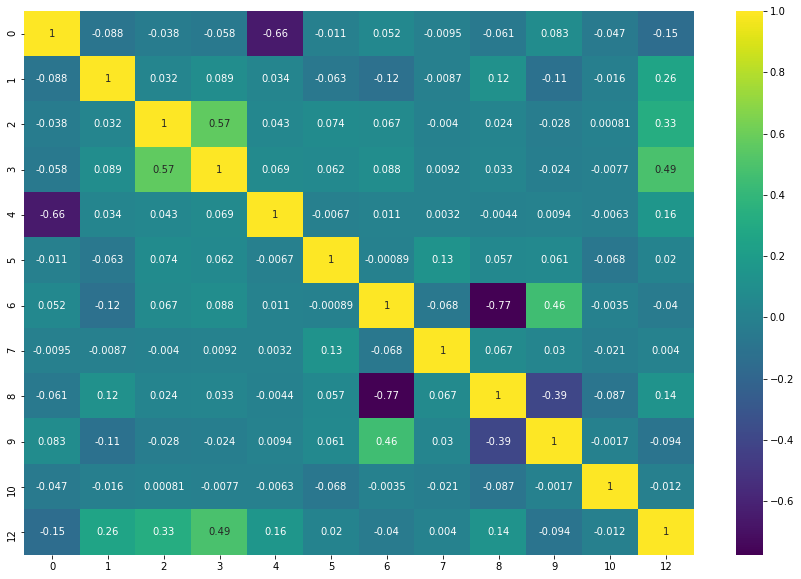

In [9]:
#pcc 분석(11번째 열 제거)
import seaborn as sns
df = df.drop([df.columns[11]], axis = 1)
plt.figure(figsize = (15, 10))
corr = df.corr()
#print(corr)
sns.heatmap(corr, cmap = 'viridis', annot = True)
plt.show()

In [10]:
#train, val data 나누기
df = df.to_numpy()
inp_num = 11

x = df[:, 0:inp_num]
y = df[:, inp_num]

X_train, X_val, Y_train, Y_val = train_test_split(x, y, test_size=0.2, stratify=y, random_state=seed)

In [11]:
#test set 경로
test_H_path= 'feature extract/test_H/'
test_H_files = glob.glob(os.path.join(test_H_path, "*.txt"))
print(test_H_files)
test_H_each_file = (pd.read_csv(f, sep='\t', header=None) for f in test_H_files) 

['feature extract/test_H\\BHJ_fpPrintStat_TT_H.txt', 'feature extract/test_H\\krs_fpPrintStat_TT_H.txt']


In [12]:
#class 별 비율 확인
test_H_file_list = list(test_H_each_file)

ratio = 2
test_sampling_ratio_H = []

for i in test_H_file_list:
    class0 = len(i[i[org_input_num]==0]) 
    class1 = len(i[i[org_input_num]==1])
    print("class0: ", class0)
    print("class1: ", class1)
    print("class0/class1: ", '%0.2f' %(class0/class1))
    print("sampling ratio: ", '%0.2f' %(ratio*class1/class0), '\n')
    test_sampling_ratio_H.append(ratio*class1/class0)

class0:  582788
class1:  93635
class0/class1:  6.22
sampling ratio:  0.32 

class0:  875505
class1:  118714
class0/class1:  7.37
sampling ratio:  0.27 



In [13]:
#4가지 test set 만들기
test_df_0 = pd.DataFrame() # 1) class0만 있는 test set
test_df_1 = pd.DataFrame() # 2) class1만 있는 test set
test_df_sub = pd.DataFrame()# 3)class0, class1 각각 2:1로 구성된 test set
test_df = pd.DataFrame() # subsampling x test set

for data, smp_ratio in  zip(test_H_file_list, test_sampling_ratio_H):
    df_class0_sub = data[data[org_input_num]==0].sample(frac=smp_ratio)
    print("sub 0: ", len(df_class0_sub))
    df_class0 = data[data[org_input_num]==0]
    print("org 0: ", len(df_class0))
    #class0만 있는 test set
    test_df_0 = pd.concat([test_df_0, df_class0], ignore_index = True)
    print("only 0 concat: ", len(test_df_0), '\n')
                           
    df_class1 = data[data[org_input_num]==1]
    print("1: ", len(df_class1))
    #class1만 있는 test set
    test_df_1 = pd.concat([test_df_1, df_class1], ignore_index = True)
    print("only 1 concat: ", len(test_df_1), '\n')
          
    #class0, class1 각각 2:1로 구성된 test set
    test_df_sub = pd.concat([test_df_sub,df_class0_sub, df_class1], ignore_index = True)
    print("sub concat: ", len(test_df_sub), '\n')
          
    # subsampling x test set
    test_df = pd.concat([test_df,df_class0, df_class1], ignore_index = True)
    print("org concat: ", len(test_df), '\n')

sub 0:  187270
org 0:  582788
only 0 concat:  582788 

1:  93635
only 1 concat:  93635 

sub concat:  280905 

org concat:  676423 

sub 0:  237428
org 0:  875505
only 0 concat:  1458293 

1:  118714
only 1 concat:  212349 

sub concat:  637047 

org concat:  1670642 



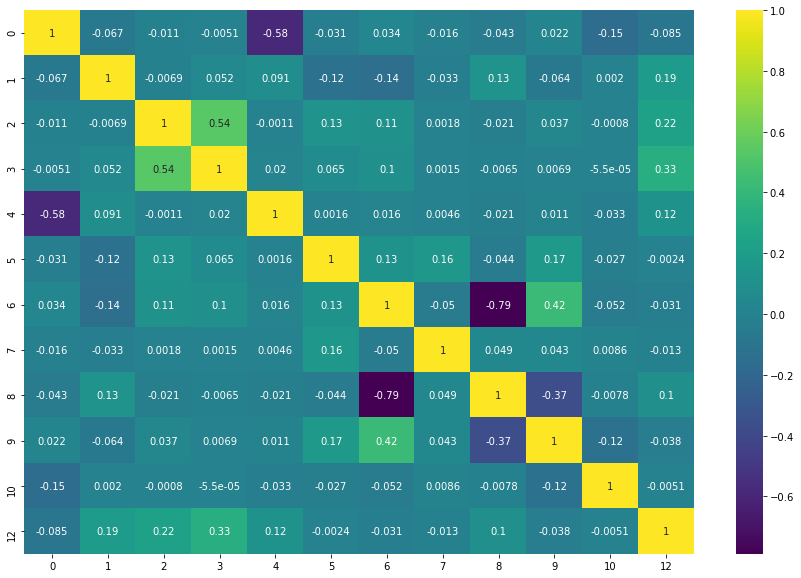

In [14]:
#pcc 분석(11번째 열 제거)
import seaborn as sns
test_df = test_df.drop([test_df.columns[11]], axis = 1)
test_df_0 = test_df_0.drop([test_df_0.columns[11]], axis = 1)
test_df_1 = test_df_1.drop([test_df_1.columns[11]], axis = 1)
test_df_sub = test_df_sub.drop([test_df_sub.columns[11]], axis = 1)
plt.figure(figsize = (15, 10))
corr = test_df.corr()
#print(corr)
sns.heatmap(corr, cmap = 'viridis', annot = True)
plt.show()

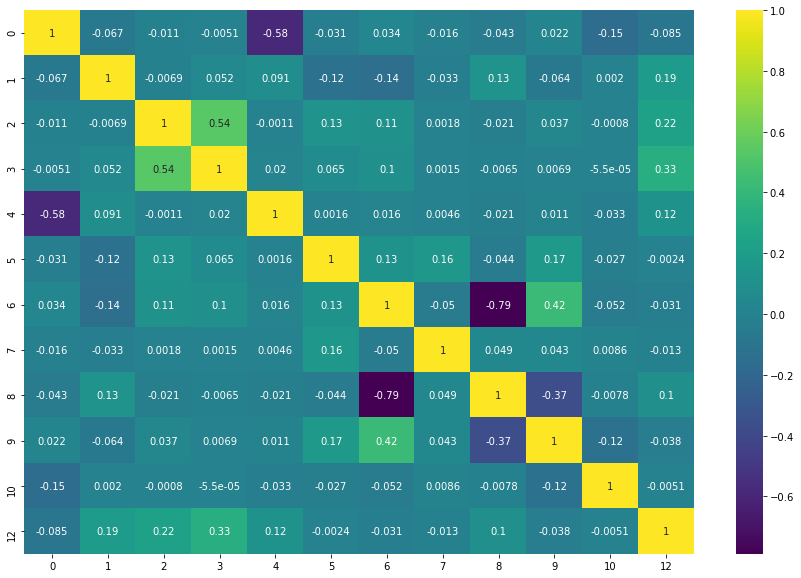

In [15]:
plt.figure(figsize = (15, 10))
sns.heatmap(corr, cmap = 'viridis', annot = True)
plt.show()

In [16]:
test_df_0 = test_df_0.to_numpy()
test_df_1 = test_df_1.to_numpy()
test_df_sub = test_df_sub.to_numpy()
test_df = test_df.to_numpy()    

In [17]:
#4개의 test set
inp_num=11
#only class0
x_class0 = test_df_0[:, 0:inp_num]
y_class0 = test_df_0[:, inp_num]

#only class1
x_class1 = test_df_1[:, 0:inp_num]
x_class1 = test_df_1[:, inp_num]

#subsampling
x_sub = test_df_sub[:, 0:inp_num]
y_sub = test_df_sub[:, inp_num]

#original
x = test_df[:, 0:inp_num]
y = test_df[:, inp_num]

In [14]:
# MLP: 12x30x1 - 100 epochs
num_epochs = 100

start = time.time()  # 시작 시간 저장

model = Sequential()
model.add(Dense(30, input_dim=inp_num, activation='sigmoid'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=[model_metrics])
history = []
history.append(model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=num_epochs, batch_size=num_batch))
model.save('mlp_100.h5')

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

Epoch 1/100
9839/9839 [==============================] - 4s 438us/step - loss: 0.2096 - acc: 0.6654 - val_loss: 0.1913 - val_acc: 0.6699
Epoch 2/100
9839/9839 [==============================] - 4s 438us/step - loss: 0.1800 - acc: 0.7156 - val_loss: 0.1719 - val_acc: 0.7393
Epoch 3/100
9839/9839 [==============================] - 4s 440us/step - loss: 0.1676 - acc: 0.7455 - val_loss: 0.1643 - val_acc: 0.7488
Epoch 4/100
9839/9839 [==============================] - 4s 420us/step - loss: 0.1621 - acc: 0.7510 - val_loss: 0.1602 - val_acc: 0.7529
Epoch 5/100
9839/9839 [==============================] - 4s 431us/step - loss: 0.1586 - acc: 0.7559 - val_loss: 0.1572 - val_acc: 0.7574
Epoch 6/100
9839/9839 [==============================] - 4s 445us/step - loss: 0.1560 - acc: 0.7599 - val_loss: 0.1551 - val_acc: 0.7610
Epoch 7/100
9839/9839 [==============================] - 4s 430us/step - loss: 0.1541 - acc: 0.7632 - val_loss: 0.1536 - val_acc: 0.7639
Epoch 8/100
9839/9839 [==================

In [15]:
# MLP: 12x30x1 - 200 epochs
num_epochs = 200

start = time.time()  # 시작 시간 저장

model = Sequential()
model.add(Dense(30, input_dim=inp_num, activation='sigmoid'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=[model_metrics])

history.append(model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=num_epochs, batch_size=num_batch))
model.save('mlp_200.h5')

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

Epoch 1/200
9839/9839 [==============================] - 5s 464us/step - loss: 0.2059 - acc: 0.6668 - val_loss: 0.1905 - val_acc: 0.6712
Epoch 2/200
9839/9839 [==============================] - 4s 436us/step - loss: 0.1803 - acc: 0.7195 - val_loss: 0.1727 - val_acc: 0.7470
Epoch 3/200
9839/9839 [==============================] - 4s 435us/step - loss: 0.1685 - acc: 0.7470 - val_loss: 0.1650 - val_acc: 0.7483
Epoch 4/200
9839/9839 [==============================] - 4s 432us/step - loss: 0.1627 - acc: 0.7506 - val_loss: 0.1607 - val_acc: 0.7529
Epoch 5/200
9839/9839 [==============================] - 4s 431us/step - loss: 0.1591 - acc: 0.7561 - val_loss: 0.1577 - val_acc: 0.7583
Epoch 6/200
9839/9839 [==============================] - 4s 436us/step - loss: 0.1564 - acc: 0.7597 - val_loss: 0.1554 - val_acc: 0.7602
Epoch 7/200
9839/9839 [==============================] - 4s 426us/step - loss: 0.1544 - acc: 0.7620 - val_loss: 0.1537 - val_acc: 0.7631
Epoch 8/200
9839/9839 [==================

9839/9839 [==============================] - 4s 401us/step - loss: 0.1468 - acc: 0.7782 - val_loss: 0.1470 - val_acc: 0.7772
Epoch 120/200
9839/9839 [==============================] - 4s 416us/step - loss: 0.1468 - acc: 0.7782 - val_loss: 0.1469 - val_acc: 0.7771
Epoch 121/200
9839/9839 [==============================] - 4s 416us/step - loss: 0.1467 - acc: 0.7782 - val_loss: 0.1469 - val_acc: 0.7773
Epoch 122/200
9839/9839 [==============================] - 4s 412us/step - loss: 0.1467 - acc: 0.7782 - val_loss: 0.1469 - val_acc: 0.7774
Epoch 123/200
9839/9839 [==============================] - 4s 398us/step - loss: 0.1467 - acc: 0.7782 - val_loss: 0.1468 - val_acc: 0.7772
Epoch 124/200
9839/9839 [==============================] - 4s 402us/step - loss: 0.1467 - acc: 0.7782 - val_loss: 0.1468 - val_acc: 0.7772
Epoch 125/200
9839/9839 [==============================] - 4s 417us/step - loss: 0.1466 - acc: 0.7782 - val_loss: 0.1468 - val_acc: 0.7773
Epoch 126/200
9839/9839 [================

9839/9839 [==============================] - 4s 434us/step - loss: 0.1458 - acc: 0.7789 - val_loss: 0.1459 - val_acc: 0.7777
Epoch 179/200
9839/9839 [==============================] - 5s 463us/step - loss: 0.1457 - acc: 0.7789 - val_loss: 0.1459 - val_acc: 0.7775
Epoch 180/200
9839/9839 [==============================] - 4s 452us/step - loss: 0.1457 - acc: 0.7790 - val_loss: 0.1460 - val_acc: 0.7777
Epoch 181/200
9839/9839 [==============================] - 4s 447us/step - loss: 0.1457 - acc: 0.7789 - val_loss: 0.1459 - val_acc: 0.7775
Epoch 182/200
9839/9839 [==============================] - 4s 448us/step - loss: 0.1457 - acc: 0.7790 - val_loss: 0.1459 - val_acc: 0.7778
Epoch 183/200
9839/9839 [==============================] - 4s 441us/step - loss: 0.1457 - acc: 0.7791 - val_loss: 0.1458 - val_acc: 0.7779
Epoch 184/200
9839/9839 [==============================] - 4s 443us/step - loss: 0.1457 - acc: 0.7790 - val_loss: 0.1458 - val_acc: 0.7777
Epoch 185/200
9839/9839 [================

In [16]:
# MLP: 12x30x30x1 - 100 epochs
num_epochs = 100

start = time.time()  # 시작 시간 저장

model = Sequential()
model.add(Dense(30, input_dim=inp_num, activation='sigmoid'))
model.add(Dense(30, input_dim=inp_num, activation='sigmoid'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=[model_metrics])

history.append(model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=num_epochs, batch_size=num_batch))
model.save('mlp_30x30_100.h5')

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

Epoch 1/100
9839/9839 [==============================] - 5s 466us/step - loss: 0.2200 - acc: 0.6667 - val_loss: 0.2174 - val_acc: 0.6667
Epoch 2/100
9839/9839 [==============================] - 4s 450us/step - loss: 0.2126 - acc: 0.6667 - val_loss: 0.2058 - val_acc: 0.6667
Epoch 3/100
9839/9839 [==============================] - 4s 456us/step - loss: 0.1942 - acc: 0.6732 - val_loss: 0.1816 - val_acc: 0.6971
Epoch 4/100
9839/9839 [==============================] - 5s 463us/step - loss: 0.1730 - acc: 0.7381 - val_loss: 0.1669 - val_acc: 0.7476
Epoch 5/100
9839/9839 [==============================] - 5s 461us/step - loss: 0.1636 - acc: 0.7495 - val_loss: 0.1611 - val_acc: 0.7517
Epoch 6/100
9839/9839 [==============================] - 4s 456us/step - loss: 0.1592 - acc: 0.7548 - val_loss: 0.1575 - val_acc: 0.7571
Epoch 7/100
9839/9839 [==============================] - 4s 444us/step - loss: 0.1560 - acc: 0.7591 - val_loss: 0.1549 - val_acc: 0.7610
Epoch 8/100
9839/9839 [==================

In [17]:
# MLP: 12x120x1 - 100 epochs
num_epochs = 100

start = time.time()  # 시작 시간 저장

model = Sequential()
model.add(Dense(120, input_dim=inp_num, activation='sigmoid'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=[model_metrics])

history.append(model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=num_epochs, batch_size=num_batch))
model.save('mlp_120_100.h5')

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

Epoch 1/100
9839/9839 [==============================] - 5s 464us/step - loss: 0.2034 - acc: 0.6687 - val_loss: 0.1859 - val_acc: 0.6830
Epoch 2/100
9839/9839 [==============================] - 4s 446us/step - loss: 0.1760 - acc: 0.7285 - val_loss: 0.1691 - val_acc: 0.7460
Epoch 3/100
9839/9839 [==============================] - 4s 447us/step - loss: 0.1655 - acc: 0.7471 - val_loss: 0.1626 - val_acc: 0.7499
Epoch 4/100
9839/9839 [==============================] - 5s 462us/step - loss: 0.1605 - acc: 0.7522 - val_loss: 0.1587 - val_acc: 0.7543
Epoch 5/100
9839/9839 [==============================] - 5s 460us/step - loss: 0.1572 - acc: 0.7570 - val_loss: 0.1559 - val_acc: 0.7585
Epoch 6/100
9839/9839 [==============================] - 5s 475us/step - loss: 0.1548 - acc: 0.7617 - val_loss: 0.1539 - val_acc: 0.7648
Epoch 7/100
9839/9839 [==============================] - 5s 461us/step - loss: 0.1531 - acc: 0.7671 - val_loss: 0.1527 - val_acc: 0.7680
Epoch 8/100
9839/9839 [==================

In [18]:
# MLP: 12x30x1 - 1000 epochs
num_epochs = 1000

start = time.time()  # 시작 시간 저장

model = Sequential()
model.add(Dense(30, input_dim=inp_num, activation='sigmoid'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=[model_metrics])

history.append(model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=num_epochs, batch_size=num_batch))
model.save('mlp_1000.h5')

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

Epoch 1/1000
9839/9839 [==============================] - 4s 431us/step - loss: 0.2048 - acc: 0.6658 - val_loss: 0.1896 - val_acc: 0.6768
Epoch 2/1000
9839/9839 [==============================] - 4s 439us/step - loss: 0.1793 - acc: 0.7198 - val_loss: 0.1718 - val_acc: 0.7457
Epoch 3/1000
9839/9839 [==============================] - 4s 455us/step - loss: 0.1679 - acc: 0.7465 - val_loss: 0.1648 - val_acc: 0.7481
Epoch 4/1000
9839/9839 [==============================] - 4s 444us/step - loss: 0.1626 - acc: 0.7496 - val_loss: 0.1606 - val_acc: 0.7519
Epoch 5/1000
9839/9839 [==============================] - 4s 440us/step - loss: 0.1590 - acc: 0.7554 - val_loss: 0.1576 - val_acc: 0.7571
Epoch 6/1000
9839/9839 [==============================] - 4s 431us/step - loss: 0.1563 - acc: 0.7588 - val_loss: 0.1553 - val_acc: 0.7600
Epoch 7/1000
9839/9839 [==============================] - 4s 444us/step - loss: 0.1543 - acc: 0.7625 - val_loss: 0.1536 - val_acc: 0.7643
Epoch 8/1000
9839/9839 [==========

9839/9839 [==============================] - 4s 448us/step - loss: 0.1479 - acc: 0.7752 - val_loss: 0.1481 - val_acc: 0.7734
Epoch 61/1000
9839/9839 [==============================] - 5s 477us/step - loss: 0.1479 - acc: 0.7753 - val_loss: 0.1481 - val_acc: 0.7742
Epoch 62/1000
9839/9839 [==============================] - 4s 437us/step - loss: 0.1478 - acc: 0.7756 - val_loss: 0.1481 - val_acc: 0.7742
Epoch 63/1000
9839/9839 [==============================] - 4s 436us/step - loss: 0.1478 - acc: 0.7760 - val_loss: 0.1480 - val_acc: 0.7748
Epoch 64/1000
9839/9839 [==============================] - 4s 424us/step - loss: 0.1478 - acc: 0.7763 - val_loss: 0.1480 - val_acc: 0.7764
Epoch 65/1000
9839/9839 [==============================] - 4s 432us/step - loss: 0.1478 - acc: 0.7766 - val_loss: 0.1480 - val_acc: 0.7766
Epoch 66/1000
9839/9839 [==============================] - 4s 432us/step - loss: 0.1477 - acc: 0.7771 - val_loss: 0.1480 - val_acc: 0.7764
Epoch 67/1000
9839/9839 [================

Epoch 119/1000
9839/9839 [==============================] - 4s 415us/step - loss: 0.1468 - acc: 0.7783 - val_loss: 0.1470 - val_acc: 0.7771
Epoch 120/1000
9839/9839 [==============================] - 4s 431us/step - loss: 0.1467 - acc: 0.7783 - val_loss: 0.1470 - val_acc: 0.7773
Epoch 121/1000
9839/9839 [==============================] - 4s 436us/step - loss: 0.1467 - acc: 0.7784 - val_loss: 0.1470 - val_acc: 0.7772
Epoch 122/1000
9839/9839 [==============================] - 4s 418us/step - loss: 0.1467 - acc: 0.7784 - val_loss: 0.1469 - val_acc: 0.7771
Epoch 123/1000
9839/9839 [==============================] - 4s 418us/step - loss: 0.1467 - acc: 0.7784 - val_loss: 0.1469 - val_acc: 0.7773
Epoch 124/1000
9839/9839 [==============================] - 4s 416us/step - loss: 0.1467 - acc: 0.7784 - val_loss: 0.1469 - val_acc: 0.7773
Epoch 125/1000
9839/9839 [==============================] - 4s 431us/step - loss: 0.1467 - acc: 0.7784 - val_loss: 0.1469 - val_acc: 0.7772
Epoch 126/1000
9839/

9839/9839 [==============================] - 4s 423us/step - loss: 0.1452 - acc: 0.7794 - val_loss: 0.1453 - val_acc: 0.7782
Epoch 236/1000
9839/9839 [==============================] - 4s 428us/step - loss: 0.1451 - acc: 0.7793 - val_loss: 0.1453 - val_acc: 0.7783
Epoch 237/1000
9839/9839 [==============================] - 4s 429us/step - loss: 0.1451 - acc: 0.7793 - val_loss: 0.1453 - val_acc: 0.7785
Epoch 238/1000
9839/9839 [==============================] - 4s 427us/step - loss: 0.1451 - acc: 0.7794 - val_loss: 0.1453 - val_acc: 0.7784
Epoch 239/1000
9839/9839 [==============================] - 4s 414us/step - loss: 0.1451 - acc: 0.7793 - val_loss: 0.1452 - val_acc: 0.7785
Epoch 240/1000
9839/9839 [==============================] - 4s 420us/step - loss: 0.1451 - acc: 0.7794 - val_loss: 0.1452 - val_acc: 0.7785
Epoch 241/1000
9839/9839 [==============================] - 4s 440us/step - loss: 0.1451 - acc: 0.7794 - val_loss: 0.1452 - val_acc: 0.7787
Epoch 242/1000
9839/9839 [=========

9839/9839 [==============================] - 4s 427us/step - loss: 0.1442 - acc: 0.7795 - val_loss: 0.1443 - val_acc: 0.7789
Epoch 352/1000
9839/9839 [==============================] - 4s 427us/step - loss: 0.1442 - acc: 0.7795 - val_loss: 0.1443 - val_acc: 0.7789
Epoch 353/1000
9839/9839 [==============================] - 4s 415us/step - loss: 0.1442 - acc: 0.7795 - val_loss: 0.1443 - val_acc: 0.7792
Epoch 354/1000
9839/9839 [==============================] - 4s 418us/step - loss: 0.1442 - acc: 0.7795 - val_loss: 0.1443 - val_acc: 0.7792
Epoch 355/1000
9839/9839 [==============================] - 4s 427us/step - loss: 0.1442 - acc: 0.7795 - val_loss: 0.1443 - val_acc: 0.7792
Epoch 356/1000
9839/9839 [==============================] - 4s 428us/step - loss: 0.1442 - acc: 0.7794 - val_loss: 0.1443 - val_acc: 0.7792
Epoch 357/1000
9839/9839 [==============================] - 4s 428us/step - loss: 0.1442 - acc: 0.7795 - val_loss: 0.1443 - val_acc: 0.7790
Epoch 358/1000
9839/9839 [=========

9839/9839 [==============================] - 4s 412us/step - loss: 0.1437 - acc: 0.7799 - val_loss: 0.1439 - val_acc: 0.7794
Epoch 468/1000
9839/9839 [==============================] - 4s 419us/step - loss: 0.1437 - acc: 0.7799 - val_loss: 0.1439 - val_acc: 0.7795
Epoch 469/1000
9839/9839 [==============================] - 4s 426us/step - loss: 0.1437 - acc: 0.7799 - val_loss: 0.1438 - val_acc: 0.7795
Epoch 470/1000
9839/9839 [==============================] - 4s 427us/step - loss: 0.1437 - acc: 0.7799 - val_loss: 0.1438 - val_acc: 0.7795
Epoch 471/1000
9839/9839 [==============================] - 4s 424us/step - loss: 0.1437 - acc: 0.7800 - val_loss: 0.1439 - val_acc: 0.7793
Epoch 472/1000
9839/9839 [==============================] - 4s 418us/step - loss: 0.1437 - acc: 0.7799 - val_loss: 0.1439 - val_acc: 0.7793
Epoch 473/1000
9839/9839 [==============================] - 4s 425us/step - loss: 0.1437 - acc: 0.7800 - val_loss: 0.1438 - val_acc: 0.7794
Epoch 474/1000
9839/9839 [=========

9839/9839 [==============================] - 4s 430us/step - loss: 0.1434 - acc: 0.7801 - val_loss: 0.1435 - val_acc: 0.7796
Epoch 584/1000
9839/9839 [==============================] - 4s 431us/step - loss: 0.1434 - acc: 0.7804 - val_loss: 0.1435 - val_acc: 0.7800
Epoch 585/1000
9839/9839 [==============================] - 4s 428us/step - loss: 0.1434 - acc: 0.7802 - val_loss: 0.1436 - val_acc: 0.7798
Epoch 586/1000
9839/9839 [==============================] - 4s 413us/step - loss: 0.1434 - acc: 0.7803 - val_loss: 0.1435 - val_acc: 0.7797
Epoch 587/1000
9839/9839 [==============================] - 4s 425us/step - loss: 0.1434 - acc: 0.7803 - val_loss: 0.1436 - val_acc: 0.7800
Epoch 588/1000
9839/9839 [==============================] - 4s 441us/step - loss: 0.1434 - acc: 0.7804 - val_loss: 0.1435 - val_acc: 0.7799
Epoch 589/1000
9839/9839 [==============================] - 4s 440us/step - loss: 0.1434 - acc: 0.7803 - val_loss: 0.1436 - val_acc: 0.7799
Epoch 590/1000
9839/9839 [=========

9839/9839 [==============================] - 4s 430us/step - loss: 0.1431 - acc: 0.7808 - val_loss: 0.1432 - val_acc: 0.7806
Epoch 700/1000
9839/9839 [==============================] - 4s 428us/step - loss: 0.1431 - acc: 0.7808 - val_loss: 0.1432 - val_acc: 0.7797
Epoch 701/1000
9839/9839 [==============================] - 4s 425us/step - loss: 0.1431 - acc: 0.7809 - val_loss: 0.1432 - val_acc: 0.7808
Epoch 702/1000
9839/9839 [==============================] - 4s 433us/step - loss: 0.1431 - acc: 0.7808 - val_loss: 0.1432 - val_acc: 0.7796
Epoch 703/1000
9839/9839 [==============================] - 4s 432us/step - loss: 0.1431 - acc: 0.7808 - val_loss: 0.1433 - val_acc: 0.7807
Epoch 704/1000
9839/9839 [==============================] - 4s 424us/step - loss: 0.1431 - acc: 0.7809 - val_loss: 0.1432 - val_acc: 0.7798
Epoch 705/1000
9839/9839 [==============================] - 4s 423us/step - loss: 0.1431 - acc: 0.7808 - val_loss: 0.1432 - val_acc: 0.7809
Epoch 706/1000
9839/9839 [=========

9839/9839 [==============================] - 4s 441us/step - loss: 0.1428 - acc: 0.7814 - val_loss: 0.1430 - val_acc: 0.7813
Epoch 816/1000
9839/9839 [==============================] - 4s 431us/step - loss: 0.1428 - acc: 0.7813 - val_loss: 0.1430 - val_acc: 0.7802
Epoch 817/1000
9839/9839 [==============================] - 4s 438us/step - loss: 0.1428 - acc: 0.7815 - val_loss: 0.1429 - val_acc: 0.7816
Epoch 818/1000
9839/9839 [==============================] - 4s 451us/step - loss: 0.1428 - acc: 0.7815 - val_loss: 0.1430 - val_acc: 0.7815
Epoch 819/1000
9839/9839 [==============================] - 4s 445us/step - loss: 0.1428 - acc: 0.7813 - val_loss: 0.1429 - val_acc: 0.7814
Epoch 820/1000
9839/9839 [==============================] - 4s 445us/step - loss: 0.1428 - acc: 0.7814 - val_loss: 0.1429 - val_acc: 0.7808
Epoch 821/1000
9839/9839 [==============================] - 4s 435us/step - loss: 0.1428 - acc: 0.7814 - val_loss: 0.1430 - val_acc: 0.7807
Epoch 822/1000
9839/9839 [=========

9839/9839 [==============================] - 4s 438us/step - loss: 0.1426 - acc: 0.7818 - val_loss: 0.1427 - val_acc: 0.7821
Epoch 932/1000
9839/9839 [==============================] - 4s 415us/step - loss: 0.1426 - acc: 0.7817 - val_loss: 0.1427 - val_acc: 0.7822
Epoch 933/1000
9839/9839 [==============================] - 4s 411us/step - loss: 0.1426 - acc: 0.7818 - val_loss: 0.1427 - val_acc: 0.7821
Epoch 934/1000
9839/9839 [==============================] - 4s 425us/step - loss: 0.1426 - acc: 0.7818 - val_loss: 0.1427 - val_acc: 0.7822
Epoch 935/1000
9839/9839 [==============================] - 4s 427us/step - loss: 0.1426 - acc: 0.7819 - val_loss: 0.1427 - val_acc: 0.7821
Epoch 936/1000
9839/9839 [==============================] - 4s 430us/step - loss: 0.1426 - acc: 0.7818 - val_loss: 0.1427 - val_acc: 0.7821
Epoch 937/1000
9839/9839 [==============================] - 4s 417us/step - loss: 0.1426 - acc: 0.7817 - val_loss: 0.1428 - val_acc: 0.7816
Epoch 938/1000
9839/9839 [=========

In [19]:
# MLP: 12x30x1 - 2000 epochs
num_epochs = 2000

start = time.time()  # 시작 시간 저장

model = Sequential()
model.add(Dense(30, input_dim=inp_num, activation='sigmoid'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=[model_metrics])

history.append(model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=num_epochs, batch_size=num_batch))
model.save('mlp_2000.h5')

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

Epoch 1/2000
9839/9839 [==============================] - 4s 441us/step - loss: 0.2073 - acc: 0.6643 - val_loss: 0.1902 - val_acc: 0.6730
Epoch 2/2000
9839/9839 [==============================] - 4s 423us/step - loss: 0.1786 - acc: 0.7191 - val_loss: 0.1703 - val_acc: 0.7451
Epoch 3/2000
9839/9839 [==============================] - 4s 432us/step - loss: 0.1661 - acc: 0.7477 - val_loss: 0.1630 - val_acc: 0.7506
Epoch 4/2000
9839/9839 [==============================] - 4s 441us/step - loss: 0.1608 - acc: 0.7529 - val_loss: 0.1590 - val_acc: 0.7545
Epoch 5/2000
9839/9839 [==============================] - 4s 439us/step - loss: 0.1575 - acc: 0.7573 - val_loss: 0.1563 - val_acc: 0.7592
Epoch 6/2000
9839/9839 [==============================] - 4s 437us/step - loss: 0.1552 - acc: 0.7619 - val_loss: 0.1543 - val_acc: 0.7632
Epoch 7/2000
9839/9839 [==============================] - 4s 425us/step - loss: 0.1535 - acc: 0.7659 - val_loss: 0.1529 - val_acc: 0.7664
Epoch 8/2000
9839/9839 [==========

9839/9839 [==============================] - 4s 424us/step - loss: 0.1483 - acc: 0.7742 - val_loss: 0.1485 - val_acc: 0.7731
Epoch 61/2000
9839/9839 [==============================] - 4s 424us/step - loss: 0.1482 - acc: 0.7743 - val_loss: 0.1484 - val_acc: 0.7729
Epoch 62/2000
9839/9839 [==============================] - 4s 402us/step - loss: 0.1482 - acc: 0.7744 - val_loss: 0.1484 - val_acc: 0.7730
Epoch 63/2000
9839/9839 [==============================] - 4s 398us/step - loss: 0.1482 - acc: 0.7745 - val_loss: 0.1484 - val_acc: 0.7729
Epoch 64/2000
9839/9839 [==============================] - 4s 414us/step - loss: 0.1481 - acc: 0.7744 - val_loss: 0.1483 - val_acc: 0.7738
Epoch 65/2000
9839/9839 [==============================] - 4s 416us/step - loss: 0.1481 - acc: 0.7745 - val_loss: 0.1483 - val_acc: 0.7738
Epoch 66/2000
9839/9839 [==============================] - 4s 417us/step - loss: 0.1480 - acc: 0.7746 - val_loss: 0.1483 - val_acc: 0.7736
Epoch 67/2000
9839/9839 [================

Epoch 119/2000
9839/9839 [==============================] - 4s 396us/step - loss: 0.1467 - acc: 0.7783 - val_loss: 0.1470 - val_acc: 0.7773
Epoch 120/2000
9839/9839 [==============================] - 4s 394us/step - loss: 0.1467 - acc: 0.7784 - val_loss: 0.1469 - val_acc: 0.7771
Epoch 121/2000
9839/9839 [==============================] - 4s 422us/step - loss: 0.1467 - acc: 0.7784 - val_loss: 0.1470 - val_acc: 0.7772
Epoch 122/2000
9839/9839 [==============================] - 4s 426us/step - loss: 0.1467 - acc: 0.7784 - val_loss: 0.1469 - val_acc: 0.7773
Epoch 123/2000
9839/9839 [==============================] - 4s 426us/step - loss: 0.1467 - acc: 0.7784 - val_loss: 0.1469 - val_acc: 0.7772
Epoch 124/2000
9839/9839 [==============================] - 4s 402us/step - loss: 0.1467 - acc: 0.7784 - val_loss: 0.1469 - val_acc: 0.7772
Epoch 125/2000
9839/9839 [==============================] - 4s 394us/step - loss: 0.1466 - acc: 0.7784 - val_loss: 0.1468 - val_acc: 0.7772
Epoch 126/2000
9839/

9839/9839 [==============================] - 4s 417us/step - loss: 0.1450 - acc: 0.7798 - val_loss: 0.1452 - val_acc: 0.7783
Epoch 236/2000
9839/9839 [==============================] - 4s 423us/step - loss: 0.1449 - acc: 0.7797 - val_loss: 0.1452 - val_acc: 0.7785
Epoch 237/2000
9839/9839 [==============================] - 4s 420us/step - loss: 0.1449 - acc: 0.7798 - val_loss: 0.1451 - val_acc: 0.7790
Epoch 238/2000
9839/9839 [==============================] - 4s 392us/step - loss: 0.1449 - acc: 0.7798 - val_loss: 0.1451 - val_acc: 0.7785
Epoch 239/2000
9839/9839 [==============================] - 4s 399us/step - loss: 0.1449 - acc: 0.7798 - val_loss: 0.1451 - val_acc: 0.7790
Epoch 240/2000
9839/9839 [==============================] - 4s 418us/step - loss: 0.1449 - acc: 0.7798 - val_loss: 0.1451 - val_acc: 0.7788
Epoch 241/2000
9839/9839 [==============================] - 4s 422us/step - loss: 0.1449 - acc: 0.7798 - val_loss: 0.1451 - val_acc: 0.7789
Epoch 242/2000
9839/9839 [=========

9839/9839 [==============================] - 4s 410us/step - loss: 0.1441 - acc: 0.7802 - val_loss: 0.1443 - val_acc: 0.7788
Epoch 352/2000
9839/9839 [==============================] - 4s 394us/step - loss: 0.1441 - acc: 0.7800 - val_loss: 0.1443 - val_acc: 0.7787
Epoch 353/2000
9839/9839 [==============================] - 4s 411us/step - loss: 0.1441 - acc: 0.7800 - val_loss: 0.1443 - val_acc: 0.7792
Epoch 354/2000
9839/9839 [==============================] - 4s 421us/step - loss: 0.1441 - acc: 0.7801 - val_loss: 0.1443 - val_acc: 0.7791
Epoch 355/2000
9839/9839 [==============================] - 4s 418us/step - loss: 0.1441 - acc: 0.7801 - val_loss: 0.1443 - val_acc: 0.7790
Epoch 356/2000
9839/9839 [==============================] - 4s 417us/step - loss: 0.1441 - acc: 0.7801 - val_loss: 0.1443 - val_acc: 0.7791
Epoch 357/2000
9839/9839 [==============================] - 4s 395us/step - loss: 0.1441 - acc: 0.7802 - val_loss: 0.1443 - val_acc: 0.7792
Epoch 358/2000
9839/9839 [=========

9839/9839 [==============================] - 4s 414us/step - loss: 0.1439 - acc: 0.7805 - val_loss: 0.1440 - val_acc: 0.7795
Epoch 468/2000
9839/9839 [==============================] - 4s 418us/step - loss: 0.1439 - acc: 0.7805 - val_loss: 0.1440 - val_acc: 0.7797
Epoch 469/2000
9839/9839 [==============================] - 4s 419us/step - loss: 0.1438 - acc: 0.7805 - val_loss: 0.1440 - val_acc: 0.7794
Epoch 470/2000
9839/9839 [==============================] - 4s 403us/step - loss: 0.1438 - acc: 0.7804 - val_loss: 0.1440 - val_acc: 0.7796
Epoch 471/2000
9839/9839 [==============================] - 4s 390us/step - loss: 0.1438 - acc: 0.7806 - val_loss: 0.1440 - val_acc: 0.7795
Epoch 472/2000
9839/9839 [==============================] - 4s 413us/step - loss: 0.1438 - acc: 0.7805 - val_loss: 0.1441 - val_acc: 0.7795
Epoch 473/2000
9839/9839 [==============================] - 4s 419us/step - loss: 0.1438 - acc: 0.7806 - val_loss: 0.1440 - val_acc: 0.7794
Epoch 474/2000
9839/9839 [=========

9839/9839 [==============================] - 4s 424us/step - loss: 0.1437 - acc: 0.7807 - val_loss: 0.1438 - val_acc: 0.7800
Epoch 584/2000
9839/9839 [==============================] - 4s 430us/step - loss: 0.1437 - acc: 0.7808 - val_loss: 0.1438 - val_acc: 0.7799
Epoch 585/2000
9839/9839 [==============================] - 4s 437us/step - loss: 0.1436 - acc: 0.7808 - val_loss: 0.1439 - val_acc: 0.7802
Epoch 586/2000
9839/9839 [==============================] - 4s 435us/step - loss: 0.1436 - acc: 0.7808 - val_loss: 0.1438 - val_acc: 0.7800
Epoch 587/2000
9839/9839 [==============================] - 4s 431us/step - loss: 0.1436 - acc: 0.7809 - val_loss: 0.1439 - val_acc: 0.7801
Epoch 588/2000
9839/9839 [==============================] - 4s 419us/step - loss: 0.1436 - acc: 0.7809 - val_loss: 0.1438 - val_acc: 0.7800
Epoch 589/2000
9839/9839 [==============================] - 4s 431us/step - loss: 0.1436 - acc: 0.7807 - val_loss: 0.1439 - val_acc: 0.7801
Epoch 590/2000
9839/9839 [=========

9839/9839 [==============================] - 4s 415us/step - loss: 0.1435 - acc: 0.7810 - val_loss: 0.1437 - val_acc: 0.7801
Epoch 700/2000
9839/9839 [==============================] - 4s 389us/step - loss: 0.1435 - acc: 0.7810 - val_loss: 0.1437 - val_acc: 0.7804
Epoch 701/2000
9839/9839 [==============================] - 4s 397us/step - loss: 0.1435 - acc: 0.7811 - val_loss: 0.1437 - val_acc: 0.7803
Epoch 702/2000
9839/9839 [==============================] - 4s 416us/step - loss: 0.1435 - acc: 0.7811 - val_loss: 0.1437 - val_acc: 0.7804
Epoch 703/2000
9839/9839 [==============================] - 4s 417us/step - loss: 0.1435 - acc: 0.7811 - val_loss: 0.1437 - val_acc: 0.7803
Epoch 704/2000
9839/9839 [==============================] - 4s 417us/step - loss: 0.1435 - acc: 0.7811 - val_loss: 0.1437 - val_acc: 0.7804
Epoch 705/2000
9839/9839 [==============================] - 4s 392us/step - loss: 0.1435 - acc: 0.7810 - val_loss: 0.1436 - val_acc: 0.7802
Epoch 706/2000
9839/9839 [=========

9839/9839 [==============================] - 4s 421us/step - loss: 0.1433 - acc: 0.7812 - val_loss: 0.1436 - val_acc: 0.7806
Epoch 816/2000
9839/9839 [==============================] - 4s 422us/step - loss: 0.1433 - acc: 0.7812 - val_loss: 0.1436 - val_acc: 0.7801
Epoch 817/2000
9839/9839 [==============================] - 4s 420us/step - loss: 0.1433 - acc: 0.7813 - val_loss: 0.1435 - val_acc: 0.7807
Epoch 818/2000
9839/9839 [==============================] - 4s 399us/step - loss: 0.1433 - acc: 0.7812 - val_loss: 0.1435 - val_acc: 0.7807
Epoch 819/2000
9839/9839 [==============================] - 4s 392us/step - loss: 0.1433 - acc: 0.7813 - val_loss: 0.1435 - val_acc: 0.7807
Epoch 820/2000
9839/9839 [==============================] - 4s 417us/step - loss: 0.1433 - acc: 0.7813 - val_loss: 0.1435 - val_acc: 0.7807
Epoch 821/2000
9839/9839 [==============================] - 4s 422us/step - loss: 0.1433 - acc: 0.7813 - val_loss: 0.1435 - val_acc: 0.7801
Epoch 822/2000
9839/9839 [=========

9839/9839 [==============================] - 4s 396us/step - loss: 0.1432 - acc: 0.7815 - val_loss: 0.1434 - val_acc: 0.7808
Epoch 932/2000
9839/9839 [==============================] - 4s 414us/step - loss: 0.1432 - acc: 0.7814 - val_loss: 0.1434 - val_acc: 0.7808
Epoch 933/2000
9839/9839 [==============================] - 4s 423us/step - loss: 0.1432 - acc: 0.7814 - val_loss: 0.1434 - val_acc: 0.7808
Epoch 934/2000
9839/9839 [==============================] - 4s 419us/step - loss: 0.1432 - acc: 0.7813 - val_loss: 0.1434 - val_acc: 0.7811
Epoch 935/2000
9839/9839 [==============================] - 4s 413us/step - loss: 0.1432 - acc: 0.7815 - val_loss: 0.1434 - val_acc: 0.7808
Epoch 936/2000
9839/9839 [==============================] - 4s 397us/step - loss: 0.1432 - acc: 0.7814 - val_loss: 0.1434 - val_acc: 0.7809
Epoch 937/2000
9839/9839 [==============================] - 4s 412us/step - loss: 0.1432 - acc: 0.7814 - val_loss: 0.1434 - val_acc: 0.7806
Epoch 938/2000
9839/9839 [=========

9839/9839 [==============================] - 4s 432us/step - loss: 0.1431 - acc: 0.7816 - val_loss: 0.1432 - val_acc: 0.7814
Epoch 1048/2000
9839/9839 [==============================] - 4s 432us/step - loss: 0.1431 - acc: 0.7816 - val_loss: 0.1432 - val_acc: 0.7815
Epoch 1049/2000
9839/9839 [==============================] - 4s 435us/step - loss: 0.1431 - acc: 0.7816 - val_loss: 0.1432 - val_acc: 0.7811
Epoch 1050/2000
9839/9839 [==============================] - 4s 422us/step - loss: 0.1431 - acc: 0.7817 - val_loss: 0.1432 - val_acc: 0.7811
Epoch 1051/2000
9839/9839 [==============================] - 4s 423us/step - loss: 0.1431 - acc: 0.7817 - val_loss: 0.1432 - val_acc: 0.7812
Epoch 1052/2000
9839/9839 [==============================] - 4s 432us/step - loss: 0.1431 - acc: 0.7817 - val_loss: 0.1432 - val_acc: 0.7810
Epoch 1053/2000
9839/9839 [==============================] - 4s 433us/step - loss: 0.1431 - acc: 0.7816 - val_loss: 0.1433 - val_acc: 0.7806
Epoch 1054/2000
9839/9839 [==

9839/9839 [==============================] - 4s 406us/step - loss: 0.1430 - acc: 0.7818 - val_loss: 0.1431 - val_acc: 0.7813
Epoch 1164/2000
9839/9839 [==============================] - 4s 398us/step - loss: 0.1430 - acc: 0.7817 - val_loss: 0.1431 - val_acc: 0.7813
Epoch 1165/2000
9839/9839 [==============================] - 4s 425us/step - loss: 0.1430 - acc: 0.7818 - val_loss: 0.1431 - val_acc: 0.7815
Epoch 1166/2000
9839/9839 [==============================] - 4s 425us/step - loss: 0.1430 - acc: 0.7817 - val_loss: 0.1431 - val_acc: 0.7807
Epoch 1167/2000
9839/9839 [==============================] - 4s 427us/step - loss: 0.1430 - acc: 0.7816 - val_loss: 0.1431 - val_acc: 0.7815
Epoch 1168/2000
9839/9839 [==============================] - 4s 406us/step - loss: 0.1430 - acc: 0.7818 - val_loss: 0.1431 - val_acc: 0.7816
Epoch 1169/2000
9839/9839 [==============================] - 4s 399us/step - loss: 0.1430 - acc: 0.7818 - val_loss: 0.1431 - val_acc: 0.7816
Epoch 1170/2000
9839/9839 [==

9839/9839 [==============================] - 4s 426us/step - loss: 0.1429 - acc: 0.7817 - val_loss: 0.1430 - val_acc: 0.7810
Epoch 1280/2000
9839/9839 [==============================] - 4s 399us/step - loss: 0.1429 - acc: 0.7817 - val_loss: 0.1430 - val_acc: 0.7809
Epoch 1281/2000
9839/9839 [==============================] - 4s 397us/step - loss: 0.1429 - acc: 0.7817 - val_loss: 0.1430 - val_acc: 0.7810
Epoch 1282/2000
9839/9839 [==============================] - 4s 426us/step - loss: 0.1429 - acc: 0.7816 - val_loss: 0.1430 - val_acc: 0.7810
Epoch 1283/2000
9839/9839 [==============================] - 4s 425us/step - loss: 0.1429 - acc: 0.7817 - val_loss: 0.1430 - val_acc: 0.7810
Epoch 1284/2000
9839/9839 [==============================] - 4s 428us/step - loss: 0.1429 - acc: 0.7818 - val_loss: 0.1430 - val_acc: 0.7810
Epoch 1285/2000
9839/9839 [==============================] - 4s 408us/step - loss: 0.1429 - acc: 0.7817 - val_loss: 0.1430 - val_acc: 0.7816
Epoch 1286/2000
9839/9839 [==

9839/9839 [==============================] - 4s 428us/step - loss: 0.1428 - acc: 0.7817 - val_loss: 0.1429 - val_acc: 0.7813
Epoch 1396/2000
9839/9839 [==============================] - 4s 420us/step - loss: 0.1428 - acc: 0.7818 - val_loss: 0.1429 - val_acc: 0.7818
Epoch 1397/2000
9839/9839 [==============================] - 4s 397us/step - loss: 0.1428 - acc: 0.7817 - val_loss: 0.1429 - val_acc: 0.7815
Epoch 1398/2000
9839/9839 [==============================] - 4s 405us/step - loss: 0.1428 - acc: 0.7817 - val_loss: 0.1429 - val_acc: 0.7813
Epoch 1399/2000
9839/9839 [==============================] - 4s 425us/step - loss: 0.1428 - acc: 0.7819 - val_loss: 0.1430 - val_acc: 0.7812
Epoch 1400/2000
9839/9839 [==============================] - 4s 433us/step - loss: 0.1428 - acc: 0.7818 - val_loss: 0.1430 - val_acc: 0.7812
Epoch 1401/2000
9839/9839 [==============================] - 4s 422us/step - loss: 0.1428 - acc: 0.7817 - val_loss: 0.1429 - val_acc: 0.7810
Epoch 1402/2000
9839/9839 [==

9839/9839 [==============================] - 4s 427us/step - loss: 0.1427 - acc: 0.7817 - val_loss: 0.1428 - val_acc: 0.7818
Epoch 1512/2000
9839/9839 [==============================] - 4s 428us/step - loss: 0.1427 - acc: 0.7818 - val_loss: 0.1428 - val_acc: 0.7816
Epoch 1513/2000
9839/9839 [==============================] - 4s 419us/step - loss: 0.1427 - acc: 0.7816 - val_loss: 0.1428 - val_acc: 0.7818
Epoch 1514/2000
9839/9839 [==============================] - 4s 403us/step - loss: 0.1427 - acc: 0.7818 - val_loss: 0.1428 - val_acc: 0.7817
Epoch 1515/2000
9839/9839 [==============================] - 4s 410us/step - loss: 0.1427 - acc: 0.7818 - val_loss: 0.1428 - val_acc: 0.7814
Epoch 1516/2000
9839/9839 [==============================] - 4s 428us/step - loss: 0.1427 - acc: 0.7818 - val_loss: 0.1428 - val_acc: 0.7818
Epoch 1517/2000
9839/9839 [==============================] - 4s 428us/step - loss: 0.1427 - acc: 0.7818 - val_loss: 0.1428 - val_acc: 0.7811
Epoch 1518/2000
9839/9839 [==

9839/9839 [==============================] - 4s 411us/step - loss: 0.1426 - acc: 0.7818 - val_loss: 0.1427 - val_acc: 0.7817
Epoch 1628/2000
9839/9839 [==============================] - 4s 421us/step - loss: 0.1426 - acc: 0.7818 - val_loss: 0.1427 - val_acc: 0.7817
Epoch 1629/2000
9839/9839 [==============================] - 4s 426us/step - loss: 0.1426 - acc: 0.7818 - val_loss: 0.1427 - val_acc: 0.7819
Epoch 1630/2000
9839/9839 [==============================] - 4s 421us/step - loss: 0.1426 - acc: 0.7819 - val_loss: 0.1427 - val_acc: 0.7812
Epoch 1631/2000
9839/9839 [==============================] - 4s 400us/step - loss: 0.1426 - acc: 0.7819 - val_loss: 0.1427 - val_acc: 0.7819
Epoch 1632/2000
9839/9839 [==============================] - 4s 416us/step - loss: 0.1426 - acc: 0.7818 - val_loss: 0.1427 - val_acc: 0.7819
Epoch 1633/2000
9839/9839 [==============================] - 4s 426us/step - loss: 0.1426 - acc: 0.7818 - val_loss: 0.1427 - val_acc: 0.7812
Epoch 1634/2000
9839/9839 [==

9839/9839 [==============================] - 4s 391us/step - loss: 0.1425 - acc: 0.7819 - val_loss: 0.1427 - val_acc: 0.7815
Epoch 1744/2000
9839/9839 [==============================] - 4s 418us/step - loss: 0.1425 - acc: 0.7819 - val_loss: 0.1427 - val_acc: 0.7822
Epoch 1745/2000
9839/9839 [==============================] - 4s 432us/step - loss: 0.1425 - acc: 0.7818 - val_loss: 0.1427 - val_acc: 0.7814
Epoch 1746/2000
9839/9839 [==============================] - 4s 427us/step - loss: 0.1425 - acc: 0.7820 - val_loss: 0.1427 - val_acc: 0.7813
Epoch 1747/2000
9839/9839 [==============================] - 4s 416us/step - loss: 0.1425 - acc: 0.7820 - val_loss: 0.1427 - val_acc: 0.7821
Epoch 1748/2000
9839/9839 [==============================] - 4s 399us/step - loss: 0.1425 - acc: 0.7819 - val_loss: 0.1427 - val_acc: 0.7817
Epoch 1749/2000
9839/9839 [==============================] - 4s 423us/step - loss: 0.1425 - acc: 0.7819 - val_loss: 0.1427 - val_acc: 0.7817
Epoch 1750/2000
9839/9839 [==

9839/9839 [==============================] - 4s 411us/step - loss: 0.1424 - acc: 0.7820 - val_loss: 0.1426 - val_acc: 0.7814
Epoch 1860/2000
9839/9839 [==============================] - 4s 397us/step - loss: 0.1424 - acc: 0.7819 - val_loss: 0.1426 - val_acc: 0.7814
Epoch 1861/2000
9839/9839 [==============================] - 4s 415us/step - loss: 0.1424 - acc: 0.7821 - val_loss: 0.1426 - val_acc: 0.7813
Epoch 1862/2000
9839/9839 [==============================] - 4s 423us/step - loss: 0.1424 - acc: 0.7820 - val_loss: 0.1426 - val_acc: 0.7822
Epoch 1863/2000
9839/9839 [==============================] - 4s 416us/step - loss: 0.1424 - acc: 0.7820 - val_loss: 0.1426 - val_acc: 0.7813
Epoch 1864/2000
9839/9839 [==============================] - 4s 406us/step - loss: 0.1424 - acc: 0.7820 - val_loss: 0.1426 - val_acc: 0.7820
Epoch 1865/2000
9839/9839 [==============================] - 4s 396us/step - loss: 0.1424 - acc: 0.7820 - val_loss: 0.1426 - val_acc: 0.7815
Epoch 1866/2000
9839/9839 [==

9839/9839 [==============================] - 4s 417us/step - loss: 0.1424 - acc: 0.7820 - val_loss: 0.1425 - val_acc: 0.7819
Epoch 1976/2000
9839/9839 [==============================] - 4s 415us/step - loss: 0.1424 - acc: 0.7821 - val_loss: 0.1425 - val_acc: 0.7820
Epoch 1977/2000
9839/9839 [==============================] - 4s 400us/step - loss: 0.1424 - acc: 0.7820 - val_loss: 0.1425 - val_acc: 0.7820
Epoch 1978/2000
9839/9839 [==============================] - 4s 413us/step - loss: 0.1424 - acc: 0.7820 - val_loss: 0.1425 - val_acc: 0.7815
Epoch 1979/2000
9839/9839 [==============================] - 4s 422us/step - loss: 0.1424 - acc: 0.7820 - val_loss: 0.1425 - val_acc: 0.7819
Epoch 1980/2000
9839/9839 [==============================] - 4s 422us/step - loss: 0.1424 - acc: 0.7820 - val_loss: 0.1425 - val_acc: 0.7821
Epoch 1981/2000
9839/9839 [==============================] - 4s 419us/step - loss: 0.1424 - acc: 0.7820 - val_loss: 0.1425 - val_acc: 0.7818
Epoch 1982/2000
9839/9839 [==

In [62]:
# MLP: 12x30x1 - 6000 epochs
num_epochs = 6000

start = time.time()  # 시작 시간 저장

model = Sequential()
model.add(Dense(30, input_dim=inp_num, activation='sigmoid'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=[model_metrics])

history.append(model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=num_epochs, batch_size=num_batch))
model.save('mlp_6000.h5')

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

Epoch 1/6000
9839/9839 [==============================] - 4s 439us/step - loss: 0.2051 - acc: 0.6651 - val_loss: 0.1899 - val_acc: 0.6739
Epoch 2/6000
9839/9839 [==============================] - 4s 456us/step - loss: 0.1802 - acc: 0.7196 - val_loss: 0.1729 - val_acc: 0.7455
Epoch 3/6000
9839/9839 [==============================] - 4s 447us/step - loss: 0.1687 - acc: 0.7462 - val_loss: 0.1653 - val_acc: 0.7476
Epoch 4/6000
9839/9839 [==============================] - 4s 450us/step - loss: 0.1630 - acc: 0.7493 - val_loss: 0.1609 - val_acc: 0.7518
Epoch 5/6000
9839/9839 [==============================] - 4s 451us/step - loss: 0.1591 - acc: 0.7550 - val_loss: 0.1576 - val_acc: 0.7573
Epoch 6/6000
9839/9839 [==============================] - 4s 450us/step - loss: 0.1563 - acc: 0.7593 - val_loss: 0.1552 - val_acc: 0.7607
Epoch 7/6000
9839/9839 [==============================] - 4s 449us/step - loss: 0.1542 - acc: 0.7629 - val_loss: 0.1535 - val_acc: 0.7638
Epoch 8/6000
9839/9839 [==========

9839/9839 [==============================] - 4s 412us/step - loss: 0.1481 - acc: 0.7750 - val_loss: 0.1483 - val_acc: 0.7734
Epoch 61/6000
9839/9839 [==============================] - 4s 406us/step - loss: 0.1480 - acc: 0.7750 - val_loss: 0.1482 - val_acc: 0.7741
Epoch 62/6000
9839/9839 [==============================] - 4s 389us/step - loss: 0.1480 - acc: 0.7752 - val_loss: 0.1482 - val_acc: 0.7734
Epoch 63/6000
9839/9839 [==============================] - 4s 400us/step - loss: 0.1479 - acc: 0.7754 - val_loss: 0.1482 - val_acc: 0.7743
Epoch 64/6000
9839/9839 [==============================] - 4s 409us/step - loss: 0.1479 - acc: 0.7755 - val_loss: 0.1481 - val_acc: 0.7754
Epoch 65/6000
9839/9839 [==============================] - 4s 412us/step - loss: 0.1479 - acc: 0.7757 - val_loss: 0.1481 - val_acc: 0.7765
Epoch 66/6000
9839/9839 [==============================] - 4s 411us/step - loss: 0.1478 - acc: 0.7762 - val_loss: 0.1481 - val_acc: 0.7765
Epoch 67/6000
9839/9839 [================

Epoch 119/6000
9839/9839 [==============================] - 4s 393us/step - loss: 0.1466 - acc: 0.7787 - val_loss: 0.1468 - val_acc: 0.7772
Epoch 120/6000
9839/9839 [==============================] - 4s 394us/step - loss: 0.1465 - acc: 0.7787 - val_loss: 0.1468 - val_acc: 0.7778
Epoch 121/6000
9839/9839 [==============================] - 4s 412us/step - loss: 0.1465 - acc: 0.7788 - val_loss: 0.1468 - val_acc: 0.7772
Epoch 122/6000
9839/9839 [==============================] - 4s 412us/step - loss: 0.1465 - acc: 0.7787 - val_loss: 0.1467 - val_acc: 0.7772
Epoch 123/6000
9839/9839 [==============================] - 4s 410us/step - loss: 0.1465 - acc: 0.7788 - val_loss: 0.1467 - val_acc: 0.7774
Epoch 124/6000
9839/9839 [==============================] - 4s 396us/step - loss: 0.1465 - acc: 0.7787 - val_loss: 0.1467 - val_acc: 0.7778
Epoch 125/6000
9839/9839 [==============================] - 4s 392us/step - loss: 0.1464 - acc: 0.7788 - val_loss: 0.1466 - val_acc: 0.7772
Epoch 126/6000
9839/

9839/9839 [==============================] - 4s 388us/step - loss: 0.1452 - acc: 0.7793 - val_loss: 0.1454 - val_acc: 0.7781
Epoch 236/6000
9839/9839 [==============================] - 4s 402us/step - loss: 0.1452 - acc: 0.7793 - val_loss: 0.1454 - val_acc: 0.7782
Epoch 237/6000
9839/9839 [==============================] - 4s 408us/step - loss: 0.1452 - acc: 0.7793 - val_loss: 0.1453 - val_acc: 0.7782
Epoch 238/6000
9839/9839 [==============================] - 4s 412us/step - loss: 0.1452 - acc: 0.7793 - val_loss: 0.1453 - val_acc: 0.7782
Epoch 239/6000
9839/9839 [==============================] - 4s 411us/step - loss: 0.1452 - acc: 0.7793 - val_loss: 0.1453 - val_acc: 0.7782
Epoch 240/6000
9839/9839 [==============================] - 4s 394us/step - loss: 0.1451 - acc: 0.7793 - val_loss: 0.1453 - val_acc: 0.7784
Epoch 241/6000
9839/9839 [==============================] - 4s 398us/step - loss: 0.1451 - acc: 0.7793 - val_loss: 0.1453 - val_acc: 0.7782
Epoch 242/6000
9839/9839 [=========

9839/9839 [==============================] - 4s 395us/step - loss: 0.1443 - acc: 0.7800 - val_loss: 0.1445 - val_acc: 0.7789
Epoch 352/6000
9839/9839 [==============================] - 4s 410us/step - loss: 0.1443 - acc: 0.7800 - val_loss: 0.1445 - val_acc: 0.7789
Epoch 353/6000
9839/9839 [==============================] - 4s 415us/step - loss: 0.1443 - acc: 0.7800 - val_loss: 0.1445 - val_acc: 0.7791
Epoch 354/6000
9839/9839 [==============================] - 4s 414us/step - loss: 0.1443 - acc: 0.7800 - val_loss: 0.1445 - val_acc: 0.7792
Epoch 355/6000
9839/9839 [==============================] - 4s 401us/step - loss: 0.1443 - acc: 0.7800 - val_loss: 0.1445 - val_acc: 0.7790
Epoch 356/6000
9839/9839 [==============================] - 4s 389us/step - loss: 0.1443 - acc: 0.7801 - val_loss: 0.1445 - val_acc: 0.7792
Epoch 357/6000
9839/9839 [==============================] - 4s 409us/step - loss: 0.1443 - acc: 0.7801 - val_loss: 0.1445 - val_acc: 0.7793
Epoch 358/6000
9839/9839 [=========

9839/9839 [==============================] - 4s 404us/step - loss: 0.1439 - acc: 0.7812 - val_loss: 0.1440 - val_acc: 0.7803
Epoch 468/6000
9839/9839 [==============================] - 4s 412us/step - loss: 0.1439 - acc: 0.7812 - val_loss: 0.1441 - val_acc: 0.7809
Epoch 469/6000
9839/9839 [==============================] - 4s 413us/step - loss: 0.1439 - acc: 0.7812 - val_loss: 0.1440 - val_acc: 0.7805
Epoch 470/6000
9839/9839 [==============================] - 4s 413us/step - loss: 0.1439 - acc: 0.7811 - val_loss: 0.1440 - val_acc: 0.7806
Epoch 471/6000
9839/9839 [==============================] - 4s 391us/step - loss: 0.1439 - acc: 0.7812 - val_loss: 0.1440 - val_acc: 0.7798
Epoch 472/6000
9839/9839 [==============================] - 4s 397us/step - loss: 0.1439 - acc: 0.7812 - val_loss: 0.1441 - val_acc: 0.7796
Epoch 473/6000
9839/9839 [==============================] - 4s 412us/step - loss: 0.1439 - acc: 0.7812 - val_loss: 0.1440 - val_acc: 0.7800
Epoch 474/6000
9839/9839 [=========

9839/9839 [==============================] - 4s 414us/step - loss: 0.1436 - acc: 0.7815 - val_loss: 0.1437 - val_acc: 0.7807
Epoch 584/6000
9839/9839 [==============================] - 4s 413us/step - loss: 0.1436 - acc: 0.7817 - val_loss: 0.1437 - val_acc: 0.7804
Epoch 585/6000
9839/9839 [==============================] - 4s 415us/step - loss: 0.1436 - acc: 0.7815 - val_loss: 0.1438 - val_acc: 0.7811
Epoch 586/6000
9839/9839 [==============================] - 4s 400us/step - loss: 0.1436 - acc: 0.7816 - val_loss: 0.1437 - val_acc: 0.7807
Epoch 587/6000
9839/9839 [==============================] - 4s 391us/step - loss: 0.1436 - acc: 0.7817 - val_loss: 0.1438 - val_acc: 0.7810
Epoch 588/6000
9839/9839 [==============================] - 4s 408us/step - loss: 0.1436 - acc: 0.7816 - val_loss: 0.1437 - val_acc: 0.7804
Epoch 589/6000
9839/9839 [==============================] - 4s 410us/step - loss: 0.1436 - acc: 0.7815 - val_loss: 0.1438 - val_acc: 0.7811
Epoch 590/6000
9839/9839 [=========

9839/9839 [==============================] - 4s 407us/step - loss: 0.1433 - acc: 0.7817 - val_loss: 0.1435 - val_acc: 0.7811
Epoch 700/6000
9839/9839 [==============================] - 4s 409us/step - loss: 0.1433 - acc: 0.7817 - val_loss: 0.1435 - val_acc: 0.7812
Epoch 701/6000
9839/9839 [==============================] - 4s 411us/step - loss: 0.1433 - acc: 0.7818 - val_loss: 0.1435 - val_acc: 0.7812
Epoch 702/6000
9839/9839 [==============================] - 4s 392us/step - loss: 0.1433 - acc: 0.7816 - val_loss: 0.1435 - val_acc: 0.7812
Epoch 703/6000
9839/9839 [==============================] - 4s 394us/step - loss: 0.1433 - acc: 0.7817 - val_loss: 0.1435 - val_acc: 0.7810
Epoch 704/6000
9839/9839 [==============================] - 4s 411us/step - loss: 0.1433 - acc: 0.7818 - val_loss: 0.1435 - val_acc: 0.7814
Epoch 705/6000
9839/9839 [==============================] - 4s 415us/step - loss: 0.1433 - acc: 0.7816 - val_loss: 0.1435 - val_acc: 0.7812
Epoch 706/6000
9839/9839 [=========

9839/9839 [==============================] - 4s 413us/step - loss: 0.1431 - acc: 0.7819 - val_loss: 0.1433 - val_acc: 0.7815
Epoch 816/6000
9839/9839 [==============================] - 4s 417us/step - loss: 0.1431 - acc: 0.7818 - val_loss: 0.1433 - val_acc: 0.7807
Epoch 817/6000
9839/9839 [==============================] - 4s 404us/step - loss: 0.1431 - acc: 0.7818 - val_loss: 0.1432 - val_acc: 0.7813
Epoch 818/6000
9839/9839 [==============================] - 4s 390us/step - loss: 0.1431 - acc: 0.7818 - val_loss: 0.1432 - val_acc: 0.7812
Epoch 819/6000
9839/9839 [==============================] - 4s 404us/step - loss: 0.1431 - acc: 0.7818 - val_loss: 0.1432 - val_acc: 0.7813
Epoch 820/6000
9839/9839 [==============================] - 4s 410us/step - loss: 0.1431 - acc: 0.7817 - val_loss: 0.1432 - val_acc: 0.7816
Epoch 821/6000
9839/9839 [==============================] - 4s 415us/step - loss: 0.1431 - acc: 0.7817 - val_loss: 0.1433 - val_acc: 0.7808
Epoch 822/6000
9839/9839 [=========

9839/9839 [==============================] - 4s 411us/step - loss: 0.1429 - acc: 0.7819 - val_loss: 0.1430 - val_acc: 0.7816
Epoch 932/6000
9839/9839 [==============================] - 4s 411us/step - loss: 0.1429 - acc: 0.7819 - val_loss: 0.1430 - val_acc: 0.7817
Epoch 933/6000
9839/9839 [==============================] - 4s 391us/step - loss: 0.1429 - acc: 0.7819 - val_loss: 0.1430 - val_acc: 0.7816
Epoch 934/6000
9839/9839 [==============================] - 4s 397us/step - loss: 0.1429 - acc: 0.7819 - val_loss: 0.1430 - val_acc: 0.7816
Epoch 935/6000
9839/9839 [==============================] - 4s 412us/step - loss: 0.1429 - acc: 0.7819 - val_loss: 0.1430 - val_acc: 0.7816
Epoch 936/6000
9839/9839 [==============================] - 4s 412us/step - loss: 0.1429 - acc: 0.7818 - val_loss: 0.1430 - val_acc: 0.7816
Epoch 937/6000
9839/9839 [==============================] - 4s 416us/step - loss: 0.1429 - acc: 0.7817 - val_loss: 0.1431 - val_acc: 0.7817
Epoch 938/6000
9839/9839 [=========

9839/9839 [==============================] - 4s 414us/step - loss: 0.1427 - acc: 0.7820 - val_loss: 0.1429 - val_acc: 0.7821
Epoch 1048/6000
9839/9839 [==============================] - 4s 403us/step - loss: 0.1427 - acc: 0.7820 - val_loss: 0.1429 - val_acc: 0.7814
Epoch 1049/6000
9839/9839 [==============================] - 4s 393us/step - loss: 0.1427 - acc: 0.7819 - val_loss: 0.1429 - val_acc: 0.7821
Epoch 1050/6000
9839/9839 [==============================] - 4s 406us/step - loss: 0.1427 - acc: 0.7820 - val_loss: 0.1429 - val_acc: 0.7819
Epoch 1051/6000
9839/9839 [==============================] - 4s 413us/step - loss: 0.1427 - acc: 0.7819 - val_loss: 0.1429 - val_acc: 0.7820
Epoch 1052/6000
9839/9839 [==============================] - 4s 412us/step - loss: 0.1427 - acc: 0.7819 - val_loss: 0.1429 - val_acc: 0.7819
Epoch 1053/6000
9839/9839 [==============================] - 4s 408us/step - loss: 0.1427 - acc: 0.7819 - val_loss: 0.1429 - val_acc: 0.7813
Epoch 1054/6000
9839/9839 [==

9839/9839 [==============================] - 4s 411us/step - loss: 0.1426 - acc: 0.7820 - val_loss: 0.1427 - val_acc: 0.7821
Epoch 1164/6000
9839/9839 [==============================] - 4s 394us/step - loss: 0.1426 - acc: 0.7820 - val_loss: 0.1427 - val_acc: 0.7819
Epoch 1165/6000
9839/9839 [==============================] - 4s 399us/step - loss: 0.1426 - acc: 0.7820 - val_loss: 0.1427 - val_acc: 0.7815
Epoch 1166/6000
9839/9839 [==============================] - 4s 415us/step - loss: 0.1426 - acc: 0.7819 - val_loss: 0.1428 - val_acc: 0.7814
Epoch 1167/6000
9839/9839 [==============================] - 4s 414us/step - loss: 0.1426 - acc: 0.7820 - val_loss: 0.1427 - val_acc: 0.7824
Epoch 1168/6000
9839/9839 [==============================] - 4s 413us/step - loss: 0.1426 - acc: 0.7820 - val_loss: 0.1427 - val_acc: 0.7816
Epoch 1169/6000
9839/9839 [==============================] - 4s 394us/step - loss: 0.1426 - acc: 0.7820 - val_loss: 0.1427 - val_acc: 0.7815
Epoch 1170/6000
9839/9839 [==

9839/9839 [==============================] - 4s 397us/step - loss: 0.1425 - acc: 0.7821 - val_loss: 0.1426 - val_acc: 0.7815
Epoch 1280/6000
9839/9839 [==============================] - 4s 397us/step - loss: 0.1425 - acc: 0.7821 - val_loss: 0.1426 - val_acc: 0.7815
Epoch 1281/6000
9839/9839 [==============================] - 4s 403us/step - loss: 0.1425 - acc: 0.7820 - val_loss: 0.1426 - val_acc: 0.7816
Epoch 1282/6000
9839/9839 [==============================] - 4s 411us/step - loss: 0.1425 - acc: 0.7820 - val_loss: 0.1426 - val_acc: 0.7816
Epoch 1283/6000
9839/9839 [==============================] - 4s 414us/step - loss: 0.1425 - acc: 0.7819 - val_loss: 0.1427 - val_acc: 0.7815
Epoch 1284/6000
9839/9839 [==============================] - 4s 402us/step - loss: 0.1425 - acc: 0.7821 - val_loss: 0.1426 - val_acc: 0.7815
Epoch 1285/6000
9839/9839 [==============================] - 4s 390us/step - loss: 0.1425 - acc: 0.7819 - val_loss: 0.1426 - val_acc: 0.7822
Epoch 1286/6000
9839/9839 [==

9839/9839 [==============================] - 4s 391us/step - loss: 0.1424 - acc: 0.7820 - val_loss: 0.1425 - val_acc: 0.7820
Epoch 1396/6000
9839/9839 [==============================] - 4s 395us/step - loss: 0.1424 - acc: 0.7821 - val_loss: 0.1425 - val_acc: 0.7816
Epoch 1397/6000
9839/9839 [==============================] - 4s 411us/step - loss: 0.1424 - acc: 0.7820 - val_loss: 0.1425 - val_acc: 0.7821
Epoch 1398/6000
9839/9839 [==============================] - 4s 411us/step - loss: 0.1424 - acc: 0.7821 - val_loss: 0.1426 - val_acc: 0.7819
Epoch 1399/6000
9839/9839 [==============================] - 4s 411us/step - loss: 0.1424 - acc: 0.7822 - val_loss: 0.1426 - val_acc: 0.7819
Epoch 1400/6000
9839/9839 [==============================] - 4s 400us/step - loss: 0.1424 - acc: 0.7820 - val_loss: 0.1426 - val_acc: 0.7819
Epoch 1401/6000
9839/9839 [==============================] - 4s 393us/step - loss: 0.1424 - acc: 0.7820 - val_loss: 0.1425 - val_acc: 0.7817
Epoch 1402/6000
9839/9839 [==

9839/9839 [==============================] - 4s 389us/step - loss: 0.1423 - acc: 0.7819 - val_loss: 0.1425 - val_acc: 0.7823
Epoch 1512/6000
9839/9839 [==============================] - 4s 410us/step - loss: 0.1423 - acc: 0.7821 - val_loss: 0.1425 - val_acc: 0.7821
Epoch 1513/6000
9839/9839 [==============================] - 4s 413us/step - loss: 0.1423 - acc: 0.7820 - val_loss: 0.1425 - val_acc: 0.7823
Epoch 1514/6000
9839/9839 [==============================] - 4s 412us/step - loss: 0.1423 - acc: 0.7822 - val_loss: 0.1425 - val_acc: 0.7820
Epoch 1515/6000
9839/9839 [==============================] - 4s 403us/step - loss: 0.1423 - acc: 0.7821 - val_loss: 0.1425 - val_acc: 0.7820
Epoch 1516/6000
9839/9839 [==============================] - 4s 392us/step - loss: 0.1423 - acc: 0.7821 - val_loss: 0.1425 - val_acc: 0.7816
Epoch 1517/6000
9839/9839 [==============================] - 4s 407us/step - loss: 0.1423 - acc: 0.7821 - val_loss: 0.1425 - val_acc: 0.7817
Epoch 1518/6000
9839/9839 [==

9839/9839 [==============================] - 4s 403us/step - loss: 0.1422 - acc: 0.7822 - val_loss: 0.1424 - val_acc: 0.7821
Epoch 1628/6000
9839/9839 [==============================] - 4s 410us/step - loss: 0.1422 - acc: 0.7822 - val_loss: 0.1424 - val_acc: 0.7820
Epoch 1629/6000
9839/9839 [==============================] - 4s 412us/step - loss: 0.1422 - acc: 0.7822 - val_loss: 0.1424 - val_acc: 0.7823
Epoch 1630/6000
9839/9839 [==============================] - 4s 409us/step - loss: 0.1422 - acc: 0.7822 - val_loss: 0.1424 - val_acc: 0.7818
Epoch 1631/6000
9839/9839 [==============================] - 4s 393us/step - loss: 0.1422 - acc: 0.7822 - val_loss: 0.1424 - val_acc: 0.7826
Epoch 1632/6000
9839/9839 [==============================] - 4s 401us/step - loss: 0.1422 - acc: 0.7821 - val_loss: 0.1424 - val_acc: 0.7824
Epoch 1633/6000
9839/9839 [==============================] - 4s 412us/step - loss: 0.1422 - acc: 0.7821 - val_loss: 0.1424 - val_acc: 0.7818
Epoch 1634/6000
9839/9839 [==

9839/9839 [==============================] - 4s 419us/step - loss: 0.1422 - acc: 0.7822 - val_loss: 0.1424 - val_acc: 0.7818
Epoch 1744/6000
9839/9839 [==============================] - 4s 421us/step - loss: 0.1422 - acc: 0.7823 - val_loss: 0.1423 - val_acc: 0.7817
Epoch 1745/6000
9839/9839 [==============================] - 4s 390us/step - loss: 0.1422 - acc: 0.7823 - val_loss: 0.1423 - val_acc: 0.7820
Epoch 1746/6000
9839/9839 [==============================] - 4s 396us/step - loss: 0.1422 - acc: 0.7824 - val_loss: 0.1423 - val_acc: 0.7818
Epoch 1747/6000
9839/9839 [==============================] - 4s 417us/step - loss: 0.1422 - acc: 0.7823 - val_loss: 0.1423 - val_acc: 0.7824
Epoch 1748/6000
9839/9839 [==============================] - 4s 421us/step - loss: 0.1422 - acc: 0.7822 - val_loss: 0.1423 - val_acc: 0.7822
Epoch 1749/6000
9839/9839 [==============================] - 4s 421us/step - loss: 0.1422 - acc: 0.7822 - val_loss: 0.1423 - val_acc: 0.7821
Epoch 1750/6000
9839/9839 [==

9839/9839 [==============================] - 4s 394us/step - loss: 0.1421 - acc: 0.7823 - val_loss: 0.1423 - val_acc: 0.7818
Epoch 1860/6000
9839/9839 [==============================] - 4s 410us/step - loss: 0.1421 - acc: 0.7823 - val_loss: 0.1423 - val_acc: 0.7819
Epoch 1861/6000
9839/9839 [==============================] - 4s 418us/step - loss: 0.1421 - acc: 0.7823 - val_loss: 0.1423 - val_acc: 0.7816
Epoch 1862/6000
9839/9839 [==============================] - 4s 419us/step - loss: 0.1421 - acc: 0.7824 - val_loss: 0.1423 - val_acc: 0.7818
Epoch 1863/6000
9839/9839 [==============================] - 4s 414us/step - loss: 0.1421 - acc: 0.7824 - val_loss: 0.1423 - val_acc: 0.7817
Epoch 1864/6000
9839/9839 [==============================] - 4s 396us/step - loss: 0.1421 - acc: 0.7823 - val_loss: 0.1423 - val_acc: 0.7823
Epoch 1865/6000
9839/9839 [==============================] - 4s 408us/step - loss: 0.1421 - acc: 0.7825 - val_loss: 0.1423 - val_acc: 0.7819
Epoch 1866/6000
9839/9839 [==

9839/9839 [==============================] - 4s 416us/step - loss: 0.1421 - acc: 0.7823 - val_loss: 0.1422 - val_acc: 0.7824
Epoch 1976/6000
9839/9839 [==============================] - 4s 420us/step - loss: 0.1420 - acc: 0.7824 - val_loss: 0.1422 - val_acc: 0.7826
Epoch 1977/6000
9839/9839 [==============================] - 4s 403us/step - loss: 0.1420 - acc: 0.7823 - val_loss: 0.1422 - val_acc: 0.7824
Epoch 1978/6000
9839/9839 [==============================] - 4s 397us/step - loss: 0.1420 - acc: 0.7824 - val_loss: 0.1422 - val_acc: 0.7817
Epoch 1979/6000
9839/9839 [==============================] - 4s 417us/step - loss: 0.1421 - acc: 0.7824 - val_loss: 0.1422 - val_acc: 0.7823
Epoch 1980/6000
9839/9839 [==============================] - 4s 415us/step - loss: 0.1420 - acc: 0.7824 - val_loss: 0.1422 - val_acc: 0.7824
Epoch 1981/6000
9839/9839 [==============================] - 4s 427us/step - loss: 0.1420 - acc: 0.7825 - val_loss: 0.1423 - val_acc: 0.7820
Epoch 1982/6000
9839/9839 [==

9839/9839 [==============================] - 4s 393us/step - loss: 0.1420 - acc: 0.7825 - val_loss: 0.1422 - val_acc: 0.7819
Epoch 2092/6000
9839/9839 [==============================] - 4s 409us/step - loss: 0.1420 - acc: 0.7824 - val_loss: 0.1422 - val_acc: 0.7818
Epoch 2093/6000
9839/9839 [==============================] - 4s 413us/step - loss: 0.1420 - acc: 0.7825 - val_loss: 0.1422 - val_acc: 0.7824
Epoch 2094/6000
9839/9839 [==============================] - 4s 414us/step - loss: 0.1420 - acc: 0.7825 - val_loss: 0.1422 - val_acc: 0.7818
Epoch 2095/6000
9839/9839 [==============================] - 4s 414us/step - loss: 0.1420 - acc: 0.7825 - val_loss: 0.1423 - val_acc: 0.7819
Epoch 2096/6000
9839/9839 [==============================] - 4s 394us/step - loss: 0.1420 - acc: 0.7825 - val_loss: 0.1422 - val_acc: 0.7821
Epoch 2097/6000
9839/9839 [==============================] - 4s 403us/step - loss: 0.1420 - acc: 0.7826 - val_loss: 0.1422 - val_acc: 0.7825
Epoch 2098/6000
9839/9839 [==

9839/9839 [==============================] - 4s 419us/step - loss: 0.1420 - acc: 0.7826 - val_loss: 0.1421 - val_acc: 0.7824
Epoch 2208/6000
9839/9839 [==============================] - 4s 422us/step - loss: 0.1420 - acc: 0.7826 - val_loss: 0.1421 - val_acc: 0.7824
Epoch 2209/6000
9839/9839 [==============================] - 4s 399us/step - loss: 0.1420 - acc: 0.7826 - val_loss: 0.1421 - val_acc: 0.7818
Epoch 2210/6000
9839/9839 [==============================] - 4s 399us/step - loss: 0.1420 - acc: 0.7826 - val_loss: 0.1421 - val_acc: 0.7823
Epoch 2211/6000
9839/9839 [==============================] - 4s 417us/step - loss: 0.1420 - acc: 0.7825 - val_loss: 0.1421 - val_acc: 0.7818
Epoch 2212/6000
9839/9839 [==============================] - 4s 419us/step - loss: 0.1420 - acc: 0.7826 - val_loss: 0.1421 - val_acc: 0.7819
Epoch 2213/6000
9839/9839 [==============================] - 4s 421us/step - loss: 0.1420 - acc: 0.7826 - val_loss: 0.1421 - val_acc: 0.7816
Epoch 2214/6000
9839/9839 [==

9839/9839 [==============================] - 4s 394us/step - loss: 0.1419 - acc: 0.7827 - val_loss: 0.1421 - val_acc: 0.7818
Epoch 2324/6000
9839/9839 [==============================] - 4s 396us/step - loss: 0.1419 - acc: 0.7826 - val_loss: 0.1422 - val_acc: 0.7818
Epoch 2325/6000
9839/9839 [==============================] - 4s 418us/step - loss: 0.1419 - acc: 0.7826 - val_loss: 0.1421 - val_acc: 0.7819
Epoch 2326/6000
9839/9839 [==============================] - 4s 420us/step - loss: 0.1419 - acc: 0.7824 - val_loss: 0.1421 - val_acc: 0.7819
Epoch 2327/6000
9839/9839 [==============================] - 4s 415us/step - loss: 0.1419 - acc: 0.7827 - val_loss: 0.1421 - val_acc: 0.7826
Epoch 2328/6000
9839/9839 [==============================] - 4s 395us/step - loss: 0.1419 - acc: 0.7826 - val_loss: 0.1421 - val_acc: 0.7824
Epoch 2329/6000
9839/9839 [==============================] - 4s 393us/step - loss: 0.1419 - acc: 0.7827 - val_loss: 0.1421 - val_acc: 0.7822
Epoch 2330/6000
9839/9839 [==

9839/9839 [==============================] - 4s 417us/step - loss: 0.1419 - acc: 0.7827 - val_loss: 0.1421 - val_acc: 0.7825
Epoch 2440/6000
9839/9839 [==============================] - 4s 417us/step - loss: 0.1419 - acc: 0.7828 - val_loss: 0.1421 - val_acc: 0.7820
Epoch 2441/6000
9839/9839 [==============================] - 4s 414us/step - loss: 0.1419 - acc: 0.7827 - val_loss: 0.1421 - val_acc: 0.7820
Epoch 2442/6000
9839/9839 [==============================] - 4s 394us/step - loss: 0.1419 - acc: 0.7827 - val_loss: 0.1421 - val_acc: 0.7819
Epoch 2443/6000
9839/9839 [==============================] - 4s 405us/step - loss: 0.1419 - acc: 0.7828 - val_loss: 0.1421 - val_acc: 0.7817
Epoch 2444/6000
9839/9839 [==============================] - 4s 420us/step - loss: 0.1419 - acc: 0.7827 - val_loss: 0.1421 - val_acc: 0.7819
Epoch 2445/6000
9839/9839 [==============================] - 4s 420us/step - loss: 0.1419 - acc: 0.7828 - val_loss: 0.1421 - val_acc: 0.7824
Epoch 2446/6000
9839/9839 [==

9839/9839 [==============================] - 4s 404us/step - loss: 0.1419 - acc: 0.7826 - val_loss: 0.1421 - val_acc: 0.7822
Epoch 2556/6000
9839/9839 [==============================] - 4s 401us/step - loss: 0.1419 - acc: 0.7828 - val_loss: 0.1420 - val_acc: 0.7826
Epoch 2557/6000
9839/9839 [==============================] - 4s 417us/step - loss: 0.1419 - acc: 0.7828 - val_loss: 0.1421 - val_acc: 0.7824
Epoch 2558/6000
9839/9839 [==============================] - 4s 421us/step - loss: 0.1419 - acc: 0.7827 - val_loss: 0.1421 - val_acc: 0.7818
Epoch 2559/6000
9839/9839 [==============================] - 4s 423us/step - loss: 0.1419 - acc: 0.7827 - val_loss: 0.1421 - val_acc: 0.7819
Epoch 2560/6000
9839/9839 [==============================] - 4s 403us/step - loss: 0.1419 - acc: 0.7827 - val_loss: 0.1420 - val_acc: 0.7826
Epoch 2561/6000
9839/9839 [==============================] - 4s 398us/step - loss: 0.1419 - acc: 0.7827 - val_loss: 0.1421 - val_acc: 0.7820
Epoch 2562/6000
9839/9839 [==

9839/9839 [==============================] - 4s 417us/step - loss: 0.1418 - acc: 0.7828 - val_loss: 0.1420 - val_acc: 0.7826
Epoch 2672/6000
9839/9839 [==============================] - 4s 423us/step - loss: 0.1418 - acc: 0.7828 - val_loss: 0.1420 - val_acc: 0.7819
Epoch 2673/6000
9839/9839 [==============================] - 4s 414us/step - loss: 0.1418 - acc: 0.7829 - val_loss: 0.1421 - val_acc: 0.7820
Epoch 2674/6000
9839/9839 [==============================] - 4s 395us/step - loss: 0.1418 - acc: 0.7828 - val_loss: 0.1420 - val_acc: 0.7827
Epoch 2675/6000
9839/9839 [==============================] - 4s 404us/step - loss: 0.1418 - acc: 0.7827 - val_loss: 0.1420 - val_acc: 0.7820
Epoch 2676/6000
9839/9839 [==============================] - 4s 422us/step - loss: 0.1418 - acc: 0.7828 - val_loss: 0.1421 - val_acc: 0.7820
Epoch 2677/6000
9839/9839 [==============================] - 4s 426us/step - loss: 0.1418 - acc: 0.7829 - val_loss: 0.1420 - val_acc: 0.7819
Epoch 2678/6000
9839/9839 [==

9839/9839 [==============================] - 4s 400us/step - loss: 0.1418 - acc: 0.7828 - val_loss: 0.1420 - val_acc: 0.7826
Epoch 2788/6000
9839/9839 [==============================] - 4s 395us/step - loss: 0.1418 - acc: 0.7828 - val_loss: 0.1420 - val_acc: 0.7826
Epoch 2789/6000
9839/9839 [==============================] - 4s 415us/step - loss: 0.1418 - acc: 0.7827 - val_loss: 0.1420 - val_acc: 0.7827
Epoch 2790/6000
9839/9839 [==============================] - 4s 418us/step - loss: 0.1418 - acc: 0.7829 - val_loss: 0.1420 - val_acc: 0.7823
Epoch 2791/6000
9839/9839 [==============================] - 4s 422us/step - loss: 0.1418 - acc: 0.7829 - val_loss: 0.1420 - val_acc: 0.7819
Epoch 2792/6000
9839/9839 [==============================] - 4s 406us/step - loss: 0.1418 - acc: 0.7828 - val_loss: 0.1420 - val_acc: 0.7819
Epoch 2793/6000
9839/9839 [==============================] - 4s 394us/step - loss: 0.1418 - acc: 0.7828 - val_loss: 0.1420 - val_acc: 0.7825
Epoch 2794/6000
9839/9839 [==

9839/9839 [==============================] - 4s 414us/step - loss: 0.1418 - acc: 0.7829 - val_loss: 0.1420 - val_acc: 0.7821
Epoch 2904/6000
9839/9839 [==============================] - 4s 420us/step - loss: 0.1418 - acc: 0.7828 - val_loss: 0.1420 - val_acc: 0.7826
Epoch 2905/6000
9839/9839 [==============================] - 4s 418us/step - loss: 0.1418 - acc: 0.7828 - val_loss: 0.1420 - val_acc: 0.7824
Epoch 2906/6000
9839/9839 [==============================] - 4s 404us/step - loss: 0.1418 - acc: 0.7829 - val_loss: 0.1420 - val_acc: 0.7819
Epoch 2907/6000
9839/9839 [==============================] - 4s 395us/step - loss: 0.1418 - acc: 0.7829 - val_loss: 0.1420 - val_acc: 0.7821
Epoch 2908/6000
9839/9839 [==============================] - 4s 413us/step - loss: 0.1418 - acc: 0.7829 - val_loss: 0.1420 - val_acc: 0.7828
Epoch 2909/6000
9839/9839 [==============================] - 4s 420us/step - loss: 0.1418 - acc: 0.7829 - val_loss: 0.1420 - val_acc: 0.7820
Epoch 2910/6000
9839/9839 [==

9839/9839 [==============================] - 4s 416us/step - loss: 0.1418 - acc: 0.7829 - val_loss: 0.1419 - val_acc: 0.7828
Epoch 3020/6000
9839/9839 [==============================] - 4s 394us/step - loss: 0.1417 - acc: 0.7829 - val_loss: 0.1420 - val_acc: 0.7821
Epoch 3021/6000
9839/9839 [==============================] - 4s 398us/step - loss: 0.1418 - acc: 0.7828 - val_loss: 0.1419 - val_acc: 0.7820
Epoch 3022/6000
9839/9839 [==============================] - 4s 417us/step - loss: 0.1417 - acc: 0.7829 - val_loss: 0.1420 - val_acc: 0.7820
Epoch 3023/6000
9839/9839 [==============================] - 4s 418us/step - loss: 0.1417 - acc: 0.7829 - val_loss: 0.1420 - val_acc: 0.7822
Epoch 3024/6000
9839/9839 [==============================] - 4s 418us/step - loss: 0.1417 - acc: 0.7830 - val_loss: 0.1419 - val_acc: 0.7827
Epoch 3025/6000
9839/9839 [==============================] - 4s 398us/step - loss: 0.1417 - acc: 0.7831 - val_loss: 0.1419 - val_acc: 0.7825
Epoch 3026/6000
9839/9839 [==

9839/9839 [==============================] - 4s 415us/step - loss: 0.1417 - acc: 0.7830 - val_loss: 0.1419 - val_acc: 0.7822
Epoch 3136/6000
9839/9839 [==============================] - 4s 422us/step - loss: 0.1417 - acc: 0.7830 - val_loss: 0.1419 - val_acc: 0.7820
Epoch 3137/6000
9839/9839 [==============================] - 4s 419us/step - loss: 0.1417 - acc: 0.7829 - val_loss: 0.1419 - val_acc: 0.7824
Epoch 3138/6000
9839/9839 [==============================] - 4s 406us/step - loss: 0.1417 - acc: 0.7830 - val_loss: 0.1419 - val_acc: 0.7823
Epoch 3139/6000
9839/9839 [==============================] - 4s 394us/step - loss: 0.1417 - acc: 0.7830 - val_loss: 0.1420 - val_acc: 0.7821
Epoch 3140/6000
9839/9839 [==============================] - 4s 412us/step - loss: 0.1417 - acc: 0.7829 - val_loss: 0.1419 - val_acc: 0.7822
Epoch 3141/6000
9839/9839 [==============================] - 4s 414us/step - loss: 0.1417 - acc: 0.7830 - val_loss: 0.1419 - val_acc: 0.7822
Epoch 3142/6000
9839/9839 [==

9839/9839 [==============================] - 4s 418us/step - loss: 0.1417 - acc: 0.7831 - val_loss: 0.1419 - val_acc: 0.7821
Epoch 3252/6000
9839/9839 [==============================] - 4s 396us/step - loss: 0.1417 - acc: 0.7829 - val_loss: 0.1419 - val_acc: 0.7823
Epoch 3253/6000
9839/9839 [==============================] - 4s 397us/step - loss: 0.1417 - acc: 0.7831 - val_loss: 0.1419 - val_acc: 0.7823
Epoch 3254/6000
9839/9839 [==============================] - 4s 419us/step - loss: 0.1417 - acc: 0.7830 - val_loss: 0.1419 - val_acc: 0.7828
Epoch 3255/6000
9839/9839 [==============================] - 4s 422us/step - loss: 0.1417 - acc: 0.7830 - val_loss: 0.1419 - val_acc: 0.7827
Epoch 3256/6000
9839/9839 [==============================] - 4s 423us/step - loss: 0.1417 - acc: 0.7831 - val_loss: 0.1419 - val_acc: 0.7825
Epoch 3257/6000
9839/9839 [==============================] - 4s 401us/step - loss: 0.1417 - acc: 0.7830 - val_loss: 0.1419 - val_acc: 0.7822
Epoch 3258/6000
9839/9839 [==

9839/9839 [==============================] - 4s 405us/step - loss: 0.1417 - acc: 0.7832 - val_loss: 0.1419 - val_acc: 0.7823
Epoch 3368/6000
9839/9839 [==============================] - 4s 417us/step - loss: 0.1417 - acc: 0.7832 - val_loss: 0.1419 - val_acc: 0.7823
Epoch 3369/6000
9839/9839 [==============================] - 4s 421us/step - loss: 0.1417 - acc: 0.7830 - val_loss: 0.1419 - val_acc: 0.7822
Epoch 3370/6000
9839/9839 [==============================] - 4s 419us/step - loss: 0.1417 - acc: 0.7833 - val_loss: 0.1419 - val_acc: 0.7821
Epoch 3371/6000
9839/9839 [==============================] - 4s 392us/step - loss: 0.1417 - acc: 0.7831 - val_loss: 0.1419 - val_acc: 0.7826
Epoch 3372/6000
9839/9839 [==============================] - 4s 411us/step - loss: 0.1417 - acc: 0.7832 - val_loss: 0.1419 - val_acc: 0.7828
Epoch 3373/6000
9839/9839 [==============================] - 4s 421us/step - loss: 0.1417 - acc: 0.7831 - val_loss: 0.1419 - val_acc: 0.7827
Epoch 3374/6000
9839/9839 [==

9839/9839 [==============================] - 4s 419us/step - loss: 0.1416 - acc: 0.7831 - val_loss: 0.1418 - val_acc: 0.7824
Epoch 3484/6000
9839/9839 [==============================] - 4s 404us/step - loss: 0.1416 - acc: 0.7832 - val_loss: 0.1419 - val_acc: 0.7822
Epoch 3485/6000
9839/9839 [==============================] - 4s 401us/step - loss: 0.1416 - acc: 0.7830 - val_loss: 0.1418 - val_acc: 0.7825
Epoch 3486/6000
9839/9839 [==============================] - 4s 413us/step - loss: 0.1416 - acc: 0.7831 - val_loss: 0.1419 - val_acc: 0.7824
Epoch 3487/6000
9839/9839 [==============================] - 4s 419us/step - loss: 0.1416 - acc: 0.7831 - val_loss: 0.1419 - val_acc: 0.7822
Epoch 3488/6000
9839/9839 [==============================] - 4s 419us/step - loss: 0.1416 - acc: 0.7831 - val_loss: 0.1418 - val_acc: 0.7828
Epoch 3489/6000
9839/9839 [==============================] - 4s 403us/step - loss: 0.1416 - acc: 0.7831 - val_loss: 0.1418 - val_acc: 0.7822
Epoch 3490/6000
9839/9839 [==

9839/9839 [==============================] - 4s 403us/step - loss: 0.1416 - acc: 0.7831 - val_loss: 0.1418 - val_acc: 0.7822
Epoch 3600/6000
9839/9839 [==============================] - 4s 419us/step - loss: 0.1416 - acc: 0.7831 - val_loss: 0.1418 - val_acc: 0.7829
Epoch 3601/6000
9839/9839 [==============================] - 4s 421us/step - loss: 0.1416 - acc: 0.7832 - val_loss: 0.1418 - val_acc: 0.7828
Epoch 3602/6000
9839/9839 [==============================] - 4s 423us/step - loss: 0.1416 - acc: 0.7832 - val_loss: 0.1418 - val_acc: 0.7823
Epoch 3603/6000
9839/9839 [==============================] - 4s 396us/step - loss: 0.1416 - acc: 0.7832 - val_loss: 0.1418 - val_acc: 0.7828
Epoch 3604/6000
9839/9839 [==============================] - 4s 399us/step - loss: 0.1416 - acc: 0.7832 - val_loss: 0.1418 - val_acc: 0.7825
Epoch 3605/6000
9839/9839 [==============================] - 4s 420us/step - loss: 0.1416 - acc: 0.7832 - val_loss: 0.1418 - val_acc: 0.7822
Epoch 3606/6000
9839/9839 [==

9839/9839 [==============================] - 4s 424us/step - loss: 0.1416 - acc: 0.7831 - val_loss: 0.1418 - val_acc: 0.7821
Epoch 3716/6000
9839/9839 [==============================] - 4s 400us/step - loss: 0.1416 - acc: 0.7832 - val_loss: 0.1418 - val_acc: 0.7824
Epoch 3717/6000
9839/9839 [==============================] - 4s 396us/step - loss: 0.1416 - acc: 0.7832 - val_loss: 0.1418 - val_acc: 0.7822
Epoch 3718/6000
9839/9839 [==============================] - 4s 411us/step - loss: 0.1416 - acc: 0.7832 - val_loss: 0.1418 - val_acc: 0.7830
Epoch 3719/6000
9839/9839 [==============================] - 4s 414us/step - loss: 0.1416 - acc: 0.7832 - val_loss: 0.1418 - val_acc: 0.7824
Epoch 3720/6000
9839/9839 [==============================] - 4s 419us/step - loss: 0.1416 - acc: 0.7833 - val_loss: 0.1418 - val_acc: 0.7828
Epoch 3721/6000
9839/9839 [==============================] - 4s 406us/step - loss: 0.1416 - acc: 0.7833 - val_loss: 0.1418 - val_acc: 0.7829
Epoch 3722/6000
9839/9839 [==

9839/9839 [==============================] - 4s 403us/step - loss: 0.1415 - acc: 0.7832 - val_loss: 0.1417 - val_acc: 0.7826
Epoch 3832/6000
9839/9839 [==============================] - 4s 421us/step - loss: 0.1415 - acc: 0.7832 - val_loss: 0.1417 - val_acc: 0.7823
Epoch 3833/6000
9839/9839 [==============================] - 4s 415us/step - loss: 0.1415 - acc: 0.7833 - val_loss: 0.1417 - val_acc: 0.7827
Epoch 3834/6000
9839/9839 [==============================] - 4s 420us/step - loss: 0.1415 - acc: 0.7832 - val_loss: 0.1418 - val_acc: 0.7820
Epoch 3835/6000
9839/9839 [==============================] - 4s 393us/step - loss: 0.1415 - acc: 0.7833 - val_loss: 0.1417 - val_acc: 0.7829
Epoch 3836/6000
9839/9839 [==============================] - 4s 395us/step - loss: 0.1415 - acc: 0.7833 - val_loss: 0.1417 - val_acc: 0.7827
Epoch 3837/6000
9839/9839 [==============================] - 4s 417us/step - loss: 0.1415 - acc: 0.7831 - val_loss: 0.1417 - val_acc: 0.7828
Epoch 3838/6000
9839/9839 [==

9839/9839 [==============================] - 4s 421us/step - loss: 0.1415 - acc: 0.7834 - val_loss: 0.1417 - val_acc: 0.7830
Epoch 3948/6000
9839/9839 [==============================] - 4s 409us/step - loss: 0.1415 - acc: 0.7832 - val_loss: 0.1417 - val_acc: 0.7823
Epoch 3949/6000
9839/9839 [==============================] - 4s 392us/step - loss: 0.1415 - acc: 0.7834 - val_loss: 0.1417 - val_acc: 0.7827
Epoch 3950/6000
9839/9839 [==============================] - 4s 400us/step - loss: 0.1415 - acc: 0.7833 - val_loss: 0.1417 - val_acc: 0.7829
Epoch 3951/6000
9839/9839 [==============================] - 4s 417us/step - loss: 0.1415 - acc: 0.7834 - val_loss: 0.1417 - val_acc: 0.7824
Epoch 3952/6000
9839/9839 [==============================] - 4s 418us/step - loss: 0.1415 - acc: 0.7834 - val_loss: 0.1417 - val_acc: 0.7822
Epoch 3953/6000
9839/9839 [==============================] - 4s 417us/step - loss: 0.1415 - acc: 0.7834 - val_loss: 0.1417 - val_acc: 0.7829
Epoch 3954/6000
9839/9839 [==

9839/9839 [==============================] - 4s 400us/step - loss: 0.1414 - acc: 0.7835 - val_loss: 0.1417 - val_acc: 0.7829
Epoch 4064/6000
9839/9839 [==============================] - 4s 418us/step - loss: 0.1414 - acc: 0.7834 - val_loss: 0.1417 - val_acc: 0.7828
Epoch 4065/6000
9839/9839 [==============================] - 4s 421us/step - loss: 0.1414 - acc: 0.7835 - val_loss: 0.1416 - val_acc: 0.7829
Epoch 4066/6000
9839/9839 [==============================] - 4s 419us/step - loss: 0.1414 - acc: 0.7834 - val_loss: 0.1416 - val_acc: 0.7828
Epoch 4067/6000
9839/9839 [==============================] - 4s 404us/step - loss: 0.1414 - acc: 0.7835 - val_loss: 0.1417 - val_acc: 0.7830
Epoch 4068/6000
9839/9839 [==============================] - 4s 395us/step - loss: 0.1414 - acc: 0.7833 - val_loss: 0.1416 - val_acc: 0.7828
Epoch 4069/6000
9839/9839 [==============================] - 4s 410us/step - loss: 0.1414 - acc: 0.7834 - val_loss: 0.1417 - val_acc: 0.7823
Epoch 4070/6000
9839/9839 [==

9839/9839 [==============================] - 4s 414us/step - loss: 0.1414 - acc: 0.7834 - val_loss: 0.1416 - val_acc: 0.7828
Epoch 4180/6000
9839/9839 [==============================] - 4s 417us/step - loss: 0.1414 - acc: 0.7834 - val_loss: 0.1416 - val_acc: 0.7828
Epoch 4181/6000
9839/9839 [==============================] - 4s 394us/step - loss: 0.1414 - acc: 0.7833 - val_loss: 0.1416 - val_acc: 0.7823
Epoch 4182/6000
9839/9839 [==============================] - 4s 392us/step - loss: 0.1414 - acc: 0.7835 - val_loss: 0.1416 - val_acc: 0.7829
Epoch 4183/6000
9839/9839 [==============================] - 4s 416us/step - loss: 0.1414 - acc: 0.7834 - val_loss: 0.1417 - val_acc: 0.7831
Epoch 4184/6000
9839/9839 [==============================] - 4s 419us/step - loss: 0.1414 - acc: 0.7834 - val_loss: 0.1416 - val_acc: 0.7822
Epoch 4185/6000
9839/9839 [==============================] - 4s 418us/step - loss: 0.1414 - acc: 0.7834 - val_loss: 0.1416 - val_acc: 0.7833
Epoch 4186/6000
9839/9839 [==

9839/9839 [==============================] - 4s 395us/step - loss: 0.1414 - acc: 0.7835 - val_loss: 0.1416 - val_acc: 0.7825
Epoch 4296/6000
9839/9839 [==============================] - 4s 410us/step - loss: 0.1414 - acc: 0.7835 - val_loss: 0.1416 - val_acc: 0.7828
Epoch 4297/6000
9839/9839 [==============================] - 4s 412us/step - loss: 0.1414 - acc: 0.7835 - val_loss: 0.1416 - val_acc: 0.7828
Epoch 4298/6000
9839/9839 [==============================] - 4s 420us/step - loss: 0.1414 - acc: 0.7834 - val_loss: 0.1416 - val_acc: 0.7828
Epoch 4299/6000
9839/9839 [==============================] - 4s 411us/step - loss: 0.1414 - acc: 0.7834 - val_loss: 0.1416 - val_acc: 0.7829
Epoch 4300/6000
9839/9839 [==============================] - 4s 394us/step - loss: 0.1414 - acc: 0.7835 - val_loss: 0.1416 - val_acc: 0.7828
Epoch 4301/6000
9839/9839 [==============================] - 4s 408us/step - loss: 0.1414 - acc: 0.7835 - val_loss: 0.1416 - val_acc: 0.7829
Epoch 4302/6000
9839/9839 [==

9839/9839 [==============================] - 4s 414us/step - loss: 0.1413 - acc: 0.7835 - val_loss: 0.1415 - val_acc: 0.7830
Epoch 4412/6000
9839/9839 [==============================] - 4s 416us/step - loss: 0.1413 - acc: 0.7835 - val_loss: 0.1416 - val_acc: 0.7826
Epoch 4413/6000
9839/9839 [==============================] - 4s 405us/step - loss: 0.1413 - acc: 0.7834 - val_loss: 0.1415 - val_acc: 0.7830
Epoch 4414/6000
9839/9839 [==============================] - 4s 394us/step - loss: 0.1413 - acc: 0.7836 - val_loss: 0.1415 - val_acc: 0.7829
Epoch 4415/6000
9839/9839 [==============================] - 4s 404us/step - loss: 0.1413 - acc: 0.7836 - val_loss: 0.1415 - val_acc: 0.7832
Epoch 4416/6000
9839/9839 [==============================] - 4s 417us/step - loss: 0.1413 - acc: 0.7835 - val_loss: 0.1415 - val_acc: 0.7828
Epoch 4417/6000
9839/9839 [==============================] - 4s 412us/step - loss: 0.1413 - acc: 0.7836 - val_loss: 0.1415 - val_acc: 0.7831
Epoch 4418/6000
9839/9839 [==

9839/9839 [==============================] - 4s 403us/step - loss: 0.1413 - acc: 0.7836 - val_loss: 0.1415 - val_acc: 0.7832
Epoch 4528/6000
9839/9839 [==============================] - 4s 389us/step - loss: 0.1413 - acc: 0.7835 - val_loss: 0.1415 - val_acc: 0.7826
Epoch 4529/6000
9839/9839 [==============================] - 4s 410us/step - loss: 0.1413 - acc: 0.7836 - val_loss: 0.1415 - val_acc: 0.7829
Epoch 4530/6000
9839/9839 [==============================] - 4s 415us/step - loss: 0.1413 - acc: 0.7837 - val_loss: 0.1415 - val_acc: 0.7835
Epoch 4531/6000
9839/9839 [==============================] - 4s 417us/step - loss: 0.1413 - acc: 0.7836 - val_loss: 0.1415 - val_acc: 0.7833
Epoch 4532/6000
9839/9839 [==============================] - 4s 408us/step - loss: 0.1413 - acc: 0.7836 - val_loss: 0.1415 - val_acc: 0.7829
Epoch 4533/6000
9839/9839 [==============================] - 4s 394us/step - loss: 0.1413 - acc: 0.7836 - val_loss: 0.1415 - val_acc: 0.7830
Epoch 4534/6000
9839/9839 [==

9839/9839 [==============================] - 4s 409us/step - loss: 0.1412 - acc: 0.7837 - val_loss: 0.1415 - val_acc: 0.7832
Epoch 4644/6000
9839/9839 [==============================] - 4s 416us/step - loss: 0.1412 - acc: 0.7836 - val_loss: 0.1414 - val_acc: 0.7831
Epoch 4645/6000
9839/9839 [==============================] - 4s 419us/step - loss: 0.1412 - acc: 0.7837 - val_loss: 0.1414 - val_acc: 0.7829
Epoch 4646/6000
9839/9839 [==============================] - 4s 398us/step - loss: 0.1412 - acc: 0.7835 - val_loss: 0.1414 - val_acc: 0.7829
Epoch 4647/6000
9839/9839 [==============================] - 4s 396us/step - loss: 0.1412 - acc: 0.7837 - val_loss: 0.1414 - val_acc: 0.7830
Epoch 4648/6000
9839/9839 [==============================] - 4s 422us/step - loss: 0.1412 - acc: 0.7837 - val_loss: 0.1414 - val_acc: 0.7830
Epoch 4649/6000
9839/9839 [==============================] - 4s 420us/step - loss: 0.1412 - acc: 0.7836 - val_loss: 0.1414 - val_acc: 0.7829
Epoch 4650/6000
9839/9839 [==

9839/9839 [==============================] - 4s 411us/step - loss: 0.1412 - acc: 0.7836 - val_loss: 0.1414 - val_acc: 0.7831
Epoch 4760/6000
9839/9839 [==============================] - 4s 394us/step - loss: 0.1412 - acc: 0.7838 - val_loss: 0.1414 - val_acc: 0.7834
Epoch 4761/6000
9839/9839 [==============================] - 4s 407us/step - loss: 0.1412 - acc: 0.7836 - val_loss: 0.1414 - val_acc: 0.7831
Epoch 4762/6000
9839/9839 [==============================] - 4s 415us/step - loss: 0.1412 - acc: 0.7836 - val_loss: 0.1415 - val_acc: 0.7826
Epoch 4763/6000
9839/9839 [==============================] - 4s 425us/step - loss: 0.1412 - acc: 0.7839 - val_loss: 0.1414 - val_acc: 0.7832
Epoch 4764/6000
9839/9839 [==============================] - 4s 414us/step - loss: 0.1412 - acc: 0.7838 - val_loss: 0.1414 - val_acc: 0.7832
Epoch 4765/6000
9839/9839 [==============================] - 4s 393us/step - loss: 0.1412 - acc: 0.7837 - val_loss: 0.1414 - val_acc: 0.7828
Epoch 4766/6000
9839/9839 [==

9839/9839 [==============================] - 4s 424us/step - loss: 0.1411 - acc: 0.7838 - val_loss: 0.1414 - val_acc: 0.7834
Epoch 4876/6000
9839/9839 [==============================] - 4s 419us/step - loss: 0.1411 - acc: 0.7837 - val_loss: 0.1413 - val_acc: 0.7829
Epoch 4877/6000
9839/9839 [==============================] - 4s 419us/step - loss: 0.1411 - acc: 0.7839 - val_loss: 0.1414 - val_acc: 0.7834
Epoch 4878/6000
9839/9839 [==============================] - 4s 394us/step - loss: 0.1411 - acc: 0.7838 - val_loss: 0.1414 - val_acc: 0.7830
Epoch 4879/6000
9839/9839 [==============================] - 4s 399us/step - loss: 0.1411 - acc: 0.7837 - val_loss: 0.1413 - val_acc: 0.7830
Epoch 4880/6000
9839/9839 [==============================] - 4s 415us/step - loss: 0.1411 - acc: 0.7838 - val_loss: 0.1414 - val_acc: 0.7834
Epoch 4881/6000
9839/9839 [==============================] - 4s 419us/step - loss: 0.1411 - acc: 0.7838 - val_loss: 0.1414 - val_acc: 0.7834
Epoch 4882/6000
9839/9839 [==

9839/9839 [==============================] - 4s 414us/step - loss: 0.1411 - acc: 0.7839 - val_loss: 0.1413 - val_acc: 0.7832
Epoch 4992/6000
9839/9839 [==============================] - 4s 396us/step - loss: 0.1411 - acc: 0.7839 - val_loss: 0.1413 - val_acc: 0.7833
Epoch 4993/6000
9839/9839 [==============================] - 4s 400us/step - loss: 0.1411 - acc: 0.7840 - val_loss: 0.1413 - val_acc: 0.7834
Epoch 4994/6000
9839/9839 [==============================] - 4s 416us/step - loss: 0.1411 - acc: 0.7839 - val_loss: 0.1413 - val_acc: 0.7832
Epoch 4995/6000
9839/9839 [==============================] - 4s 421us/step - loss: 0.1411 - acc: 0.7839 - val_loss: 0.1413 - val_acc: 0.7834
Epoch 4996/6000
9839/9839 [==============================] - 4s 420us/step - loss: 0.1411 - acc: 0.7839 - val_loss: 0.1414 - val_acc: 0.7828
Epoch 4997/6000
9839/9839 [==============================] - 4s 396us/step - loss: 0.1411 - acc: 0.7839 - val_loss: 0.1413 - val_acc: 0.7832
Epoch 4998/6000
9839/9839 [==

9839/9839 [==============================] - 4s 416us/step - loss: 0.1410 - acc: 0.7839 - val_loss: 0.1413 - val_acc: 0.7830
Epoch 5108/6000
9839/9839 [==============================] - 4s 421us/step - loss: 0.1410 - acc: 0.7839 - val_loss: 0.1413 - val_acc: 0.7832
Epoch 5109/6000
9839/9839 [==============================] - 4s 422us/step - loss: 0.1410 - acc: 0.7840 - val_loss: 0.1413 - val_acc: 0.7832
Epoch 5110/6000
9839/9839 [==============================] - 4s 407us/step - loss: 0.1410 - acc: 0.7841 - val_loss: 0.1413 - val_acc: 0.7833
Epoch 5111/6000
9839/9839 [==============================] - 4s 396us/step - loss: 0.1410 - acc: 0.7841 - val_loss: 0.1413 - val_acc: 0.7832
Epoch 5112/6000
9839/9839 [==============================] - 4s 416us/step - loss: 0.1410 - acc: 0.7839 - val_loss: 0.1413 - val_acc: 0.7832
Epoch 5113/6000
9839/9839 [==============================] - 4s 421us/step - loss: 0.1410 - acc: 0.7839 - val_loss: 0.1413 - val_acc: 0.7832
Epoch 5114/6000
9839/9839 [==

9839/9839 [==============================] - 4s 416us/step - loss: 0.1410 - acc: 0.7840 - val_loss: 0.1412 - val_acc: 0.7831
Epoch 5224/6000
9839/9839 [==============================] - 4s 396us/step - loss: 0.1410 - acc: 0.7841 - val_loss: 0.1412 - val_acc: 0.7833
Epoch 5225/6000
9839/9839 [==============================] - 4s 406us/step - loss: 0.1410 - acc: 0.7840 - val_loss: 0.1412 - val_acc: 0.7833
Epoch 5226/6000
9839/9839 [==============================] - 4s 418us/step - loss: 0.1410 - acc: 0.7840 - val_loss: 0.1412 - val_acc: 0.7834
Epoch 5227/6000
9839/9839 [==============================] - 4s 424us/step - loss: 0.1410 - acc: 0.7840 - val_loss: 0.1412 - val_acc: 0.7835
Epoch 5228/6000
9839/9839 [==============================] - 4s 419us/step - loss: 0.1410 - acc: 0.7840 - val_loss: 0.1412 - val_acc: 0.7832
Epoch 5229/6000
9839/9839 [==============================] - 4s 393us/step - loss: 0.1410 - acc: 0.7841 - val_loss: 0.1412 - val_acc: 0.7835
Epoch 5230/6000
9839/9839 [==

9839/9839 [==============================] - 4s 418us/step - loss: 0.1410 - acc: 0.7841 - val_loss: 0.1412 - val_acc: 0.7833
Epoch 5340/6000
9839/9839 [==============================] - 4s 420us/step - loss: 0.1410 - acc: 0.7842 - val_loss: 0.1412 - val_acc: 0.7834
Epoch 5341/6000
9839/9839 [==============================] - 4s 426us/step - loss: 0.1410 - acc: 0.7840 - val_loss: 0.1412 - val_acc: 0.7835
Epoch 5342/6000
9839/9839 [==============================] - 4s 398us/step - loss: 0.1410 - acc: 0.7842 - val_loss: 0.1412 - val_acc: 0.7831
Epoch 5343/6000
9839/9839 [==============================] - 4s 397us/step - loss: 0.1410 - acc: 0.7839 - val_loss: 0.1412 - val_acc: 0.7833
Epoch 5344/6000
9839/9839 [==============================] - 4s 417us/step - loss: 0.1410 - acc: 0.7841 - val_loss: 0.1412 - val_acc: 0.7834
Epoch 5345/6000
9839/9839 [==============================] - 4s 417us/step - loss: 0.1410 - acc: 0.7841 - val_loss: 0.1412 - val_acc: 0.7833
Epoch 5346/6000
9839/9839 [==

9839/9839 [==============================] - 4s 417us/step - loss: 0.1409 - acc: 0.7842 - val_loss: 0.1412 - val_acc: 0.7833
Epoch 5456/6000
9839/9839 [==============================] - 4s 393us/step - loss: 0.1409 - acc: 0.7842 - val_loss: 0.1412 - val_acc: 0.7834
Epoch 5457/6000
9839/9839 [==============================] - 4s 397us/step - loss: 0.1409 - acc: 0.7842 - val_loss: 0.1411 - val_acc: 0.7834
Epoch 5458/6000
9839/9839 [==============================] - 4s 413us/step - loss: 0.1409 - acc: 0.7845 - val_loss: 0.1412 - val_acc: 0.7835
Epoch 5459/6000
9839/9839 [==============================] - 4s 414us/step - loss: 0.1409 - acc: 0.7843 - val_loss: 0.1412 - val_acc: 0.7831
Epoch 5460/6000
9839/9839 [==============================] - 4s 419us/step - loss: 0.1409 - acc: 0.7841 - val_loss: 0.1412 - val_acc: 0.7832
Epoch 5461/6000
9839/9839 [==============================] - 4s 394us/step - loss: 0.1409 - acc: 0.7843 - val_loss: 0.1412 - val_acc: 0.7832
Epoch 5462/6000
9839/9839 [==

9839/9839 [==============================] - 4s 411us/step - loss: 0.1409 - acc: 0.7844 - val_loss: 0.1411 - val_acc: 0.7834
Epoch 5572/6000
9839/9839 [==============================] - 4s 419us/step - loss: 0.1409 - acc: 0.7841 - val_loss: 0.1411 - val_acc: 0.7833
Epoch 5573/6000
9839/9839 [==============================] - 4s 419us/step - loss: 0.1409 - acc: 0.7841 - val_loss: 0.1412 - val_acc: 0.7833
Epoch 5574/6000
9839/9839 [==============================] - 4s 412us/step - loss: 0.1409 - acc: 0.7843 - val_loss: 0.1412 - val_acc: 0.7835
Epoch 5575/6000
9839/9839 [==============================] - 4s 398us/step - loss: 0.1409 - acc: 0.7842 - val_loss: 0.1411 - val_acc: 0.7834
Epoch 5576/6000
9839/9839 [==============================] - 4s 409us/step - loss: 0.1409 - acc: 0.7842 - val_loss: 0.1411 - val_acc: 0.7835
Epoch 5577/6000
9839/9839 [==============================] - 4s 420us/step - loss: 0.1409 - acc: 0.7842 - val_loss: 0.1412 - val_acc: 0.7832
Epoch 5578/6000
9839/9839 [==

9839/9839 [==============================] - 4s 417us/step - loss: 0.1409 - acc: 0.7844 - val_loss: 0.1411 - val_acc: 0.7835
Epoch 5688/6000
9839/9839 [==============================] - 4s 392us/step - loss: 0.1409 - acc: 0.7844 - val_loss: 0.1411 - val_acc: 0.7835
Epoch 5689/6000
9839/9839 [==============================] - 4s 396us/step - loss: 0.1409 - acc: 0.7843 - val_loss: 0.1411 - val_acc: 0.7835
Epoch 5690/6000
9839/9839 [==============================] - 4s 417us/step - loss: 0.1409 - acc: 0.7844 - val_loss: 0.1411 - val_acc: 0.7834
Epoch 5691/6000
9839/9839 [==============================] - 4s 417us/step - loss: 0.1409 - acc: 0.7843 - val_loss: 0.1411 - val_acc: 0.7834
Epoch 5692/6000
9839/9839 [==============================] - 4s 412us/step - loss: 0.1409 - acc: 0.7843 - val_loss: 0.1411 - val_acc: 0.7834
Epoch 5693/6000
9839/9839 [==============================] - 4s 397us/step - loss: 0.1409 - acc: 0.7843 - val_loss: 0.1411 - val_acc: 0.7834
Epoch 5694/6000
9839/9839 [==

9839/9839 [==============================] - 4s 416us/step - loss: 0.1408 - acc: 0.7843 - val_loss: 0.1411 - val_acc: 0.7835
Epoch 5804/6000
9839/9839 [==============================] - 4s 423us/step - loss: 0.1408 - acc: 0.7844 - val_loss: 0.1411 - val_acc: 0.7836
Epoch 5805/6000
9839/9839 [==============================] - 4s 419us/step - loss: 0.1408 - acc: 0.7842 - val_loss: 0.1411 - val_acc: 0.7836
Epoch 5806/6000
9839/9839 [==============================] - 4s 409us/step - loss: 0.1408 - acc: 0.7844 - val_loss: 0.1411 - val_acc: 0.7836
Epoch 5807/6000
9839/9839 [==============================] - 4s 394us/step - loss: 0.1408 - acc: 0.7843 - val_loss: 0.1411 - val_acc: 0.7834
Epoch 5808/6000
9839/9839 [==============================] - 4s 411us/step - loss: 0.1408 - acc: 0.7843 - val_loss: 0.1411 - val_acc: 0.7836
Epoch 5809/6000
9839/9839 [==============================] - 4s 418us/step - loss: 0.1408 - acc: 0.7843 - val_loss: 0.1412 - val_acc: 0.7832
Epoch 5810/6000
9839/9839 [==

9839/9839 [==============================] - 4s 411us/step - loss: 0.1408 - acc: 0.7844 - val_loss: 0.1411 - val_acc: 0.7837
Epoch 5920/6000
9839/9839 [==============================] - 4s 403us/step - loss: 0.1408 - acc: 0.7844 - val_loss: 0.1410 - val_acc: 0.7835
Epoch 5921/6000
9839/9839 [==============================] - 4s 400us/step - loss: 0.1408 - acc: 0.7843 - val_loss: 0.1411 - val_acc: 0.7837
Epoch 5922/6000
9839/9839 [==============================] - 4s 416us/step - loss: 0.1408 - acc: 0.7843 - val_loss: 0.1410 - val_acc: 0.7835
Epoch 5923/6000
9839/9839 [==============================] - 4s 422us/step - loss: 0.1408 - acc: 0.7845 - val_loss: 0.1410 - val_acc: 0.7835
Epoch 5924/6000
9839/9839 [==============================] - 4s 411us/step - loss: 0.1408 - acc: 0.7844 - val_loss: 0.1411 - val_acc: 0.7835
Epoch 5925/6000
9839/9839 [==============================] - 4s 408us/step - loss: 0.1408 - acc: 0.7843 - val_loss: 0.1412 - val_acc: 0.7836
Epoch 5926/6000
9839/9839 [==

In [20]:
# MLP: 12x30x1 - 100 epochs
num_epochs = 100

start = time.time()  # 시작 시간 저장

model = Sequential()
model.add(Dense(30, input_dim=inp_num, activation='relu'))
model.add(Dense(1,activation='relu'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[model_metrics])

history.append(model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=num_epochs, batch_size=num_batch))
model.save('mlp_relu_100.h5')

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

Epoch 1/100
9839/9839 [==============================] - 5s 515us/step - loss: 5.1416 - acc: 0.6667 - val_loss: 5.1417 - val_acc: 0.6667
Epoch 2/100
9839/9839 [==============================] - 5s 473us/step - loss: 5.1416 - acc: 0.6667 - val_loss: 5.1417 - val_acc: 0.6667
Epoch 3/100
9839/9839 [==============================] - 5s 488us/step - loss: 5.1416 - acc: 0.6667 - val_loss: 5.1417 - val_acc: 0.6667
Epoch 4/100
9839/9839 [==============================] - 5s 499us/step - loss: 5.1416 - acc: 0.6667 - val_loss: 5.1417 - val_acc: 0.6667
Epoch 5/100
9839/9839 [==============================] - 5s 493us/step - loss: 5.1416 - acc: 0.6667 - val_loss: 5.1417 - val_acc: 0.6667
Epoch 6/100
9839/9839 [==============================] - 5s 490us/step - loss: 5.1416 - acc: 0.6667 - val_loss: 5.1417 - val_acc: 0.6667
Epoch 7/100
9839/9839 [==============================] - 5s 497us/step - loss: 5.1416 - acc: 0.6667 - val_loss: 5.1417 - val_acc: 0.6667
Epoch 8/100
9839/9839 [==================

In [21]:
# MLP: 12x30x1 - 200 epochs
num_epochs = 200

start = time.time()  # 시작 시간 저장

model = Sequential()
model.add(Dense(30, input_dim=inp_num, activation='relu'))
model.add(Dense(1,activation='relu'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[model_metrics])

history.append(model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=num_epochs, batch_size=num_batch))
model.save('mlp_relu_200.h5')

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간


Epoch 1/200
9839/9839 [==============================] - 5s 511us/step - loss: 0.4548 - acc: 0.7674 - val_loss: 0.4402 - val_acc: 0.7709
Epoch 2/200
9839/9839 [==============================] - 5s 486us/step - loss: 0.4458 - acc: 0.7720 - val_loss: 0.4329 - val_acc: 0.7746
Epoch 3/200
9839/9839 [==============================] - 5s 476us/step - loss: 0.4336 - acc: 0.7764 - val_loss: 0.4273 - val_acc: 0.7792
Epoch 4/200
9839/9839 [==============================] - 5s 491us/step - loss: 0.4289 - acc: 0.7785 - val_loss: 0.4267 - val_acc: 0.7781
Epoch 5/200
9839/9839 [==============================] - 5s 496us/step - loss: 0.4282 - acc: 0.7794 - val_loss: 0.4283 - val_acc: 0.7792
Epoch 6/200
9839/9839 [==============================] - 5s 494us/step - loss: 0.4319 - acc: 0.7774 - val_loss: 0.4266 - val_acc: 0.7784
Epoch 7/200
9839/9839 [==============================] - 5s 484us/step - loss: 0.4289 - acc: 0.7781 - val_loss: 0.4551 - val_acc: 0.7600
Epoch 8/200
9839/9839 [==================

9839/9839 [==============================] - 5s 475us/step - loss: 0.4204 - acc: 0.7828 - val_loss: 0.4209 - val_acc: 0.7821
Epoch 120/200
9839/9839 [==============================] - 5s 494us/step - loss: 0.4206 - acc: 0.7828 - val_loss: 0.4205 - val_acc: 0.7823
Epoch 121/200
9839/9839 [==============================] - 5s 494us/step - loss: 0.4202 - acc: 0.7831 - val_loss: 0.4198 - val_acc: 0.7823
Epoch 122/200
9839/9839 [==============================] - 5s 491us/step - loss: 0.4208 - acc: 0.7827 - val_loss: 0.4197 - val_acc: 0.7820
Epoch 123/200
9839/9839 [==============================] - 5s 482us/step - loss: 0.4206 - acc: 0.7823 - val_loss: 0.4193 - val_acc: 0.7829
Epoch 124/200
9839/9839 [==============================] - 5s 478us/step - loss: 0.4203 - acc: 0.7827 - val_loss: 0.4195 - val_acc: 0.7814
Epoch 125/200
9839/9839 [==============================] - 5s 499us/step - loss: 0.4205 - acc: 0.7830 - val_loss: 0.4196 - val_acc: 0.7828
Epoch 126/200
9839/9839 [================

9839/9839 [==============================] - 5s 481us/step - loss: 0.4201 - acc: 0.7829 - val_loss: 0.4196 - val_acc: 0.7821
Epoch 179/200
9839/9839 [==============================] - 5s 487us/step - loss: 0.4195 - acc: 0.7836 - val_loss: 0.4180 - val_acc: 0.7826
Epoch 180/200
9839/9839 [==============================] - 5s 486us/step - loss: 0.4199 - acc: 0.7835 - val_loss: 0.4246 - val_acc: 0.7809
Epoch 181/200
9839/9839 [==============================] - 5s 476us/step - loss: 0.4199 - acc: 0.7835 - val_loss: 0.4184 - val_acc: 0.7832
Epoch 182/200
9839/9839 [==============================] - 5s 466us/step - loss: 0.4197 - acc: 0.7838 - val_loss: 0.4187 - val_acc: 0.7825
Epoch 183/200
9839/9839 [==============================] - 5s 486us/step - loss: 0.4195 - acc: 0.7838 - val_loss: 0.4191 - val_acc: 0.7831
Epoch 184/200
9839/9839 [==============================] - 5s 488us/step - loss: 0.4203 - acc: 0.7836 - val_loss: 0.4188 - val_acc: 0.7827
Epoch 185/200
9839/9839 [================

In [22]:
# MLP: 12x30x1 - 1000 epochs
num_epochs = 1000

start = time.time()  # 시작 시간 저장

model = Sequential()
model.add(Dense(30, input_dim=inp_num, activation='relu'))
model.add(Dense(1,activation='relu'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[model_metrics])

history.append(model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=num_epochs, batch_size=num_batch))
model.save('mlp_relu_1000.h5')

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

Epoch 1/1000
9839/9839 [==============================] - 5s 484us/step - loss: 0.4703 - acc: 0.7642 - val_loss: 0.4406 - val_acc: 0.7755
Epoch 2/1000
9839/9839 [==============================] - 5s 480us/step - loss: 0.4635 - acc: 0.7718 - val_loss: 0.4451 - val_acc: 0.7700
Epoch 3/1000
9839/9839 [==============================] - 5s 492us/step - loss: 0.4697 - acc: 0.7698 - val_loss: 0.4446 - val_acc: 0.7727
Epoch 4/1000
9839/9839 [==============================] - 5s 489us/step - loss: 0.4450 - acc: 0.7730 - val_loss: 0.4417 - val_acc: 0.7745
Epoch 5/1000
9839/9839 [==============================] - 5s 487us/step - loss: 0.4470 - acc: 0.7741 - val_loss: 0.4367 - val_acc: 0.7764
Epoch 6/1000
9839/9839 [==============================] - 5s 472us/step - loss: 0.4382 - acc: 0.7775 - val_loss: 0.4317 - val_acc: 0.7782
Epoch 7/1000
9839/9839 [==============================] - 5s 476us/step - loss: 0.4442 - acc: 0.7757 - val_loss: 0.4298 - val_acc: 0.7781
Epoch 8/1000
9839/9839 [==========

9839/9839 [==============================] - 5s 468us/step - loss: 0.4250 - acc: 0.7806 - val_loss: 0.4249 - val_acc: 0.7800
Epoch 61/1000
9839/9839 [==============================] - 5s 478us/step - loss: 0.4221 - acc: 0.7820 - val_loss: 0.4210 - val_acc: 0.7820
Epoch 62/1000
9839/9839 [==============================] - 5s 493us/step - loss: 0.4213 - acc: 0.7824 - val_loss: 0.4208 - val_acc: 0.7823
Epoch 63/1000
9839/9839 [==============================] - 5s 493us/step - loss: 0.4218 - acc: 0.7825 - val_loss: 0.4227 - val_acc: 0.7804
Epoch 64/1000
9839/9839 [==============================] - 5s 492us/step - loss: 0.4224 - acc: 0.7820 - val_loss: 0.4221 - val_acc: 0.7817
Epoch 65/1000
9839/9839 [==============================] - 5s 474us/step - loss: 0.4226 - acc: 0.7822 - val_loss: 0.4213 - val_acc: 0.7819
Epoch 66/1000
9839/9839 [==============================] - 5s 481us/step - loss: 0.4218 - acc: 0.7818 - val_loss: 0.4230 - val_acc: 0.7810
Epoch 67/1000
9839/9839 [================

Epoch 119/1000
9839/9839 [==============================] - 5s 513us/step - loss: 0.4212 - acc: 0.7828 - val_loss: 0.4207 - val_acc: 0.7823
Epoch 120/1000
9839/9839 [==============================] - 5s 519us/step - loss: 0.4213 - acc: 0.7830 - val_loss: 0.4216 - val_acc: 0.7824
Epoch 121/1000
9839/9839 [==============================] - 5s 522us/step - loss: 0.4214 - acc: 0.7830 - val_loss: 0.4196 - val_acc: 0.7823
Epoch 122/1000
9839/9839 [==============================] - 5s 544us/step - loss: 0.4210 - acc: 0.7829 - val_loss: 0.4220 - val_acc: 0.7797
Epoch 123/1000
9839/9839 [==============================] - 5s 512us/step - loss: 0.4213 - acc: 0.7830 - val_loss: 0.4201 - val_acc: 0.7822
Epoch 124/1000
9839/9839 [==============================] - 5s 501us/step - loss: 0.4213 - acc: 0.7830 - val_loss: 0.4211 - val_acc: 0.7810
Epoch 125/1000
9839/9839 [==============================] - 5s 502us/step - loss: 0.4205 - acc: 0.7829 - val_loss: 0.4217 - val_acc: 0.7823
Epoch 126/1000
9839/

9839/9839 [==============================] - 5s 499us/step - loss: 0.4207 - acc: 0.7831 - val_loss: 0.4203 - val_acc: 0.7821
Epoch 236/1000
9839/9839 [==============================] - 5s 501us/step - loss: 0.4212 - acc: 0.7830 - val_loss: 0.4197 - val_acc: 0.7823
Epoch 237/1000
9839/9839 [==============================] - 5s 502us/step - loss: 0.4205 - acc: 0.7831 - val_loss: 0.4198 - val_acc: 0.7832
Epoch 238/1000
9839/9839 [==============================] - 5s 492us/step - loss: 0.4212 - acc: 0.7831 - val_loss: 0.4193 - val_acc: 0.7827
Epoch 239/1000
9839/9839 [==============================] - 5s 486us/step - loss: 0.4208 - acc: 0.7830 - val_loss: 0.4238 - val_acc: 0.7818
Epoch 240/1000
9839/9839 [==============================] - 5s 501us/step - loss: 0.4207 - acc: 0.7832 - val_loss: 0.4202 - val_acc: 0.7831
Epoch 241/1000
9839/9839 [==============================] - 5s 504us/step - loss: 0.4219 - acc: 0.7827 - val_loss: 0.4208 - val_acc: 0.7817
Epoch 242/1000
9839/9839 [=========

9839/9839 [==============================] - 5s 464us/step - loss: 0.4202 - acc: 0.7833 - val_loss: 0.4202 - val_acc: 0.7817
Epoch 352/1000
9839/9839 [==============================] - 5s 485us/step - loss: 0.4207 - acc: 0.7833 - val_loss: 0.4204 - val_acc: 0.7821
Epoch 353/1000
9839/9839 [==============================] - 5s 493us/step - loss: 0.4214 - acc: 0.7826 - val_loss: 0.4214 - val_acc: 0.7822
Epoch 354/1000
9839/9839 [==============================] - 5s 489us/step - loss: 0.4206 - acc: 0.7831 - val_loss: 0.4213 - val_acc: 0.7822
Epoch 355/1000
9839/9839 [==============================] - 5s 476us/step - loss: 0.4206 - acc: 0.7830 - val_loss: 0.4192 - val_acc: 0.7828
Epoch 356/1000
9839/9839 [==============================] - 5s 470us/step - loss: 0.4205 - acc: 0.7829 - val_loss: 0.4195 - val_acc: 0.7829
Epoch 357/1000
9839/9839 [==============================] - 5s 485us/step - loss: 0.4208 - acc: 0.7831 - val_loss: 0.4197 - val_acc: 0.7827
Epoch 358/1000
9839/9839 [=========

9839/9839 [==============================] - 5s 490us/step - loss: 0.4201 - acc: 0.7833 - val_loss: 0.4211 - val_acc: 0.7818
Epoch 468/1000
9839/9839 [==============================] - 5s 488us/step - loss: 0.4216 - acc: 0.7827 - val_loss: 0.4194 - val_acc: 0.7824
Epoch 469/1000
9839/9839 [==============================] - 5s 467us/step - loss: 0.4201 - acc: 0.7831 - val_loss: 0.4211 - val_acc: 0.7825
Epoch 470/1000
9839/9839 [==============================] - 5s 470us/step - loss: 0.4204 - acc: 0.7833 - val_loss: 0.4193 - val_acc: 0.7829
Epoch 471/1000
9839/9839 [==============================] - 5s 489us/step - loss: 0.4204 - acc: 0.7832 - val_loss: 0.4207 - val_acc: 0.7824
Epoch 472/1000
9839/9839 [==============================] - 5s 487us/step - loss: 0.4218 - acc: 0.7825 - val_loss: 0.4199 - val_acc: 0.7826
Epoch 473/1000
9839/9839 [==============================] - 5s 488us/step - loss: 0.4205 - acc: 0.7830 - val_loss: 0.4200 - val_acc: 0.7823
Epoch 474/1000
9839/9839 [=========

9839/9839 [==============================] - 5s 465us/step - loss: 0.4206 - acc: 0.7832 - val_loss: 0.4192 - val_acc: 0.7827
Epoch 584/1000
9839/9839 [==============================] - 5s 477us/step - loss: 0.4202 - acc: 0.7831 - val_loss: 0.4190 - val_acc: 0.7824
Epoch 585/1000
9839/9839 [==============================] - 5s 490us/step - loss: 0.4209 - acc: 0.7831 - val_loss: 0.4320 - val_acc: 0.7808
Epoch 586/1000
9839/9839 [==============================] - 5s 486us/step - loss: 0.4209 - acc: 0.7829 - val_loss: 0.4194 - val_acc: 0.7825
Epoch 587/1000
9839/9839 [==============================] - 5s 479us/step - loss: 0.4202 - acc: 0.7835 - val_loss: 0.4197 - val_acc: 0.7820
Epoch 588/1000
9839/9839 [==============================] - 5s 465us/step - loss: 0.4212 - acc: 0.7829 - val_loss: 0.4190 - val_acc: 0.7828
Epoch 589/1000
9839/9839 [==============================] - 5s 481us/step - loss: 0.4203 - acc: 0.7834 - val_loss: 0.4213 - val_acc: 0.7819
Epoch 590/1000
9839/9839 [=========

9839/9839 [==============================] - 5s 490us/step - loss: 0.4205 - acc: 0.7831 - val_loss: 0.4206 - val_acc: 0.7825
Epoch 700/1000
9839/9839 [==============================] - 5s 491us/step - loss: 0.4201 - acc: 0.7833 - val_loss: 0.4188 - val_acc: 0.7823
Epoch 701/1000
9839/9839 [==============================] - 5s 496us/step - loss: 0.4200 - acc: 0.7830 - val_loss: 0.4205 - val_acc: 0.7822
Epoch 702/1000
9839/9839 [==============================] - 5s 501us/step - loss: 0.4203 - acc: 0.7833 - val_loss: 0.4191 - val_acc: 0.7825
Epoch 703/1000
9839/9839 [==============================] - 5s 499us/step - loss: 0.4203 - acc: 0.7833 - val_loss: 0.4199 - val_acc: 0.7821
Epoch 704/1000
9839/9839 [==============================] - 5s 489us/step - loss: 0.4200 - acc: 0.7829 - val_loss: 0.4206 - val_acc: 0.7820
Epoch 705/1000
9839/9839 [==============================] - 5s 480us/step - loss: 0.4200 - acc: 0.7832 - val_loss: 0.4201 - val_acc: 0.7826
Epoch 706/1000
9839/9839 [=========

9839/9839 [==============================] - 5s 487us/step - loss: 0.4199 - acc: 0.7832 - val_loss: 0.4197 - val_acc: 0.7819
Epoch 816/1000
9839/9839 [==============================] - 5s 482us/step - loss: 0.4201 - acc: 0.7832 - val_loss: 0.4204 - val_acc: 0.7829
Epoch 817/1000
9839/9839 [==============================] - 5s 501us/step - loss: 0.4201 - acc: 0.7831 - val_loss: 0.4201 - val_acc: 0.7825
Epoch 818/1000
9839/9839 [==============================] - 5s 501us/step - loss: 0.4206 - acc: 0.7830 - val_loss: 0.4196 - val_acc: 0.7827
Epoch 819/1000
9839/9839 [==============================] - 5s 497us/step - loss: 0.4203 - acc: 0.7832 - val_loss: 0.4194 - val_acc: 0.7823
Epoch 820/1000
9839/9839 [==============================] - 5s 485us/step - loss: 0.4201 - acc: 0.7829 - val_loss: 0.4199 - val_acc: 0.7822
Epoch 821/1000
9839/9839 [==============================] - 5s 484us/step - loss: 0.4204 - acc: 0.7830 - val_loss: 0.4189 - val_acc: 0.7830
Epoch 822/1000
9839/9839 [=========

9839/9839 [==============================] - 5s 490us/step - loss: 0.4197 - acc: 0.7832 - val_loss: 0.4190 - val_acc: 0.7823
Epoch 932/1000
9839/9839 [==============================] - 5s 486us/step - loss: 0.4206 - acc: 0.7831 - val_loss: 0.4194 - val_acc: 0.7818
Epoch 933/1000
9839/9839 [==============================] - 5s 472us/step - loss: 0.4204 - acc: 0.7830 - val_loss: 0.4215 - val_acc: 0.7823
Epoch 934/1000
9839/9839 [==============================] - 5s 465us/step - loss: 0.4207 - acc: 0.7832 - val_loss: 0.4193 - val_acc: 0.7825
Epoch 935/1000
9839/9839 [==============================] - 5s 491us/step - loss: 0.4225 - acc: 0.7824 - val_loss: 0.4227 - val_acc: 0.7818
Epoch 936/1000
9839/9839 [==============================] - 5s 489us/step - loss: 0.4201 - acc: 0.7831 - val_loss: 0.4188 - val_acc: 0.7829
Epoch 937/1000
9839/9839 [==============================] - 5s 489us/step - loss: 0.4234 - acc: 0.7827 - val_loss: 0.4191 - val_acc: 0.7822
Epoch 938/1000
9839/9839 [=========

In [23]:
# MLP: 12x30x1 - 2000 epochs
num_epochs = 2000

start = time.time()  # 시작 시간 저장

model = Sequential()
model.add(Dense(30, input_dim=inp_num, activation='relu'))
model.add(Dense(1,activation='relu'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[model_metrics])

history.append(model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=num_epochs, batch_size=num_batch))
model.save('mlp_relu_2000.h5')

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

Epoch 1/2000
9839/9839 [==============================] - 5s 509us/step - loss: 0.4472 - acc: 0.7706 - val_loss: 0.4373 - val_acc: 0.7738
Epoch 2/2000
9839/9839 [==============================] - 5s 486us/step - loss: 0.4335 - acc: 0.7770 - val_loss: 0.4297 - val_acc: 0.7776
Epoch 3/2000
9839/9839 [==============================] - 5s 484us/step - loss: 0.4309 - acc: 0.7773 - val_loss: 0.4266 - val_acc: 0.7789
Epoch 4/2000
9839/9839 [==============================] - 5s 506us/step - loss: 0.4290 - acc: 0.7779 - val_loss: 0.4252 - val_acc: 0.7782
Epoch 5/2000
9839/9839 [==============================] - 5s 504us/step - loss: 0.4266 - acc: 0.7788 - val_loss: 0.4293 - val_acc: 0.7775
Epoch 6/2000
9839/9839 [==============================] - 5s 498us/step - loss: 0.4305 - acc: 0.7777 - val_loss: 0.4246 - val_acc: 0.7796
Epoch 7/2000
9839/9839 [==============================] - 5s 486us/step - loss: 0.4268 - acc: 0.7790 - val_loss: 0.4337 - val_acc: 0.7766
Epoch 8/2000
9839/9839 [==========

9839/9839 [==============================] - 5s 501us/step - loss: 0.4240 - acc: 0.7818 - val_loss: 0.4250 - val_acc: 0.7791
Epoch 61/2000
9839/9839 [==============================] - 5s 483us/step - loss: 0.4243 - acc: 0.7818 - val_loss: 0.4235 - val_acc: 0.7804
Epoch 62/2000
9839/9839 [==============================] - 5s 489us/step - loss: 0.4251 - acc: 0.7812 - val_loss: 0.4232 - val_acc: 0.7811
Epoch 63/2000
9839/9839 [==============================] - 5s 506us/step - loss: 0.4245 - acc: 0.7816 - val_loss: 0.4362 - val_acc: 0.7801
Epoch 64/2000
9839/9839 [==============================] - 5s 504us/step - loss: 0.4231 - acc: 0.7819 - val_loss: 0.4223 - val_acc: 0.7823
Epoch 65/2000
9839/9839 [==============================] - 5s 497us/step - loss: 0.4226 - acc: 0.7823 - val_loss: 0.4216 - val_acc: 0.7820
Epoch 66/2000
9839/9839 [==============================] - 5s 484us/step - loss: 0.4226 - acc: 0.7823 - val_loss: 0.4223 - val_acc: 0.7806
Epoch 67/2000
9839/9839 [================

Epoch 119/2000
9839/9839 [==============================] - 5s 489us/step - loss: 0.4223 - acc: 0.7824 - val_loss: 0.4210 - val_acc: 0.7828
Epoch 120/2000
9839/9839 [==============================] - 5s 476us/step - loss: 0.4225 - acc: 0.7825 - val_loss: 0.4213 - val_acc: 0.7817
Epoch 121/2000
9839/9839 [==============================] - 5s 480us/step - loss: 0.4218 - acc: 0.7826 - val_loss: 0.4212 - val_acc: 0.7825
Epoch 122/2000
9839/9839 [==============================] - 5s 493us/step - loss: 0.4221 - acc: 0.7825 - val_loss: 0.4208 - val_acc: 0.7828
Epoch 123/2000
9839/9839 [==============================] - 5s 492us/step - loss: 0.4223 - acc: 0.7824 - val_loss: 0.4262 - val_acc: 0.7791
Epoch 124/2000
9839/9839 [==============================] - 5s 488us/step - loss: 0.4217 - acc: 0.7827 - val_loss: 0.4207 - val_acc: 0.7822
Epoch 125/2000
9839/9839 [==============================] - 5s 475us/step - loss: 0.4227 - acc: 0.7816 - val_loss: 0.4229 - val_acc: 0.7816
Epoch 126/2000
9839/

9839/9839 [==============================] - 5s 487us/step - loss: 0.4232 - acc: 0.7821 - val_loss: 0.4241 - val_acc: 0.7806
Epoch 236/2000
9839/9839 [==============================] - 5s 491us/step - loss: 0.4220 - acc: 0.7827 - val_loss: 0.4221 - val_acc: 0.7810
Epoch 237/2000
9839/9839 [==============================] - 5s 490us/step - loss: 0.4225 - acc: 0.7827 - val_loss: 0.4206 - val_acc: 0.7827
Epoch 238/2000
9839/9839 [==============================] - 5s 481us/step - loss: 0.4214 - acc: 0.7828 - val_loss: 0.4217 - val_acc: 0.7826
Epoch 239/2000
9839/9839 [==============================] - 5s 472us/step - loss: 0.4217 - acc: 0.7825 - val_loss: 0.4251 - val_acc: 0.7802
Epoch 240/2000
9839/9839 [==============================] - 5s 489us/step - loss: 0.4223 - acc: 0.7825 - val_loss: 0.4211 - val_acc: 0.7828
Epoch 241/2000
9839/9839 [==============================] - 5s 490us/step - loss: 0.4226 - acc: 0.7825 - val_loss: 0.4277 - val_acc: 0.7791
Epoch 242/2000
9839/9839 [=========

9839/9839 [==============================] - 5s 489us/step - loss: 0.4209 - acc: 0.7832 - val_loss: 0.4203 - val_acc: 0.7825
Epoch 352/2000
9839/9839 [==============================] - 5s 470us/step - loss: 0.4212 - acc: 0.7832 - val_loss: 0.4202 - val_acc: 0.7822
Epoch 353/2000
9839/9839 [==============================] - 5s 471us/step - loss: 0.4213 - acc: 0.7828 - val_loss: 0.4236 - val_acc: 0.7816
Epoch 354/2000
9839/9839 [==============================] - 5s 490us/step - loss: 0.4210 - acc: 0.7833 - val_loss: 0.4203 - val_acc: 0.7830
Epoch 355/2000
9839/9839 [==============================] - 5s 492us/step - loss: 0.4214 - acc: 0.7827 - val_loss: 0.4202 - val_acc: 0.7824
Epoch 356/2000
9839/9839 [==============================] - 5s 489us/step - loss: 0.4210 - acc: 0.7832 - val_loss: 0.4201 - val_acc: 0.7828
Epoch 357/2000
9839/9839 [==============================] - 5s 469us/step - loss: 0.4217 - acc: 0.7831 - val_loss: 0.4217 - val_acc: 0.7827
Epoch 358/2000
9839/9839 [=========

9839/9839 [==============================] - 5s 470us/step - loss: 0.4209 - acc: 0.7832 - val_loss: 0.4199 - val_acc: 0.7830
Epoch 468/2000
9839/9839 [==============================] - 5s 490us/step - loss: 0.4210 - acc: 0.7832 - val_loss: 0.4203 - val_acc: 0.7820
Epoch 469/2000
9839/9839 [==============================] - 5s 489us/step - loss: 0.4205 - acc: 0.7834 - val_loss: 0.4220 - val_acc: 0.7828
Epoch 470/2000
9839/9839 [==============================] - 5s 484us/step - loss: 0.4226 - acc: 0.7829 - val_loss: 0.4204 - val_acc: 0.7823
Epoch 471/2000
9839/9839 [==============================] - 5s 466us/step - loss: 0.4209 - acc: 0.7832 - val_loss: 0.4225 - val_acc: 0.7819
Epoch 472/2000
9839/9839 [==============================] - 5s 470us/step - loss: 0.4214 - acc: 0.7832 - val_loss: 0.4225 - val_acc: 0.7819
Epoch 473/2000
9839/9839 [==============================] - 5s 488us/step - loss: 0.4292 - acc: 0.7791 - val_loss: 0.4220 - val_acc: 0.7800
Epoch 474/2000
9839/9839 [=========

9839/9839 [==============================] - 5s 486us/step - loss: 0.4205 - acc: 0.7832 - val_loss: 0.4196 - val_acc: 0.7827
Epoch 584/2000
9839/9839 [==============================] - 5s 486us/step - loss: 0.4208 - acc: 0.7831 - val_loss: 0.4198 - val_acc: 0.7827
Epoch 585/2000
9839/9839 [==============================] - 5s 464us/step - loss: 0.4206 - acc: 0.7834 - val_loss: 0.4197 - val_acc: 0.7829
Epoch 586/2000
9839/9839 [==============================] - 5s 470us/step - loss: 0.4219 - acc: 0.7829 - val_loss: 0.4196 - val_acc: 0.7828
Epoch 587/2000
9839/9839 [==============================] - 5s 490us/step - loss: 0.4207 - acc: 0.7834 - val_loss: 0.4193 - val_acc: 0.7829
Epoch 588/2000
9839/9839 [==============================] - 5s 488us/step - loss: 0.4214 - acc: 0.7834 - val_loss: 0.4195 - val_acc: 0.7833
Epoch 589/2000
9839/9839 [==============================] - 5s 484us/step - loss: 0.4207 - acc: 0.7835 - val_loss: 0.4211 - val_acc: 0.7825
Epoch 590/2000
9839/9839 [=========

9839/9839 [==============================] - 5s 502us/step - loss: 0.4208 - acc: 0.7836 - val_loss: 0.4202 - val_acc: 0.7827
Epoch 700/2000
9839/9839 [==============================] - 5s 498us/step - loss: 0.4210 - acc: 0.7836 - val_loss: 0.4201 - val_acc: 0.7827
Epoch 701/2000
9839/9839 [==============================] - 5s 484us/step - loss: 0.4204 - acc: 0.7836 - val_loss: 0.4199 - val_acc: 0.7830
Epoch 702/2000
9839/9839 [==============================] - 5s 481us/step - loss: 0.4207 - acc: 0.7834 - val_loss: 0.4196 - val_acc: 0.7830
Epoch 703/2000
9839/9839 [==============================] - 5s 504us/step - loss: 0.4206 - acc: 0.7833 - val_loss: 0.4328 - val_acc: 0.7782
Epoch 704/2000
9839/9839 [==============================] - 5s 499us/step - loss: 0.4209 - acc: 0.7832 - val_loss: 0.4201 - val_acc: 0.7827
Epoch 705/2000
9839/9839 [==============================] - 5s 499us/step - loss: 0.4204 - acc: 0.7834 - val_loss: 0.4209 - val_acc: 0.7827
Epoch 706/2000
9839/9839 [=========

9839/9839 [==============================] - 5s 503us/step - loss: 0.4203 - acc: 0.7836 - val_loss: 0.4209 - val_acc: 0.7820
Epoch 816/2000
9839/9839 [==============================] - 5s 497us/step - loss: 0.4204 - acc: 0.7835 - val_loss: 0.4203 - val_acc: 0.7829
Epoch 817/2000
9839/9839 [==============================] - 5s 492us/step - loss: 0.4213 - acc: 0.7834 - val_loss: 0.4203 - val_acc: 0.7830
Epoch 818/2000
9839/9839 [==============================] - 5s 481us/step - loss: 0.4203 - acc: 0.7837 - val_loss: 0.4201 - val_acc: 0.7825
Epoch 819/2000
9839/9839 [==============================] - 5s 496us/step - loss: 0.4210 - acc: 0.7834 - val_loss: 0.4208 - val_acc: 0.7828
Epoch 820/2000
9839/9839 [==============================] - 5s 500us/step - loss: 0.4203 - acc: 0.7836 - val_loss: 0.4197 - val_acc: 0.7830
Epoch 821/2000
9839/9839 [==============================] - 5s 504us/step - loss: 0.4204 - acc: 0.7833 - val_loss: 0.4195 - val_acc: 0.7823
Epoch 822/2000
9839/9839 [=========

9839/9839 [==============================] - 5s 475us/step - loss: 0.4210 - acc: 0.7832 - val_loss: 0.4198 - val_acc: 0.7827
Epoch 932/2000
9839/9839 [==============================] - 5s 469us/step - loss: 0.4224 - acc: 0.7827 - val_loss: 0.4217 - val_acc: 0.7819
Epoch 933/2000
9839/9839 [==============================] - 5s 488us/step - loss: 0.4208 - acc: 0.7832 - val_loss: 0.4204 - val_acc: 0.7832
Epoch 934/2000
9839/9839 [==============================] - 5s 488us/step - loss: 0.4220 - acc: 0.7830 - val_loss: 0.4582 - val_acc: 0.7640
Epoch 935/2000
9839/9839 [==============================] - 5s 485us/step - loss: 0.4217 - acc: 0.7828 - val_loss: 0.4244 - val_acc: 0.7820
Epoch 936/2000
9839/9839 [==============================] - 5s 473us/step - loss: 0.4210 - acc: 0.7834 - val_loss: 0.4204 - val_acc: 0.7833
Epoch 937/2000
9839/9839 [==============================] - 5s 467us/step - loss: 0.4207 - acc: 0.7833 - val_loss: 0.4195 - val_acc: 0.7828
Epoch 938/2000
9839/9839 [=========

9839/9839 [==============================] - 5s 486us/step - loss: 0.4253 - acc: 0.7804 - val_loss: 0.4229 - val_acc: 0.7796
Epoch 1048/2000
9839/9839 [==============================] - 5s 491us/step - loss: 0.4230 - acc: 0.7820 - val_loss: 0.4221 - val_acc: 0.7819
Epoch 1049/2000
9839/9839 [==============================] - 5s 486us/step - loss: 0.4215 - acc: 0.7830 - val_loss: 0.4205 - val_acc: 0.7822
Epoch 1050/2000
9839/9839 [==============================] - 5s 478us/step - loss: 0.4212 - acc: 0.7832 - val_loss: 0.4204 - val_acc: 0.7822
Epoch 1051/2000
9839/9839 [==============================] - 5s 472us/step - loss: 0.4208 - acc: 0.7832 - val_loss: 0.4203 - val_acc: 0.7831
Epoch 1052/2000
9839/9839 [==============================] - 5s 489us/step - loss: 0.4205 - acc: 0.7836 - val_loss: 0.4197 - val_acc: 0.7832
Epoch 1053/2000
9839/9839 [==============================] - 5s 489us/step - loss: 0.4212 - acc: 0.7833 - val_loss: 0.4316 - val_acc: 0.7822
Epoch 1054/2000
9839/9839 [==

9839/9839 [==============================] - 5s 489us/step - loss: 0.4238 - acc: 0.7823 - val_loss: 0.4246 - val_acc: 0.7808
Epoch 1164/2000
9839/9839 [==============================] - 5s 473us/step - loss: 0.4207 - acc: 0.7834 - val_loss: 0.4199 - val_acc: 0.7828
Epoch 1165/2000
9839/9839 [==============================] - 5s 470us/step - loss: 0.4209 - acc: 0.7836 - val_loss: 0.4194 - val_acc: 0.7831
Epoch 1166/2000
9839/9839 [==============================] - 5s 492us/step - loss: 0.4206 - acc: 0.7835 - val_loss: 0.4203 - val_acc: 0.7828
Epoch 1167/2000
9839/9839 [==============================] - 5s 487us/step - loss: 0.4221 - acc: 0.7832 - val_loss: 0.4195 - val_acc: 0.7828
Epoch 1168/2000
9839/9839 [==============================] - 5s 485us/step - loss: 0.4221 - acc: 0.7833 - val_loss: 0.4197 - val_acc: 0.7829
Epoch 1169/2000
9839/9839 [==============================] - 5s 476us/step - loss: 0.4211 - acc: 0.7831 - val_loss: 0.4233 - val_acc: 0.7811
Epoch 1170/2000
9839/9839 [==

9839/9839 [==============================] - 5s 473us/step - loss: 0.4206 - acc: 0.7834 - val_loss: 0.4211 - val_acc: 0.7819
Epoch 1280/2000
9839/9839 [==============================] - 5s 491us/step - loss: 0.4203 - acc: 0.7835 - val_loss: 0.4200 - val_acc: 0.7830
Epoch 1281/2000
9839/9839 [==============================] - 5s 487us/step - loss: 0.4211 - acc: 0.7833 - val_loss: 0.4208 - val_acc: 0.7831
Epoch 1282/2000
9839/9839 [==============================] - 5s 487us/step - loss: 0.4203 - acc: 0.7835 - val_loss: 0.4202 - val_acc: 0.7831
Epoch 1283/2000
9839/9839 [==============================] - 5s 471us/step - loss: 0.4211 - acc: 0.7833 - val_loss: 0.4203 - val_acc: 0.7826
Epoch 1284/2000
9839/9839 [==============================] - 5s 477us/step - loss: 0.4206 - acc: 0.7833 - val_loss: 0.4196 - val_acc: 0.7831
Epoch 1285/2000
9839/9839 [==============================] - 5s 491us/step - loss: 0.4211 - acc: 0.7829 - val_loss: 0.4203 - val_acc: 0.7826
Epoch 1286/2000
9839/9839 [==

9839/9839 [==============================] - 5s 488us/step - loss: 0.4217 - acc: 0.7831 - val_loss: 0.4208 - val_acc: 0.7826
Epoch 1396/2000
9839/9839 [==============================] - 5s 485us/step - loss: 0.4211 - acc: 0.7832 - val_loss: 0.4203 - val_acc: 0.7829
Epoch 1397/2000
9839/9839 [==============================] - 5s 468us/step - loss: 0.4252 - acc: 0.7818 - val_loss: 0.4306 - val_acc: 0.7806
Epoch 1398/2000
9839/9839 [==============================] - 5s 480us/step - loss: 0.4216 - acc: 0.7835 - val_loss: 0.4213 - val_acc: 0.7822
Epoch 1399/2000
9839/9839 [==============================] - 5s 489us/step - loss: 0.4215 - acc: 0.7832 - val_loss: 0.4192 - val_acc: 0.7831
Epoch 1400/2000
9839/9839 [==============================] - 5s 488us/step - loss: 0.4210 - acc: 0.7834 - val_loss: 0.4195 - val_acc: 0.7831
Epoch 1401/2000
9839/9839 [==============================] - 5s 484us/step - loss: 0.4209 - acc: 0.7833 - val_loss: 0.4195 - val_acc: 0.7831
Epoch 1402/2000
9839/9839 [==

9839/9839 [==============================] - 5s 464us/step - loss: 0.4206 - acc: 0.7834 - val_loss: 0.4196 - val_acc: 0.7830
Epoch 1512/2000
9839/9839 [==============================] - 5s 478us/step - loss: 0.4205 - acc: 0.7833 - val_loss: 0.4207 - val_acc: 0.7829
Epoch 1513/2000
9839/9839 [==============================] - 5s 490us/step - loss: 0.4206 - acc: 0.7834 - val_loss: 0.4196 - val_acc: 0.7827
Epoch 1514/2000
9839/9839 [==============================] - 5s 486us/step - loss: 0.4204 - acc: 0.7834 - val_loss: 0.4197 - val_acc: 0.7827
Epoch 1515/2000
9839/9839 [==============================] - 5s 477us/step - loss: 0.4213 - acc: 0.7833 - val_loss: 0.4192 - val_acc: 0.7829
Epoch 1516/2000
9839/9839 [==============================] - 5s 467us/step - loss: 0.4206 - acc: 0.7834 - val_loss: 0.4213 - val_acc: 0.7833
Epoch 1517/2000
9839/9839 [==============================] - 5s 483us/step - loss: 0.4203 - acc: 0.7834 - val_loss: 0.4196 - val_acc: 0.7828
Epoch 1518/2000
9839/9839 [==

9839/9839 [==============================] - 5s 489us/step - loss: 0.4218 - acc: 0.7832 - val_loss: 0.4202 - val_acc: 0.7826
Epoch 1628/2000
9839/9839 [==============================] - 5s 486us/step - loss: 0.4206 - acc: 0.7835 - val_loss: 0.4195 - val_acc: 0.7826
Epoch 1629/2000
9839/9839 [==============================] - 5s 474us/step - loss: 0.4213 - acc: 0.7832 - val_loss: 0.4200 - val_acc: 0.7827
Epoch 1630/2000
9839/9839 [==============================] - 5s 462us/step - loss: 0.4211 - acc: 0.7830 - val_loss: 0.4201 - val_acc: 0.7831
Epoch 1631/2000
9839/9839 [==============================] - 5s 481us/step - loss: 0.4209 - acc: 0.7835 - val_loss: 0.4207 - val_acc: 0.7825
Epoch 1632/2000
9839/9839 [==============================] - 5s 491us/step - loss: 0.4209 - acc: 0.7834 - val_loss: 0.4202 - val_acc: 0.7828
Epoch 1633/2000
9839/9839 [==============================] - 5s 487us/step - loss: 0.4229 - acc: 0.7826 - val_loss: 0.4215 - val_acc: 0.7824
Epoch 1634/2000
9839/9839 [==

9839/9839 [==============================] - 5s 480us/step - loss: 0.4223 - acc: 0.7830 - val_loss: 0.4195 - val_acc: 0.7830
Epoch 1744/2000
9839/9839 [==============================] - 5s 469us/step - loss: 0.4208 - acc: 0.7832 - val_loss: 0.4202 - val_acc: 0.7828
Epoch 1745/2000
9839/9839 [==============================] - 5s 483us/step - loss: 0.4214 - acc: 0.7832 - val_loss: 0.4202 - val_acc: 0.7826
Epoch 1746/2000
9839/9839 [==============================] - 5s 487us/step - loss: 0.4208 - acc: 0.7833 - val_loss: 0.4205 - val_acc: 0.7832
Epoch 1747/2000
9839/9839 [==============================] - 5s 481us/step - loss: 0.4217 - acc: 0.7832 - val_loss: 0.4211 - val_acc: 0.7829
Epoch 1748/2000
9839/9839 [==============================] - 5s 474us/step - loss: 0.4215 - acc: 0.7832 - val_loss: 0.4195 - val_acc: 0.7830
Epoch 1749/2000
9839/9839 [==============================] - 5s 465us/step - loss: 0.4210 - acc: 0.7831 - val_loss: 0.4401 - val_acc: 0.7809
Epoch 1750/2000
9839/9839 [==

9839/9839 [==============================] - 5s 484us/step - loss: 0.4206 - acc: 0.7835 - val_loss: 0.4193 - val_acc: 0.7829
Epoch 1860/2000
9839/9839 [==============================] - 5s 488us/step - loss: 0.4205 - acc: 0.7836 - val_loss: 0.4197 - val_acc: 0.7831
Epoch 1861/2000
9839/9839 [==============================] - 5s 485us/step - loss: 0.4217 - acc: 0.7832 - val_loss: 0.4196 - val_acc: 0.7831
Epoch 1862/2000
9839/9839 [==============================] - 5s 479us/step - loss: 0.4206 - acc: 0.7833 - val_loss: 0.4200 - val_acc: 0.7827
Epoch 1863/2000
9839/9839 [==============================] - 5s 485us/step - loss: 0.4207 - acc: 0.7834 - val_loss: 0.4284 - val_acc: 0.7812
Epoch 1864/2000
9839/9839 [==============================] - 5s 486us/step - loss: 0.4206 - acc: 0.7833 - val_loss: 0.4236 - val_acc: 0.7812
Epoch 1865/2000
9839/9839 [==============================] - 5s 487us/step - loss: 0.4206 - acc: 0.7835 - val_loss: 0.4200 - val_acc: 0.7827
Epoch 1866/2000
9839/9839 [==

9839/9839 [==============================] - 5s 490us/step - loss: 0.4209 - acc: 0.7832 - val_loss: 0.4201 - val_acc: 0.7829
Epoch 1976/2000
9839/9839 [==============================] - 5s 476us/step - loss: 0.4222 - acc: 0.7833 - val_loss: 0.4221 - val_acc: 0.7826
Epoch 1977/2000
9839/9839 [==============================] - 5s 470us/step - loss: 0.4204 - acc: 0.7836 - val_loss: 0.4214 - val_acc: 0.7827
Epoch 1978/2000
9839/9839 [==============================] - 5s 490us/step - loss: 0.4207 - acc: 0.7835 - val_loss: 0.4449 - val_acc: 0.7739
Epoch 1979/2000
9839/9839 [==============================] - 5s 489us/step - loss: 0.4208 - acc: 0.7835 - val_loss: 0.4197 - val_acc: 0.7835
Epoch 1980/2000
9839/9839 [==============================] - 5s 485us/step - loss: 0.4209 - acc: 0.7834 - val_loss: 0.4214 - val_acc: 0.7819
Epoch 1981/2000
9839/9839 [==============================] - 5s 474us/step - loss: 0.4205 - acc: 0.7835 - val_loss: 0.4200 - val_acc: 0.7823
Epoch 1982/2000
9839/9839 [==

In [63]:
# MLP: 12x30x1 - 6000 epochs
num_epochs = 6000

start = time.time()  # 시작 시간 저장

model = Sequential()
model.add(Dense(30, input_dim=inp_num, activation='relu'))
model.add(Dense(1,activation='relu'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[model_metrics])

history.append(model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=num_epochs, batch_size=num_batch))
model.save('mlp_relu_6000.h5')

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

Epoch 1/6000
9839/9839 [==============================] - 5s 506us/step - loss: 0.4687 - acc: 0.7634 - val_loss: 0.4393 - val_acc: 0.7761
Epoch 2/6000
9839/9839 [==============================] - 5s 497us/step - loss: 0.4399 - acc: 0.7728 - val_loss: 0.4319 - val_acc: 0.7750
Epoch 3/6000
9839/9839 [==============================] - 5s 471us/step - loss: 0.4388 - acc: 0.7731 - val_loss: 0.4346 - val_acc: 0.7745
Epoch 4/6000
9839/9839 [==============================] - 5s 482us/step - loss: 0.4349 - acc: 0.7749 - val_loss: 0.4312 - val_acc: 0.7756
Epoch 5/6000
9839/9839 [==============================] - 5s 490us/step - loss: 0.4315 - acc: 0.7759 - val_loss: 0.4276 - val_acc: 0.7788
Epoch 6/6000
9839/9839 [==============================] - 5s 486us/step - loss: 0.4308 - acc: 0.7764 - val_loss: 0.4262 - val_acc: 0.7800
Epoch 7/6000
9839/9839 [==============================] - 5s 485us/step - loss: 0.4336 - acc: 0.7763 - val_loss: 0.4267 - val_acc: 0.7784
Epoch 8/6000
9839/9839 [==========

9839/9839 [==============================] - 5s 494us/step - loss: 0.4221 - acc: 0.7821 - val_loss: 0.4216 - val_acc: 0.7822
Epoch 61/6000
9839/9839 [==============================] - 5s 482us/step - loss: 0.4217 - acc: 0.7820 - val_loss: 0.4204 - val_acc: 0.7822
Epoch 62/6000
9839/9839 [==============================] - 5s 473us/step - loss: 0.4227 - acc: 0.7821 - val_loss: 0.4204 - val_acc: 0.7827
Epoch 63/6000
9839/9839 [==============================] - 5s 489us/step - loss: 0.4218 - acc: 0.7820 - val_loss: 0.4226 - val_acc: 0.7798
Epoch 64/6000
9839/9839 [==============================] - 5s 491us/step - loss: 0.4232 - acc: 0.7815 - val_loss: 0.4220 - val_acc: 0.7822
Epoch 65/6000
9839/9839 [==============================] - 5s 490us/step - loss: 0.4216 - acc: 0.7824 - val_loss: 0.4204 - val_acc: 0.7819
Epoch 66/6000
9839/9839 [==============================] - 5s 479us/step - loss: 0.4220 - acc: 0.7821 - val_loss: 0.4298 - val_acc: 0.7759
Epoch 67/6000
9839/9839 [================

Epoch 119/6000
9839/9839 [==============================] - 5s 490us/step - loss: 0.4208 - acc: 0.7828 - val_loss: 0.4221 - val_acc: 0.7819
Epoch 120/6000
9839/9839 [==============================] - 5s 475us/step - loss: 0.4220 - acc: 0.7825 - val_loss: 0.4212 - val_acc: 0.7821
Epoch 121/6000
9839/9839 [==============================] - 5s 474us/step - loss: 0.4213 - acc: 0.7828 - val_loss: 0.4202 - val_acc: 0.7825
Epoch 122/6000
9839/9839 [==============================] - 5s 498us/step - loss: 0.4215 - acc: 0.7824 - val_loss: 0.4199 - val_acc: 0.7823
Epoch 123/6000
9839/9839 [==============================] - 5s 490us/step - loss: 0.4212 - acc: 0.7827 - val_loss: 0.4191 - val_acc: 0.7829
Epoch 124/6000
9839/9839 [==============================] - 5s 487us/step - loss: 0.4207 - acc: 0.7831 - val_loss: 0.4195 - val_acc: 0.7827
Epoch 125/6000
9839/9839 [==============================] - 5s 473us/step - loss: 0.4210 - acc: 0.7828 - val_loss: 0.4223 - val_acc: 0.7823
Epoch 126/6000
9839/

9839/9839 [==============================] - 5s 487us/step - loss: 0.4204 - acc: 0.7831 - val_loss: 0.4214 - val_acc: 0.7806
Epoch 236/6000
9839/9839 [==============================] - 5s 485us/step - loss: 0.4205 - acc: 0.7833 - val_loss: 0.4191 - val_acc: 0.7826
Epoch 237/6000
9839/9839 [==============================] - 5s 486us/step - loss: 0.4212 - acc: 0.7830 - val_loss: 0.4198 - val_acc: 0.7831
Epoch 238/6000
9839/9839 [==============================] - 5s 476us/step - loss: 0.4211 - acc: 0.7829 - val_loss: 0.4203 - val_acc: 0.7823
Epoch 239/6000
9839/9839 [==============================] - 5s 471us/step - loss: 0.4208 - acc: 0.7831 - val_loss: 0.4233 - val_acc: 0.7821
Epoch 240/6000
9839/9839 [==============================] - 5s 487us/step - loss: 0.4205 - acc: 0.7833 - val_loss: 0.4185 - val_acc: 0.7823
Epoch 241/6000
9839/9839 [==============================] - 5s 485us/step - loss: 0.4202 - acc: 0.7834 - val_loss: 0.4194 - val_acc: 0.7826
Epoch 242/6000
9839/9839 [=========

9839/9839 [==============================] - 5s 469us/step - loss: 0.4211 - acc: 0.7829 - val_loss: 0.4189 - val_acc: 0.7822
Epoch 352/6000
9839/9839 [==============================] - 5s 471us/step - loss: 0.4202 - acc: 0.7834 - val_loss: 0.4194 - val_acc: 0.7832
Epoch 353/6000
9839/9839 [==============================] - 5s 489us/step - loss: 0.4199 - acc: 0.7832 - val_loss: 0.4214 - val_acc: 0.7823
Epoch 354/6000
9839/9839 [==============================] - 5s 487us/step - loss: 0.4203 - acc: 0.7832 - val_loss: 0.4190 - val_acc: 0.7830
Epoch 355/6000
9839/9839 [==============================] - 5s 487us/step - loss: 0.4218 - acc: 0.7824 - val_loss: 0.4241 - val_acc: 0.7807
Epoch 356/6000
9839/9839 [==============================] - 5s 470us/step - loss: 0.4212 - acc: 0.7834 - val_loss: 0.4187 - val_acc: 0.7826
Epoch 357/6000
9839/9839 [==============================] - 5s 473us/step - loss: 0.4206 - acc: 0.7835 - val_loss: 0.4195 - val_acc: 0.7827
Epoch 358/6000
9839/9839 [=========

9839/9839 [==============================] - 5s 488us/step - loss: 0.4203 - acc: 0.7834 - val_loss: 0.4188 - val_acc: 0.7830
Epoch 468/6000
9839/9839 [==============================] - 5s 483us/step - loss: 0.4204 - acc: 0.7832 - val_loss: 0.4200 - val_acc: 0.7824
Epoch 469/6000
9839/9839 [==============================] - 5s 467us/step - loss: 0.4215 - acc: 0.7831 - val_loss: 0.4201 - val_acc: 0.7831
Epoch 470/6000
9839/9839 [==============================] - 5s 474us/step - loss: 0.4200 - acc: 0.7834 - val_loss: 0.4242 - val_acc: 0.7815
Epoch 471/6000
9839/9839 [==============================] - 5s 489us/step - loss: 0.4217 - acc: 0.7829 - val_loss: 0.4198 - val_acc: 0.7830
Epoch 472/6000
9839/9839 [==============================] - 5s 489us/step - loss: 0.4202 - acc: 0.7834 - val_loss: 0.4190 - val_acc: 0.7831
Epoch 473/6000
9839/9839 [==============================] - 5s 488us/step - loss: 0.4227 - acc: 0.7825 - val_loss: 0.4304 - val_acc: 0.7816
Epoch 474/6000
9839/9839 [=========

9839/9839 [==============================] - 5s 475us/step - loss: 0.4203 - acc: 0.7834 - val_loss: 0.4187 - val_acc: 0.7826
Epoch 584/6000
9839/9839 [==============================] - 5s 489us/step - loss: 0.4200 - acc: 0.7836 - val_loss: 0.4188 - val_acc: 0.7830
Epoch 585/6000
9839/9839 [==============================] - 5s 485us/step - loss: 0.4202 - acc: 0.7835 - val_loss: 0.4186 - val_acc: 0.7829
Epoch 586/6000
9839/9839 [==============================] - 5s 482us/step - loss: 0.4204 - acc: 0.7834 - val_loss: 0.4194 - val_acc: 0.7828
Epoch 587/6000
9839/9839 [==============================] - 5s 464us/step - loss: 0.4211 - acc: 0.7831 - val_loss: 0.4199 - val_acc: 0.7820
Epoch 588/6000
9839/9839 [==============================] - 5s 478us/step - loss: 0.4212 - acc: 0.7830 - val_loss: 0.4189 - val_acc: 0.7829
Epoch 589/6000
9839/9839 [==============================] - 5s 490us/step - loss: 0.4202 - acc: 0.7831 - val_loss: 0.4438 - val_acc: 0.7798
Epoch 590/6000
9839/9839 [=========

9839/9839 [==============================] - 5s 480us/step - loss: 0.4236 - acc: 0.7806 - val_loss: 0.4200 - val_acc: 0.7826
Epoch 700/6000
9839/9839 [==============================] - 5s 464us/step - loss: 0.4214 - acc: 0.7829 - val_loss: 0.4211 - val_acc: 0.7824
Epoch 701/6000
9839/9839 [==============================] - 5s 476us/step - loss: 0.4207 - acc: 0.7832 - val_loss: 0.4393 - val_acc: 0.7766
Epoch 702/6000
9839/9839 [==============================] - 5s 489us/step - loss: 0.4207 - acc: 0.7828 - val_loss: 0.4197 - val_acc: 0.7828
Epoch 703/6000
9839/9839 [==============================] - 5s 486us/step - loss: 0.4202 - acc: 0.7832 - val_loss: 0.4191 - val_acc: 0.7824
Epoch 704/6000
9839/9839 [==============================] - 5s 478us/step - loss: 0.4227 - acc: 0.7827 - val_loss: 0.4198 - val_acc: 0.7827
Epoch 705/6000
9839/9839 [==============================] - 5s 466us/step - loss: 0.4211 - acc: 0.7833 - val_loss: 0.4186 - val_acc: 0.7829
Epoch 706/6000
9839/9839 [=========

9839/9839 [==============================] - 5s 488us/step - loss: 0.4199 - acc: 0.7832 - val_loss: 0.4193 - val_acc: 0.7823
Epoch 816/6000
9839/9839 [==============================] - 5s 486us/step - loss: 0.4198 - acc: 0.7834 - val_loss: 0.4230 - val_acc: 0.7829
Epoch 817/6000
9839/9839 [==============================] - 5s 475us/step - loss: 0.4199 - acc: 0.7837 - val_loss: 0.4198 - val_acc: 0.7830
Epoch 818/6000
9839/9839 [==============================] - 5s 466us/step - loss: 0.4218 - acc: 0.7826 - val_loss: 0.4196 - val_acc: 0.7824
Epoch 819/6000
9839/9839 [==============================] - 5s 483us/step - loss: 0.4197 - acc: 0.7834 - val_loss: 0.4181 - val_acc: 0.7830
Epoch 820/6000
9839/9839 [==============================] - 5s 488us/step - loss: 0.4203 - acc: 0.7831 - val_loss: 0.4182 - val_acc: 0.7824
Epoch 821/6000
9839/9839 [==============================] - 5s 489us/step - loss: 0.4207 - acc: 0.7831 - val_loss: 0.4324 - val_acc: 0.7787
Epoch 822/6000
9839/9839 [=========

9839/9839 [==============================] - 5s 472us/step - loss: 0.4198 - acc: 0.7833 - val_loss: 0.4196 - val_acc: 0.7829
Epoch 932/6000
9839/9839 [==============================] - 5s 485us/step - loss: 0.4202 - acc: 0.7832 - val_loss: 0.4200 - val_acc: 0.7832
Epoch 933/6000
9839/9839 [==============================] - 5s 485us/step - loss: 0.4203 - acc: 0.7835 - val_loss: 0.4189 - val_acc: 0.7827
Epoch 934/6000
9839/9839 [==============================] - 5s 484us/step - loss: 0.4203 - acc: 0.7833 - val_loss: 0.4188 - val_acc: 0.7832
Epoch 935/6000
9839/9839 [==============================] - 5s 470us/step - loss: 0.4212 - acc: 0.7828 - val_loss: 0.4210 - val_acc: 0.7827
Epoch 936/6000
9839/9839 [==============================] - 5s 465us/step - loss: 0.4195 - acc: 0.7838 - val_loss: 0.4185 - val_acc: 0.7828
Epoch 937/6000
9839/9839 [==============================] - 5s 489us/step - loss: 0.4198 - acc: 0.7835 - val_loss: 0.4189 - val_acc: 0.7830
Epoch 938/6000
9839/9839 [=========

9839/9839 [==============================] - 5s 484us/step - loss: 0.4191 - acc: 0.7838 - val_loss: 0.4181 - val_acc: 0.7826
Epoch 1048/6000
9839/9839 [==============================] - 5s 475us/step - loss: 0.4209 - acc: 0.7828 - val_loss: 0.4291 - val_acc: 0.7794
Epoch 1049/6000
9839/9839 [==============================] - 5s 472us/step - loss: 0.4202 - acc: 0.7836 - val_loss: 0.4202 - val_acc: 0.7828
Epoch 1050/6000
9839/9839 [==============================] - 5s 490us/step - loss: 0.4197 - acc: 0.7837 - val_loss: 0.4210 - val_acc: 0.7820
Epoch 1051/6000
9839/9839 [==============================] - 5s 489us/step - loss: 0.4198 - acc: 0.7837 - val_loss: 0.4194 - val_acc: 0.7826
Epoch 1052/6000
9839/9839 [==============================] - 5s 491us/step - loss: 0.4196 - acc: 0.7835 - val_loss: 0.4181 - val_acc: 0.7831
Epoch 1053/6000
9839/9839 [==============================] - 5s 469us/step - loss: 0.4202 - acc: 0.7838 - val_loss: 0.4191 - val_acc: 0.7832
Epoch 1054/6000
9839/9839 [==

9839/9839 [==============================] - 5s 485us/step - loss: 0.4198 - acc: 0.7835 - val_loss: 0.4189 - val_acc: 0.7825
Epoch 1164/6000
9839/9839 [==============================] - 5s 486us/step - loss: 0.4199 - acc: 0.7833 - val_loss: 0.4191 - val_acc: 0.7830
Epoch 1165/6000
9839/9839 [==============================] - 5s 485us/step - loss: 0.4199 - acc: 0.7836 - val_loss: 0.4181 - val_acc: 0.7835
Epoch 1166/6000
9839/9839 [==============================] - 5s 475us/step - loss: 0.4198 - acc: 0.7835 - val_loss: 0.4184 - val_acc: 0.7831
Epoch 1167/6000
9839/9839 [==============================] - 5s 473us/step - loss: 0.4202 - acc: 0.7834 - val_loss: 0.4180 - val_acc: 0.7829
Epoch 1168/6000
9839/9839 [==============================] - 5s 488us/step - loss: 0.4197 - acc: 0.7835 - val_loss: 0.4190 - val_acc: 0.7828
Epoch 1169/6000
9839/9839 [==============================] - 5s 488us/step - loss: 0.4209 - acc: 0.7829 - val_loss: 0.4193 - val_acc: 0.7825
Epoch 1170/6000
9839/9839 [==

9839/9839 [==============================] - 5s 473us/step - loss: 0.4201 - acc: 0.7833 - val_loss: 0.4474 - val_acc: 0.7734
Epoch 1280/6000
9839/9839 [==============================] - 5s 471us/step - loss: 0.4202 - acc: 0.7831 - val_loss: 0.4180 - val_acc: 0.7828
Epoch 1281/6000
9839/9839 [==============================] - 5s 489us/step - loss: 0.4209 - acc: 0.7831 - val_loss: 0.4187 - val_acc: 0.7826
Epoch 1282/6000
9839/9839 [==============================] - 5s 487us/step - loss: 0.4202 - acc: 0.7832 - val_loss: 0.4180 - val_acc: 0.7830
Epoch 1283/6000
9839/9839 [==============================] - 5s 484us/step - loss: 0.4204 - acc: 0.7835 - val_loss: 0.4414 - val_acc: 0.7686
Epoch 1284/6000
9839/9839 [==============================] - 5s 480us/step - loss: 0.4208 - acc: 0.7828 - val_loss: 0.4183 - val_acc: 0.7828
Epoch 1285/6000
9839/9839 [==============================] - 5s 477us/step - loss: 0.4209 - acc: 0.7826 - val_loss: 0.4535 - val_acc: 0.7545
Epoch 1286/6000
9839/9839 [==

9839/9839 [==============================] - 5s 489us/step - loss: 0.4199 - acc: 0.7835 - val_loss: 0.4195 - val_acc: 0.7825
Epoch 1396/6000
9839/9839 [==============================] - 5s 486us/step - loss: 0.4252 - acc: 0.7803 - val_loss: 0.5292 - val_acc: 0.6358
Epoch 1397/6000
9839/9839 [==============================] - 5s 468us/step - loss: 0.4243 - acc: 0.7810 - val_loss: 0.4243 - val_acc: 0.7827
Epoch 1398/6000
9839/9839 [==============================] - 5s 471us/step - loss: 0.4203 - acc: 0.7835 - val_loss: 0.4230 - val_acc: 0.7828
Epoch 1399/6000
9839/9839 [==============================] - 5s 485us/step - loss: 0.4202 - acc: 0.7834 - val_loss: 0.4236 - val_acc: 0.7820
Epoch 1400/6000
9839/9839 [==============================] - 5s 483us/step - loss: 0.4212 - acc: 0.7829 - val_loss: 0.4227 - val_acc: 0.7830
Epoch 1401/6000
9839/9839 [==============================] - 5s 484us/step - loss: 0.4196 - acc: 0.7834 - val_loss: 0.4196 - val_acc: 0.7828
Epoch 1402/6000
9839/9839 [==

9839/9839 [==============================] - 5s 475us/step - loss: 0.4200 - acc: 0.7836 - val_loss: 0.4186 - val_acc: 0.7830
Epoch 1512/6000
9839/9839 [==============================] - 5s 487us/step - loss: 0.4199 - acc: 0.7832 - val_loss: 0.4191 - val_acc: 0.7832
Epoch 1513/6000
9839/9839 [==============================] - 5s 487us/step - loss: 0.4226 - acc: 0.7818 - val_loss: 0.4188 - val_acc: 0.7828
Epoch 1514/6000
9839/9839 [==============================] - 5s 484us/step - loss: 0.4208 - acc: 0.7833 - val_loss: 0.4215 - val_acc: 0.7819
Epoch 1515/6000
9839/9839 [==============================] - 5s 469us/step - loss: 0.4214 - acc: 0.7825 - val_loss: 0.4182 - val_acc: 0.7831
Epoch 1516/6000
9839/9839 [==============================] - 5s 477us/step - loss: 0.4199 - acc: 0.7837 - val_loss: 0.4182 - val_acc: 0.7835
Epoch 1517/6000
9839/9839 [==============================] - 5s 488us/step - loss: 0.4204 - acc: 0.7834 - val_loss: 0.4191 - val_acc: 0.7826
Epoch 1518/6000
9839/9839 [==

9839/9839 [==============================] - 5s 480us/step - loss: 0.4199 - acc: 0.7834 - val_loss: 0.4181 - val_acc: 0.7834
Epoch 1628/6000
9839/9839 [==============================] - 5s 465us/step - loss: 0.4199 - acc: 0.7835 - val_loss: 0.4180 - val_acc: 0.7832
Epoch 1629/6000
9839/9839 [==============================] - 5s 476us/step - loss: 0.4204 - acc: 0.7833 - val_loss: 0.4187 - val_acc: 0.7827
Epoch 1630/6000
9839/9839 [==============================] - 5s 488us/step - loss: 0.4194 - acc: 0.7837 - val_loss: 0.4184 - val_acc: 0.7829
Epoch 1631/6000
9839/9839 [==============================] - 5s 487us/step - loss: 0.4196 - acc: 0.7836 - val_loss: 0.4187 - val_acc: 0.7826
Epoch 1632/6000
9839/9839 [==============================] - 5s 482us/step - loss: 0.4201 - acc: 0.7837 - val_loss: 0.4190 - val_acc: 0.7827
Epoch 1633/6000
9839/9839 [==============================] - 5s 470us/step - loss: 0.4207 - acc: 0.7831 - val_loss: 0.4213 - val_acc: 0.7812
Epoch 1634/6000
9839/9839 [==

9839/9839 [==============================] - 5s 486us/step - loss: 0.4220 - acc: 0.7827 - val_loss: 0.4179 - val_acc: 0.7828
Epoch 1744/6000
9839/9839 [==============================] - 5s 486us/step - loss: 0.4196 - acc: 0.7836 - val_loss: 0.4187 - val_acc: 0.7826
Epoch 1745/6000
9839/9839 [==============================] - 5s 480us/step - loss: 0.4210 - acc: 0.7822 - val_loss: 0.4177 - val_acc: 0.7831
Epoch 1746/6000
9839/9839 [==============================] - 5s 468us/step - loss: 0.4198 - acc: 0.7836 - val_loss: 0.4182 - val_acc: 0.7828
Epoch 1747/6000
9839/9839 [==============================] - 5s 481us/step - loss: 0.4200 - acc: 0.7832 - val_loss: 0.4198 - val_acc: 0.7823
Epoch 1748/6000
9839/9839 [==============================] - 5s 489us/step - loss: 0.4200 - acc: 0.7834 - val_loss: 0.4178 - val_acc: 0.7828
Epoch 1749/6000
9839/9839 [==============================] - 5s 489us/step - loss: 0.4198 - acc: 0.7835 - val_loss: 0.4185 - val_acc: 0.7829
Epoch 1750/6000
9839/9839 [==

9839/9839 [==============================] - 5s 465us/step - loss: 0.4196 - acc: 0.7834 - val_loss: 0.4181 - val_acc: 0.7831
Epoch 1860/6000
9839/9839 [==============================] - 5s 485us/step - loss: 0.4198 - acc: 0.7837 - val_loss: 0.4199 - val_acc: 0.7828
Epoch 1861/6000
9839/9839 [==============================] - 5s 488us/step - loss: 0.4200 - acc: 0.7835 - val_loss: 0.4187 - val_acc: 0.7828
Epoch 1862/6000
9839/9839 [==============================] - 5s 488us/step - loss: 0.4207 - acc: 0.7832 - val_loss: 0.4181 - val_acc: 0.7828
Epoch 1863/6000
9839/9839 [==============================] - 5s 474us/step - loss: 0.4197 - acc: 0.7833 - val_loss: 0.4190 - val_acc: 0.7827
Epoch 1864/6000
9839/9839 [==============================] - 5s 467us/step - loss: 0.4213 - acc: 0.7819 - val_loss: 0.4192 - val_acc: 0.7831
Epoch 1865/6000
9839/9839 [==============================] - 5s 488us/step - loss: 0.4199 - acc: 0.7836 - val_loss: 0.4187 - val_acc: 0.7826
Epoch 1866/6000
9839/9839 [==

9839/9839 [==============================] - 6s 613us/step - loss: 0.4203 - acc: 0.7837 - val_loss: 0.4182 - val_acc: 0.7831
Epoch 1976/6000
9839/9839 [==============================] - 5s 465us/step - loss: 0.4199 - acc: 0.7834 - val_loss: 0.4183 - val_acc: 0.7830
Epoch 1977/6000
9839/9839 [==============================] - 5s 471us/step - loss: 0.4197 - acc: 0.7839 - val_loss: 0.4199 - val_acc: 0.7827
Epoch 1978/6000
9839/9839 [==============================] - 5s 488us/step - loss: 0.4198 - acc: 0.7837 - val_loss: 0.4179 - val_acc: 0.7828
Epoch 1979/6000
9839/9839 [==============================] - 5s 488us/step - loss: 0.4198 - acc: 0.7838 - val_loss: 0.4200 - val_acc: 0.7819
Epoch 1980/6000
9839/9839 [==============================] - 5s 484us/step - loss: 0.4211 - acc: 0.7829 - val_loss: 0.4184 - val_acc: 0.7832
Epoch 1981/6000
9839/9839 [==============================] - 5s 464us/step - loss: 0.4199 - acc: 0.7837 - val_loss: 0.4187 - val_acc: 0.7828
Epoch 1982/6000
9839/9839 [==

9839/9839 [==============================] - 5s 484us/step - loss: 0.4218 - acc: 0.7828 - val_loss: 0.4197 - val_acc: 0.7828
Epoch 2092/6000
9839/9839 [==============================] - 5s 485us/step - loss: 0.4213 - acc: 0.7829 - val_loss: 0.4182 - val_acc: 0.7833
Epoch 2093/6000
9839/9839 [==============================] - 5s 464us/step - loss: 0.4196 - acc: 0.7836 - val_loss: 0.4192 - val_acc: 0.7828
Epoch 2094/6000
9839/9839 [==============================] - 5s 467us/step - loss: 0.4209 - acc: 0.7825 - val_loss: 0.4191 - val_acc: 0.7825
Epoch 2095/6000
9839/9839 [==============================] - 5s 485us/step - loss: 0.4197 - acc: 0.7837 - val_loss: 0.4192 - val_acc: 0.7825
Epoch 2096/6000
9839/9839 [==============================] - 5s 484us/step - loss: 0.4220 - acc: 0.7831 - val_loss: 0.4181 - val_acc: 0.7831
Epoch 2097/6000
9839/9839 [==============================] - 5s 482us/step - loss: 0.4232 - acc: 0.7802 - val_loss: 0.4324 - val_acc: 0.7732
Epoch 2098/6000
9839/9839 [==

9839/9839 [==============================] - 5s 468us/step - loss: 0.4208 - acc: 0.7830 - val_loss: 0.4228 - val_acc: 0.7826
Epoch 2208/6000
9839/9839 [==============================] - 5s 484us/step - loss: 0.4240 - acc: 0.7806 - val_loss: 0.4341 - val_acc: 0.7722
Epoch 2209/6000
9839/9839 [==============================] - 5s 489us/step - loss: 0.4227 - acc: 0.7820 - val_loss: 0.4184 - val_acc: 0.7828
Epoch 2210/6000
9839/9839 [==============================] - 5s 482us/step - loss: 0.4197 - acc: 0.7834 - val_loss: 0.4228 - val_acc: 0.7824
Epoch 2211/6000
9839/9839 [==============================] - 5s 467us/step - loss: 0.4198 - acc: 0.7835 - val_loss: 0.4187 - val_acc: 0.7830
Epoch 2212/6000
9839/9839 [==============================] - 5s 462us/step - loss: 0.4202 - acc: 0.7835 - val_loss: 0.4199 - val_acc: 0.7828
Epoch 2213/6000
9839/9839 [==============================] - 5s 485us/step - loss: 0.4200 - acc: 0.7833 - val_loss: 0.4190 - val_acc: 0.7828
Epoch 2214/6000
9839/9839 [==

9839/9839 [==============================] - 5s 491us/step - loss: 0.4201 - acc: 0.7833 - val_loss: 0.4192 - val_acc: 0.7821
Epoch 2324/6000
9839/9839 [==============================] - 5s 476us/step - loss: 0.4211 - acc: 0.7827 - val_loss: 0.4327 - val_acc: 0.7815
Epoch 2325/6000
9839/9839 [==============================] - 5s 470us/step - loss: 0.4216 - acc: 0.7825 - val_loss: 0.4194 - val_acc: 0.7827
Epoch 2326/6000
9839/9839 [==============================] - 5s 486us/step - loss: 0.4208 - acc: 0.7822 - val_loss: 0.4652 - val_acc: 0.7580
Epoch 2327/6000
9839/9839 [==============================] - 5s 486us/step - loss: 0.4238 - acc: 0.7817 - val_loss: 0.4307 - val_acc: 0.7793
Epoch 2328/6000
9839/9839 [==============================] - 5s 485us/step - loss: 0.4203 - acc: 0.7827 - val_loss: 0.4194 - val_acc: 0.7822
Epoch 2329/6000
9839/9839 [==============================] - 5s 469us/step - loss: 0.4208 - acc: 0.7829 - val_loss: 0.4182 - val_acc: 0.7829
Epoch 2330/6000
9839/9839 [==

9839/9839 [==============================] - 5s 482us/step - loss: 0.4203 - acc: 0.7831 - val_loss: 0.4193 - val_acc: 0.7822
Epoch 2440/6000
9839/9839 [==============================] - 5s 485us/step - loss: 0.4229 - acc: 0.7817 - val_loss: 0.4193 - val_acc: 0.7825
Epoch 2441/6000
9839/9839 [==============================] - 5s 483us/step - loss: 0.4203 - acc: 0.7833 - val_loss: 0.4216 - val_acc: 0.7818
Epoch 2442/6000
9839/9839 [==============================] - 5s 478us/step - loss: 0.4199 - acc: 0.7833 - val_loss: 0.4238 - val_acc: 0.7808
Epoch 2443/6000
9839/9839 [==============================] - 5s 470us/step - loss: 0.4196 - acc: 0.7834 - val_loss: 0.4180 - val_acc: 0.7825
Epoch 2444/6000
9839/9839 [==============================] - 5s 482us/step - loss: 0.4199 - acc: 0.7832 - val_loss: 0.4184 - val_acc: 0.7829
Epoch 2445/6000
9839/9839 [==============================] - 5s 487us/step - loss: 0.4199 - acc: 0.7833 - val_loss: 0.4187 - val_acc: 0.7829
Epoch 2446/6000
9839/9839 [==

9839/9839 [==============================] - 5s 484us/step - loss: 0.4211 - acc: 0.7828 - val_loss: 0.4181 - val_acc: 0.7826
Epoch 2556/6000
9839/9839 [==============================] - 5s 469us/step - loss: 0.4210 - acc: 0.7831 - val_loss: 0.4190 - val_acc: 0.7827
Epoch 2557/6000
9839/9839 [==============================] - 5s 478us/step - loss: 0.4204 - acc: 0.7833 - val_loss: 0.4196 - val_acc: 0.7830
Epoch 2558/6000
9839/9839 [==============================] - 5s 485us/step - loss: 0.4252 - acc: 0.7810 - val_loss: 0.4214 - val_acc: 0.7818
Epoch 2559/6000
9839/9839 [==============================] - 5s 482us/step - loss: 0.4272 - acc: 0.7804 - val_loss: 0.4192 - val_acc: 0.7829
Epoch 2560/6000
9839/9839 [==============================] - 5s 481us/step - loss: 0.4213 - acc: 0.7833 - val_loss: 0.4190 - val_acc: 0.7827
Epoch 2561/6000
9839/9839 [==============================] - 5s 472us/step - loss: 0.4199 - acc: 0.7834 - val_loss: 0.4203 - val_acc: 0.7828
Epoch 2562/6000
9839/9839 [==

9839/9839 [==============================] - 5s 488us/step - loss: 0.4211 - acc: 0.7829 - val_loss: 0.4192 - val_acc: 0.7825
Epoch 2672/6000
9839/9839 [==============================] - 5s 487us/step - loss: 0.4200 - acc: 0.7831 - val_loss: 0.4194 - val_acc: 0.7823
Epoch 2673/6000
9839/9839 [==============================] - 5s 486us/step - loss: 0.4199 - acc: 0.7832 - val_loss: 0.4215 - val_acc: 0.7826
Epoch 2674/6000
9839/9839 [==============================] - 5s 471us/step - loss: 0.4201 - acc: 0.7833 - val_loss: 0.4206 - val_acc: 0.7824
Epoch 2675/6000
9839/9839 [==============================] - 5s 472us/step - loss: 0.4202 - acc: 0.7831 - val_loss: 0.4179 - val_acc: 0.7826
Epoch 2676/6000
9839/9839 [==============================] - 5s 487us/step - loss: 0.4194 - acc: 0.7833 - val_loss: 0.4192 - val_acc: 0.7827
Epoch 2677/6000
9839/9839 [==============================] - 5s 484us/step - loss: 0.4202 - acc: 0.7830 - val_loss: 0.4190 - val_acc: 0.7827
Epoch 2678/6000
9839/9839 [==

9839/9839 [==============================] - 5s 474us/step - loss: 0.4200 - acc: 0.7832 - val_loss: 0.4213 - val_acc: 0.7824
Epoch 2788/6000
9839/9839 [==============================] - 5s 467us/step - loss: 0.4205 - acc: 0.7829 - val_loss: 0.4190 - val_acc: 0.7825
Epoch 2789/6000
9839/9839 [==============================] - 5s 485us/step - loss: 0.4199 - acc: 0.7834 - val_loss: 0.4193 - val_acc: 0.7823
Epoch 2790/6000
9839/9839 [==============================] - 5s 489us/step - loss: 0.4260 - acc: 0.7804 - val_loss: 0.4257 - val_acc: 0.7790
Epoch 2791/6000
9839/9839 [==============================] - 5s 487us/step - loss: 0.4221 - acc: 0.7822 - val_loss: 0.4211 - val_acc: 0.7821
Epoch 2792/6000
9839/9839 [==============================] - 5s 474us/step - loss: 0.4206 - acc: 0.7831 - val_loss: 0.4189 - val_acc: 0.7824
Epoch 2793/6000
9839/9839 [==============================] - 5s 468us/step - loss: 0.4200 - acc: 0.7830 - val_loss: 0.4185 - val_acc: 0.7830
Epoch 2794/6000
9839/9839 [==

9839/9839 [==============================] - 5s 488us/step - loss: 0.4201 - acc: 0.7833 - val_loss: 0.4195 - val_acc: 0.7827
Epoch 2904/6000
9839/9839 [==============================] - 5s 484us/step - loss: 0.4217 - acc: 0.7828 - val_loss: 0.4188 - val_acc: 0.7823
Epoch 2905/6000
9839/9839 [==============================] - 5s 475us/step - loss: 0.4195 - acc: 0.7832 - val_loss: 0.4196 - val_acc: 0.7824
Epoch 2906/6000
9839/9839 [==============================] - 5s 466us/step - loss: 0.4207 - acc: 0.7833 - val_loss: 0.4252 - val_acc: 0.7804
Epoch 2907/6000
9839/9839 [==============================] - 5s 482us/step - loss: 0.4205 - acc: 0.7830 - val_loss: 0.4189 - val_acc: 0.7826
Epoch 2908/6000
9839/9839 [==============================] - 5s 486us/step - loss: 0.4201 - acc: 0.7830 - val_loss: 0.4206 - val_acc: 0.7825
Epoch 2909/6000
9839/9839 [==============================] - 5s 487us/step - loss: 0.4201 - acc: 0.7833 - val_loss: 0.4192 - val_acc: 0.7828
Epoch 2910/6000
9839/9839 [==

9839/9839 [==============================] - 5s 463us/step - loss: 0.4262 - acc: 0.7799 - val_loss: 0.4187 - val_acc: 0.7824
Epoch 3020/6000
9839/9839 [==============================] - 5s 475us/step - loss: 0.4205 - acc: 0.7832 - val_loss: 0.4190 - val_acc: 0.7826
Epoch 3021/6000
9839/9839 [==============================] - 5s 486us/step - loss: 0.4204 - acc: 0.7830 - val_loss: 0.4200 - val_acc: 0.7827
Epoch 3022/6000
9839/9839 [==============================] - 5s 484us/step - loss: 0.4248 - acc: 0.7795 - val_loss: 0.4314 - val_acc: 0.7804
Epoch 3023/6000
9839/9839 [==============================] - 5s 477us/step - loss: 0.4220 - acc: 0.7836 - val_loss: 0.4198 - val_acc: 0.7827
Epoch 3024/6000
9839/9839 [==============================] - 5s 483us/step - loss: 0.4208 - acc: 0.7828 - val_loss: 0.4218 - val_acc: 0.7826
Epoch 3025/6000
9839/9839 [==============================] - 5s 479us/step - loss: 0.4199 - acc: 0.7832 - val_loss: 0.4183 - val_acc: 0.7823
Epoch 3026/6000
9839/9839 [==

9839/9839 [==============================] - 5s 485us/step - loss: 0.4210 - acc: 0.7831 - val_loss: 0.4182 - val_acc: 0.7825
Epoch 3136/6000
9839/9839 [==============================] - 5s 483us/step - loss: 0.4197 - acc: 0.7834 - val_loss: 0.4205 - val_acc: 0.7824
Epoch 3137/6000
9839/9839 [==============================] - 5s 464us/step - loss: 0.4209 - acc: 0.7829 - val_loss: 0.4189 - val_acc: 0.7827
Epoch 3138/6000
9839/9839 [==============================] - 5s 469us/step - loss: 0.4204 - acc: 0.7832 - val_loss: 0.4188 - val_acc: 0.7826
Epoch 3139/6000
9839/9839 [==============================] - 5s 487us/step - loss: 0.4228 - acc: 0.7819 - val_loss: 0.4233 - val_acc: 0.7805
Epoch 3140/6000
9839/9839 [==============================] - 5s 484us/step - loss: 0.4201 - acc: 0.7834 - val_loss: 0.4315 - val_acc: 0.7760
Epoch 3141/6000
9839/9839 [==============================] - 5s 483us/step - loss: 0.4202 - acc: 0.7830 - val_loss: 0.4199 - val_acc: 0.7826
Epoch 3142/6000
9839/9839 [==

9839/9839 [==============================] - 5s 519us/step - loss: 0.4210 - acc: 0.7828 - val_loss: 0.4221 - val_acc: 0.7811
Epoch 3252/6000
9839/9839 [==============================] - 5s 505us/step - loss: 0.4200 - acc: 0.7832 - val_loss: 0.4199 - val_acc: 0.7827
Epoch 3253/6000
9839/9839 [==============================] - 5s 475us/step - loss: 0.4202 - acc: 0.7831 - val_loss: 0.4180 - val_acc: 0.7828
Epoch 3254/6000
9839/9839 [==============================] - 5s 502us/step - loss: 0.4195 - acc: 0.7831 - val_loss: 0.4187 - val_acc: 0.7828
Epoch 3255/6000
9839/9839 [==============================] - 5s 518us/step - loss: 0.4200 - acc: 0.7833 - val_loss: 0.4194 - val_acc: 0.7828
Epoch 3256/6000
9839/9839 [==============================] - 5s 494us/step - loss: 0.4206 - acc: 0.7832 - val_loss: 0.4193 - val_acc: 0.7829
Epoch 3257/6000
9839/9839 [==============================] - 5s 496us/step - loss: 0.4209 - acc: 0.7830 - val_loss: 0.4179 - val_acc: 0.7831
Epoch 3258/6000
9839/9839 [==

9839/9839 [==============================] - 5s 488us/step - loss: 0.4209 - acc: 0.7825 - val_loss: 0.4186 - val_acc: 0.7831
Epoch 3368/6000
9839/9839 [==============================] - 5s 485us/step - loss: 0.4201 - acc: 0.7835 - val_loss: 0.4183 - val_acc: 0.7828
Epoch 3369/6000
9839/9839 [==============================] - 5s 469us/step - loss: 0.4208 - acc: 0.7830 - val_loss: 0.4312 - val_acc: 0.7775
Epoch 3370/6000
9839/9839 [==============================] - 5s 467us/step - loss: 0.4217 - acc: 0.7831 - val_loss: 0.4220 - val_acc: 0.7821
Epoch 3371/6000
9839/9839 [==============================] - 5s 486us/step - loss: 0.4254 - acc: 0.7789 - val_loss: 0.4187 - val_acc: 0.7823
Epoch 3372/6000
9839/9839 [==============================] - 5s 493us/step - loss: 0.4219 - acc: 0.7824 - val_loss: 0.4190 - val_acc: 0.7829
Epoch 3373/6000
9839/9839 [==============================] - 5s 487us/step - loss: 0.4199 - acc: 0.7831 - val_loss: 0.4209 - val_acc: 0.7826
Epoch 3374/6000
9839/9839 [==

9839/9839 [==============================] - 5s 472us/step - loss: 0.4200 - acc: 0.7831 - val_loss: 0.4214 - val_acc: 0.7826
Epoch 3484/6000
9839/9839 [==============================] - 5s 486us/step - loss: 0.4232 - acc: 0.7813 - val_loss: 0.4192 - val_acc: 0.7826
Epoch 3485/6000
9839/9839 [==============================] - 5s 494us/step - loss: 0.4338 - acc: 0.7742 - val_loss: 0.4256 - val_acc: 0.7776
Epoch 3486/6000
9839/9839 [==============================] - 5s 485us/step - loss: 0.4244 - acc: 0.7808 - val_loss: 0.4227 - val_acc: 0.7813
Epoch 3487/6000
9839/9839 [==============================] - 5s 470us/step - loss: 0.4223 - acc: 0.7824 - val_loss: 0.4204 - val_acc: 0.7819
Epoch 3488/6000
9839/9839 [==============================] - 5s 468us/step - loss: 0.4223 - acc: 0.7815 - val_loss: 0.4196 - val_acc: 0.7826
Epoch 3489/6000
9839/9839 [==============================] - 5s 488us/step - loss: 0.4207 - acc: 0.7831 - val_loss: 0.4206 - val_acc: 0.7829
Epoch 3490/6000
9839/9839 [==

9839/9839 [==============================] - 5s 486us/step - loss: 0.4203 - acc: 0.7832 - val_loss: 0.4179 - val_acc: 0.7826
Epoch 3600/6000
9839/9839 [==============================] - 5s 480us/step - loss: 0.4199 - acc: 0.7829 - val_loss: 0.4227 - val_acc: 0.7821
Epoch 3601/6000
9839/9839 [==============================] - 5s 470us/step - loss: 0.4259 - acc: 0.7811 - val_loss: 0.4190 - val_acc: 0.7821
Epoch 3602/6000
9839/9839 [==============================] - 5s 484us/step - loss: 0.4202 - acc: 0.7831 - val_loss: 0.4223 - val_acc: 0.7824
Epoch 3603/6000
9839/9839 [==============================] - 5s 484us/step - loss: 0.4199 - acc: 0.7832 - val_loss: 0.4191 - val_acc: 0.7827
Epoch 3604/6000
9839/9839 [==============================] - 5s 479us/step - loss: 0.4205 - acc: 0.7832 - val_loss: 0.4182 - val_acc: 0.7826
Epoch 3605/6000
9839/9839 [==============================] - 5s 473us/step - loss: 0.4208 - acc: 0.7830 - val_loss: 0.4204 - val_acc: 0.7817
Epoch 3606/6000
9839/9839 [==

9839/9839 [==============================] - 5s 471us/step - loss: 0.4302 - acc: 0.7757 - val_loss: 0.4285 - val_acc: 0.7767
Epoch 3716/6000
9839/9839 [==============================] - 5s 486us/step - loss: 0.4226 - acc: 0.7821 - val_loss: 0.4208 - val_acc: 0.7825
Epoch 3717/6000
9839/9839 [==============================] - 5s 487us/step - loss: 0.4248 - acc: 0.7809 - val_loss: 0.4189 - val_acc: 0.7824
Epoch 3718/6000
9839/9839 [==============================] - 5s 484us/step - loss: 0.4238 - acc: 0.7814 - val_loss: 0.4241 - val_acc: 0.7809
Epoch 3719/6000
9839/9839 [==============================] - 5s 469us/step - loss: 0.4243 - acc: 0.7798 - val_loss: 0.4200 - val_acc: 0.7816
Epoch 3720/6000
9839/9839 [==============================] - 5s 476us/step - loss: 0.4200 - acc: 0.7835 - val_loss: 0.4195 - val_acc: 0.7826
Epoch 3721/6000
9839/9839 [==============================] - 5s 485us/step - loss: 0.4212 - acc: 0.7832 - val_loss: 0.4194 - val_acc: 0.7826
Epoch 3722/6000
9839/9839 [==

9839/9839 [==============================] - 5s 512us/step - loss: 0.4202 - acc: 0.7834 - val_loss: 0.4204 - val_acc: 0.7825
Epoch 3832/6000
9839/9839 [==============================] - 5s 515us/step - loss: 0.4212 - acc: 0.7830 - val_loss: 0.4238 - val_acc: 0.7825
Epoch 3833/6000
9839/9839 [==============================] - 5s 507us/step - loss: 0.4217 - acc: 0.7830 - val_loss: 0.4189 - val_acc: 0.7828
Epoch 3834/6000
9839/9839 [==============================] - 5s 507us/step - loss: 0.4202 - acc: 0.7835 - val_loss: 0.4246 - val_acc: 0.7809
Epoch 3835/6000
9839/9839 [==============================] - 5s 516us/step - loss: 0.4221 - acc: 0.7827 - val_loss: 0.4208 - val_acc: 0.7826
Epoch 3836/6000
9839/9839 [==============================] - 5s 516us/step - loss: 0.4226 - acc: 0.7819 - val_loss: 0.4272 - val_acc: 0.7800
Epoch 3837/6000
9839/9839 [==============================] - 5s 505us/step - loss: 0.4221 - acc: 0.7828 - val_loss: 0.4197 - val_acc: 0.7824
Epoch 3838/6000
9839/9839 [==

9839/9839 [==============================] - 5s 530us/step - loss: 0.4210 - acc: 0.7831 - val_loss: 0.4228 - val_acc: 0.7818
Epoch 3948/6000
9839/9839 [==============================] - 5s 523us/step - loss: 0.4207 - acc: 0.7833 - val_loss: 0.4211 - val_acc: 0.7825
Epoch 3949/6000
9839/9839 [==============================] - 5s 537us/step - loss: 0.4212 - acc: 0.7827 - val_loss: 0.4196 - val_acc: 0.7825
Epoch 3950/6000
9839/9839 [==============================] - 5s 536us/step - loss: 0.4216 - acc: 0.7827 - val_loss: 0.4189 - val_acc: 0.7825
Epoch 3951/6000
9839/9839 [==============================] - 5s 534us/step - loss: 0.4317 - acc: 0.7711 - val_loss: 0.4222 - val_acc: 0.7822
Epoch 3952/6000
9839/9839 [==============================] - 5s 530us/step - loss: 0.4211 - acc: 0.7832 - val_loss: 0.4187 - val_acc: 0.7824
Epoch 3953/6000
9839/9839 [==============================] - 5s 531us/step - loss: 0.4221 - acc: 0.7831 - val_loss: 0.4196 - val_acc: 0.7831
Epoch 3954/6000
9839/9839 [==

9839/9839 [==============================] - 5s 542us/step - loss: 0.4216 - acc: 0.7834 - val_loss: 0.4197 - val_acc: 0.7825
Epoch 4064/6000
9839/9839 [==============================] - 5s 557us/step - loss: 0.4216 - acc: 0.7831 - val_loss: 0.4202 - val_acc: 0.7823
Epoch 4065/6000
9839/9839 [==============================] - 6s 560us/step - loss: 0.4236 - acc: 0.7818 - val_loss: 0.4191 - val_acc: 0.7827
Epoch 4066/6000
9839/9839 [==============================] - 5s 545us/step - loss: 0.4210 - acc: 0.7834 - val_loss: 0.4194 - val_acc: 0.7826
Epoch 4067/6000
9839/9839 [==============================] - 5s 533us/step - loss: 0.4224 - acc: 0.7826 - val_loss: 0.4196 - val_acc: 0.7828
Epoch 4068/6000
9839/9839 [==============================] - 5s 537us/step - loss: 0.4277 - acc: 0.7779 - val_loss: 0.4270 - val_acc: 0.7820
Epoch 4069/6000
9839/9839 [==============================] - 5s 536us/step - loss: 0.4216 - acc: 0.7835 - val_loss: 0.4229 - val_acc: 0.7821
Epoch 4070/6000
9839/9839 [==

9839/9839 [==============================] - 5s 530us/step - loss: 0.4244 - acc: 0.7798 - val_loss: 0.4240 - val_acc: 0.7780
Epoch 4180/6000
9839/9839 [==============================] - 5s 545us/step - loss: 0.4224 - acc: 0.7823 - val_loss: 0.4195 - val_acc: 0.7824
Epoch 4181/6000
9839/9839 [==============================] - 5s 548us/step - loss: 0.4208 - acc: 0.7835 - val_loss: 0.4195 - val_acc: 0.7827
Epoch 4182/6000
9839/9839 [==============================] - 5s 536us/step - loss: 0.4205 - acc: 0.7833 - val_loss: 0.4200 - val_acc: 0.7823
Epoch 4183/6000
9839/9839 [==============================] - 5s 532us/step - loss: 0.4200 - acc: 0.7835 - val_loss: 0.4207 - val_acc: 0.7822
Epoch 4184/6000
9839/9839 [==============================] - 5s 555us/step - loss: 0.4203 - acc: 0.7834 - val_loss: 0.4192 - val_acc: 0.7826
Epoch 4185/6000
9839/9839 [==============================] - 5s 538us/step - loss: 0.4222 - acc: 0.7821 - val_loss: 0.4203 - val_acc: 0.7825
Epoch 4186/6000
9839/9839 [==

9839/9839 [==============================] - 5s 555us/step - loss: 0.4212 - acc: 0.7835 - val_loss: 0.4229 - val_acc: 0.7816
Epoch 4296/6000
9839/9839 [==============================] - 5s 541us/step - loss: 0.4204 - acc: 0.7834 - val_loss: 0.4226 - val_acc: 0.7824
Epoch 4297/6000
9839/9839 [==============================] - 5s 538us/step - loss: 0.4269 - acc: 0.7786 - val_loss: 0.4302 - val_acc: 0.7744
Epoch 4298/6000
9839/9839 [==============================] - 5s 534us/step - loss: 0.4234 - acc: 0.7822 - val_loss: 0.4200 - val_acc: 0.7828
Epoch 4299/6000
9839/9839 [==============================] - 5s 534us/step - loss: 0.4213 - acc: 0.7832 - val_loss: 0.4198 - val_acc: 0.7827
Epoch 4300/6000
9839/9839 [==============================] - 5s 547us/step - loss: 0.4216 - acc: 0.7833 - val_loss: 0.4200 - val_acc: 0.7828
Epoch 4301/6000
9839/9839 [==============================] - 6s 563us/step - loss: 0.4219 - acc: 0.7830 - val_loss: 0.4190 - val_acc: 0.7826
Epoch 4302/6000
9839/9839 [==

9839/9839 [==============================] - 5s 522us/step - loss: 0.4243 - acc: 0.7816 - val_loss: 0.4208 - val_acc: 0.7822
Epoch 4412/6000
9839/9839 [==============================] - 5s 540us/step - loss: 0.4219 - acc: 0.7829 - val_loss: 0.4211 - val_acc: 0.7822
Epoch 4413/6000
9839/9839 [==============================] - 5s 538us/step - loss: 0.4217 - acc: 0.7832 - val_loss: 0.4212 - val_acc: 0.7829
Epoch 4414/6000
9839/9839 [==============================] - 5s 539us/step - loss: 0.4205 - acc: 0.7834 - val_loss: 0.4185 - val_acc: 0.7830
Epoch 4415/6000
9839/9839 [==============================] - 5s 529us/step - loss: 0.4198 - acc: 0.7838 - val_loss: 0.4185 - val_acc: 0.7828
Epoch 4416/6000
9839/9839 [==============================] - 5s 542us/step - loss: 0.4206 - acc: 0.7833 - val_loss: 0.4198 - val_acc: 0.7826
Epoch 4417/6000
9839/9839 [==============================] - 5s 548us/step - loss: 0.4211 - acc: 0.7833 - val_loss: 0.4182 - val_acc: 0.7828
Epoch 4418/6000
9839/9839 [==

9839/9839 [==============================] - 5s 536us/step - loss: 0.4223 - acc: 0.7817 - val_loss: 0.5986 - val_acc: 0.7182
Epoch 4528/6000
9839/9839 [==============================] - 5s 533us/step - loss: 0.4217 - acc: 0.7830 - val_loss: 0.4192 - val_acc: 0.7829
Epoch 4529/6000
9839/9839 [==============================] - 5s 534us/step - loss: 0.4204 - acc: 0.7835 - val_loss: 0.4209 - val_acc: 0.7827
Epoch 4530/6000
9839/9839 [==============================] - 5s 540us/step - loss: 0.4207 - acc: 0.7831 - val_loss: 0.4184 - val_acc: 0.7827
Epoch 4531/6000
9839/9839 [==============================] - 5s 540us/step - loss: 0.4231 - acc: 0.7823 - val_loss: 0.4210 - val_acc: 0.7822
Epoch 4532/6000
9839/9839 [==============================] - 5s 531us/step - loss: 0.4204 - acc: 0.7836 - val_loss: 0.4190 - val_acc: 0.7825
Epoch 4533/6000
9839/9839 [==============================] - 5s 536us/step - loss: 0.4207 - acc: 0.7834 - val_loss: 0.4205 - val_acc: 0.7827
Epoch 4534/6000
9839/9839 [==

9839/9839 [==============================] - 5s 497us/step - loss: 0.4208 - acc: 0.7834 - val_loss: 0.4225 - val_acc: 0.7818
Epoch 4644/6000
9839/9839 [==============================] - 5s 494us/step - loss: 0.4199 - acc: 0.7837 - val_loss: 0.4188 - val_acc: 0.7830
Epoch 4645/6000
9839/9839 [==============================] - 5s 481us/step - loss: 0.4210 - acc: 0.7830 - val_loss: 0.4195 - val_acc: 0.7826
Epoch 4646/6000
9839/9839 [==============================] - 5s 492us/step - loss: 0.4205 - acc: 0.7835 - val_loss: 0.4215 - val_acc: 0.7827
Epoch 4647/6000
9839/9839 [==============================] - 5s 502us/step - loss: 0.4199 - acc: 0.7838 - val_loss: 0.4193 - val_acc: 0.7824
Epoch 4648/6000
9839/9839 [==============================] - 5s 505us/step - loss: 0.4203 - acc: 0.7835 - val_loss: 0.4188 - val_acc: 0.7826
Epoch 4649/6000
9839/9839 [==============================] - 5s 494us/step - loss: 0.4203 - acc: 0.7834 - val_loss: 0.4191 - val_acc: 0.7829
Epoch 4650/6000
9839/9839 [==

9839/9839 [==============================] - 5s 490us/step - loss: 0.4210 - acc: 0.7833 - val_loss: 0.4208 - val_acc: 0.7825
Epoch 4760/6000
9839/9839 [==============================] - 5s 488us/step - loss: 0.4209 - acc: 0.7833 - val_loss: 0.4186 - val_acc: 0.7829
Epoch 4761/6000
9839/9839 [==============================] - 5s 500us/step - loss: 0.4208 - acc: 0.7833 - val_loss: 0.4191 - val_acc: 0.7830
Epoch 4762/6000
9839/9839 [==============================] - 5s 499us/step - loss: 0.4211 - acc: 0.7832 - val_loss: 0.4214 - val_acc: 0.7825
Epoch 4763/6000
9839/9839 [==============================] - 5s 499us/step - loss: 0.4203 - acc: 0.7834 - val_loss: 0.4202 - val_acc: 0.7828
Epoch 4764/6000
9839/9839 [==============================] - 5s 484us/step - loss: 0.4203 - acc: 0.7834 - val_loss: 0.4195 - val_acc: 0.7822
Epoch 4765/6000
9839/9839 [==============================] - 5s 493us/step - loss: 0.4203 - acc: 0.7831 - val_loss: 0.4187 - val_acc: 0.7823
Epoch 4766/6000
9839/9839 [==

9839/9839 [==============================] - 5s 484us/step - loss: 0.4201 - acc: 0.7835 - val_loss: 0.4245 - val_acc: 0.7822
Epoch 4876/6000
9839/9839 [==============================] - 5s 467us/step - loss: 0.4225 - acc: 0.7828 - val_loss: 0.4187 - val_acc: 0.7829
Epoch 4877/6000
9839/9839 [==============================] - 5s 467us/step - loss: 0.4201 - acc: 0.7836 - val_loss: 0.4186 - val_acc: 0.7829
Epoch 4878/6000
9839/9839 [==============================] - 5s 488us/step - loss: 0.4211 - acc: 0.7831 - val_loss: 0.4187 - val_acc: 0.7828
Epoch 4879/6000
9839/9839 [==============================] - 5s 488us/step - loss: 0.4202 - acc: 0.7832 - val_loss: 0.4423 - val_acc: 0.7726
Epoch 4880/6000
9839/9839 [==============================] - 5s 487us/step - loss: 0.4219 - acc: 0.7829 - val_loss: 0.4197 - val_acc: 0.7832
Epoch 4881/6000
9839/9839 [==============================] - 5s 468us/step - loss: 0.4407 - acc: 0.7615 - val_loss: 0.4411 - val_acc: 0.7775
Epoch 4882/6000
9839/9839 [==

9839/9839 [==============================] - 5s 489us/step - loss: 0.4258 - acc: 0.7810 - val_loss: 0.4206 - val_acc: 0.7815
Epoch 4992/6000
9839/9839 [==============================] - 5s 489us/step - loss: 0.4204 - acc: 0.7833 - val_loss: 0.4198 - val_acc: 0.7829
Epoch 4993/6000
9839/9839 [==============================] - 5s 494us/step - loss: 0.4231 - acc: 0.7821 - val_loss: 0.4195 - val_acc: 0.7829
Epoch 4994/6000
9839/9839 [==============================] - 5s 486us/step - loss: 0.4203 - acc: 0.7835 - val_loss: 0.4187 - val_acc: 0.7824
Epoch 4995/6000
9839/9839 [==============================] - 5s 494us/step - loss: 0.4206 - acc: 0.7833 - val_loss: 0.4204 - val_acc: 0.7827
Epoch 4996/6000
9839/9839 [==============================] - 5s 489us/step - loss: 0.4205 - acc: 0.7836 - val_loss: 0.4191 - val_acc: 0.7824
Epoch 4997/6000
9839/9839 [==============================] - 5s 488us/step - loss: 0.4210 - acc: 0.7833 - val_loss: 0.4192 - val_acc: 0.7828
Epoch 4998/6000
9839/9839 [==

9839/9839 [==============================] - 5s 471us/step - loss: 0.4220 - acc: 0.7824 - val_loss: 0.4199 - val_acc: 0.7827
Epoch 5108/6000
9839/9839 [==============================] - 5s 476us/step - loss: 0.4201 - acc: 0.7835 - val_loss: 0.4186 - val_acc: 0.7826
Epoch 5109/6000
9839/9839 [==============================] - 5s 491us/step - loss: 0.4205 - acc: 0.7834 - val_loss: 0.4191 - val_acc: 0.7827
Epoch 5110/6000
9839/9839 [==============================] - 5s 486us/step - loss: 0.4210 - acc: 0.7831 - val_loss: 0.4187 - val_acc: 0.7828
Epoch 5111/6000
9839/9839 [==============================] - 5s 483us/step - loss: 0.4208 - acc: 0.7834 - val_loss: 0.4213 - val_acc: 0.7822
Epoch 5112/6000
9839/9839 [==============================] - 5s 468us/step - loss: 0.4202 - acc: 0.7837 - val_loss: 0.4201 - val_acc: 0.7830
Epoch 5113/6000
9839/9839 [==============================] - 5s 475us/step - loss: 0.4205 - acc: 0.7833 - val_loss: 0.4191 - val_acc: 0.7826
Epoch 5114/6000
9839/9839 [==

9839/9839 [==============================] - 5s 486us/step - loss: 0.4212 - acc: 0.7837 - val_loss: 0.4197 - val_acc: 0.7829
Epoch 5224/6000
9839/9839 [==============================] - 5s 484us/step - loss: 0.4214 - acc: 0.7837 - val_loss: 0.4224 - val_acc: 0.7822
Epoch 5225/6000
9839/9839 [==============================] - 5s 469us/step - loss: 0.4219 - acc: 0.7832 - val_loss: 0.4235 - val_acc: 0.7819
Epoch 5226/6000
9839/9839 [==============================] - 5s 476us/step - loss: 0.4213 - acc: 0.7834 - val_loss: 0.4246 - val_acc: 0.7824
Epoch 5227/6000
9839/9839 [==============================] - 5s 488us/step - loss: 0.4217 - acc: 0.7830 - val_loss: 0.4223 - val_acc: 0.7825
Epoch 5228/6000
9839/9839 [==============================] - 5s 486us/step - loss: 0.4237 - acc: 0.7819 - val_loss: 0.4196 - val_acc: 0.7827
Epoch 5229/6000
9839/9839 [==============================] - 5s 481us/step - loss: 0.4232 - acc: 0.7816 - val_loss: 0.4485 - val_acc: 0.7585
Epoch 5230/6000
9839/9839 [==

9839/9839 [==============================] - 5s 477us/step - loss: 0.4278 - acc: 0.7795 - val_loss: 0.4209 - val_acc: 0.7817
Epoch 5340/6000
9839/9839 [==============================] - 5s 487us/step - loss: 0.4208 - acc: 0.7829 - val_loss: 0.4196 - val_acc: 0.7823
Epoch 5341/6000
9839/9839 [==============================] - 5s 482us/step - loss: 0.4215 - acc: 0.7824 - val_loss: 0.4186 - val_acc: 0.7825
Epoch 5342/6000
9839/9839 [==============================] - 5s 479us/step - loss: 0.4224 - acc: 0.7820 - val_loss: 0.4207 - val_acc: 0.7823
Epoch 5343/6000
9839/9839 [==============================] - 5s 469us/step - loss: 0.4210 - acc: 0.7830 - val_loss: 0.4188 - val_acc: 0.7825
Epoch 5344/6000
9839/9839 [==============================] - 5s 483us/step - loss: 0.4204 - acc: 0.7832 - val_loss: 0.4189 - val_acc: 0.7828
Epoch 5345/6000
9839/9839 [==============================] - 5s 487us/step - loss: 0.4199 - acc: 0.7834 - val_loss: 0.4194 - val_acc: 0.7827
Epoch 5346/6000
9839/9839 [==

9839/9839 [==============================] - 5s 480us/step - loss: 0.4201 - acc: 0.7835 - val_loss: 0.4187 - val_acc: 0.7828
Epoch 5456/6000
9839/9839 [==============================] - 5s 465us/step - loss: 0.4203 - acc: 0.7834 - val_loss: 0.4183 - val_acc: 0.7822
Epoch 5457/6000
9839/9839 [==============================] - 5s 479us/step - loss: 0.4202 - acc: 0.7830 - val_loss: 0.4182 - val_acc: 0.7829
Epoch 5458/6000
9839/9839 [==============================] - 5s 485us/step - loss: 0.4224 - acc: 0.7825 - val_loss: 0.4198 - val_acc: 0.7822
Epoch 5459/6000
9839/9839 [==============================] - 5s 481us/step - loss: 0.4204 - acc: 0.7835 - val_loss: 0.4185 - val_acc: 0.7829
Epoch 5460/6000
9839/9839 [==============================] - 5s 479us/step - loss: 0.4203 - acc: 0.7835 - val_loss: 0.4183 - val_acc: 0.7830
Epoch 5461/6000
9839/9839 [==============================] - 5s 469us/step - loss: 0.4208 - acc: 0.7829 - val_loss: 0.4189 - val_acc: 0.7829
Epoch 5462/6000
9839/9839 [==

9839/9839 [==============================] - 5s 487us/step - loss: 0.4266 - acc: 0.7803 - val_loss: 0.4198 - val_acc: 0.7818
Epoch 5572/6000
9839/9839 [==============================] - 5s 492us/step - loss: 0.4211 - acc: 0.7834 - val_loss: 0.4193 - val_acc: 0.7830
Epoch 5573/6000
9839/9839 [==============================] - 5s 492us/step - loss: 0.4208 - acc: 0.7835 - val_loss: 0.4229 - val_acc: 0.7824
Epoch 5574/6000
9839/9839 [==============================] - 5s 469us/step - loss: 0.4208 - acc: 0.7835 - val_loss: 0.4203 - val_acc: 0.7828
Epoch 5575/6000
9839/9839 [==============================] - 5s 478us/step - loss: 0.4211 - acc: 0.7833 - val_loss: 0.4207 - val_acc: 0.7829
Epoch 5576/6000
9839/9839 [==============================] - 5s 485us/step - loss: 0.4205 - acc: 0.7834 - val_loss: 0.4183 - val_acc: 0.7829
Epoch 5577/6000
9839/9839 [==============================] - 5s 482us/step - loss: 0.4203 - acc: 0.7834 - val_loss: 0.4188 - val_acc: 0.7830
Epoch 5578/6000
9839/9839 [==

9839/9839 [==============================] - 5s 467us/step - loss: 0.4223 - acc: 0.7826 - val_loss: 0.4188 - val_acc: 0.7832
Epoch 5688/6000
9839/9839 [==============================] - 5s 473us/step - loss: 0.4202 - acc: 0.7835 - val_loss: 0.4200 - val_acc: 0.7831
Epoch 5689/6000
9839/9839 [==============================] - 5s 489us/step - loss: 0.4235 - acc: 0.7824 - val_loss: 0.4201 - val_acc: 0.7827
Epoch 5690/6000
9839/9839 [==============================] - 5s 486us/step - loss: 0.4246 - acc: 0.7815 - val_loss: 0.4197 - val_acc: 0.7825
Epoch 5691/6000
9839/9839 [==============================] - 5s 487us/step - loss: 0.4209 - acc: 0.7835 - val_loss: 0.4203 - val_acc: 0.7828
Epoch 5692/6000
9839/9839 [==============================] - 5s 470us/step - loss: 0.4210 - acc: 0.7836 - val_loss: 0.4207 - val_acc: 0.7828
Epoch 5693/6000
9839/9839 [==============================] - 5s 478us/step - loss: 0.4226 - acc: 0.7815 - val_loss: 0.4481 - val_acc: 0.7545
Epoch 5694/6000
9839/9839 [==

9839/9839 [==============================] - 5s 487us/step - loss: 0.4213 - acc: 0.7827 - val_loss: 0.4193 - val_acc: 0.7827
Epoch 5804/6000
9839/9839 [==============================] - 5s 486us/step - loss: 0.4208 - acc: 0.7830 - val_loss: 0.4188 - val_acc: 0.7825
Epoch 5805/6000
9839/9839 [==============================] - 5s 467us/step - loss: 0.4204 - acc: 0.7828 - val_loss: 0.4215 - val_acc: 0.7827
Epoch 5806/6000
9839/9839 [==============================] - 5s 474us/step - loss: 0.4234 - acc: 0.7812 - val_loss: 0.4183 - val_acc: 0.7824
Epoch 5807/6000
9839/9839 [==============================] - 5s 489us/step - loss: 0.4200 - acc: 0.7831 - val_loss: 0.4191 - val_acc: 0.7822
Epoch 5808/6000
9839/9839 [==============================] - 5s 487us/step - loss: 0.4207 - acc: 0.7834 - val_loss: 0.4191 - val_acc: 0.7824
Epoch 5809/6000
9839/9839 [==============================] - 5s 485us/step - loss: 0.4206 - acc: 0.7832 - val_loss: 0.4193 - val_acc: 0.7818
Epoch 5810/6000
9839/9839 [==

9839/9839 [==============================] - 5s 472us/step - loss: 0.4203 - acc: 0.7833 - val_loss: 0.4205 - val_acc: 0.7823
Epoch 5920/6000
9839/9839 [==============================] - 5s 486us/step - loss: 0.4216 - acc: 0.7828 - val_loss: 0.4212 - val_acc: 0.7826
Epoch 5921/6000
9839/9839 [==============================] - 5s 484us/step - loss: 0.4200 - acc: 0.7837 - val_loss: 0.4194 - val_acc: 0.7825
Epoch 5922/6000
9839/9839 [==============================] - 5s 481us/step - loss: 0.4204 - acc: 0.7831 - val_loss: 0.4183 - val_acc: 0.7828
Epoch 5923/6000
9839/9839 [==============================] - 5s 465us/step - loss: 0.4203 - acc: 0.7833 - val_loss: 0.4209 - val_acc: 0.7819
Epoch 5924/6000
9839/9839 [==============================] - 5s 474us/step - loss: 0.4210 - acc: 0.7833 - val_loss: 0.4191 - val_acc: 0.7829
Epoch 5925/6000
9839/9839 [==============================] - 5s 487us/step - loss: 0.4208 - acc: 0.7833 - val_loss: 0.4192 - val_acc: 0.7829
Epoch 5926/6000
9839/9839 [==

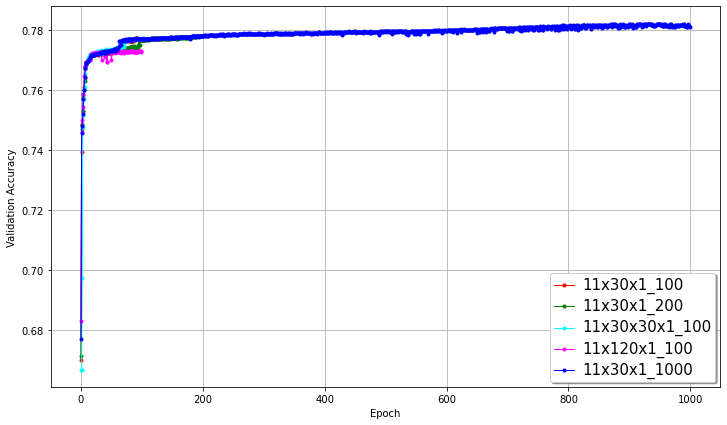

In [26]:
import numpy as np
y_vacc = []
x_len = []
y_vloss = []


plt.figure(figsize=(12,7))


colorlist = ["red",  "green", "cyan","magenta", "blue"]
marklist = ['.', '+', 'o', '*', 'x']
for idx in range(5):
    y_vacc.append(history[idx].history['val_acc'])
    x_len.append(np.arange(len(y_vacc[idx])))
    plt.plot(x_len[idx], y_vacc[idx], marker=marklist[0], lw=1.0, c=colorlist[idx], label=str(idx))    

plt.legend(('11x30x1_100', '11x30x1_200', '11x30x30x1_100', '11x120x1_100', '11x30x1_1000'),
           shadow=True, loc='lower right')
ltext = plt.gca().get_legend().get_texts()
ftsize = 15
plt.setp(ltext[0], fontsize=ftsize)
plt.setp(ltext[1], fontsize=ftsize)
plt.setp(ltext[2], fontsize=ftsize)
plt.setp(ltext[3], fontsize=ftsize)
plt.setp(ltext[4], fontsize=ftsize)

plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.show()
print("\n")

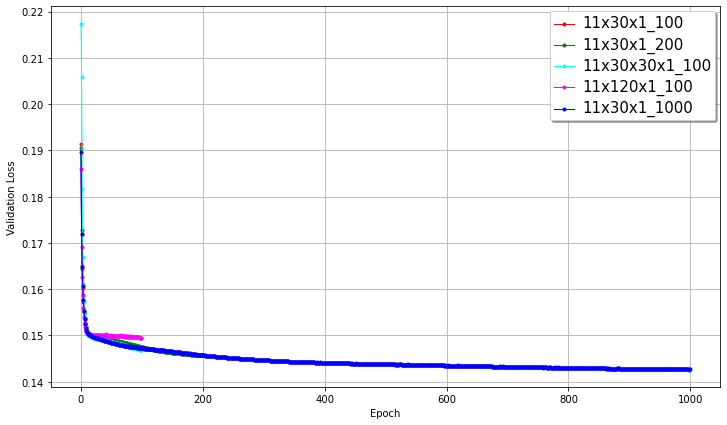

In [36]:
# loss graph
plt.figure(figsize=(12,7))
x_len = []

for idx in range(5):
    y_vloss.append(history[idx].history['val_loss'])
    x_len.append(np.arange(len(y_vloss[idx])))
    plt.plot(x_len[idx], y_vloss[idx], marker='.', lw=1.0, c=colorlist[idx], label=str(idx))

plt.legend(('11x30x1_100', '11x30x1_200', '11x30x30x1_100', '11x120x1_100', '11x30x1_1000'),
           shadow=True, loc='upper right')
ltext = plt.gca().get_legend().get_texts()
ftsize = 15
plt.setp(ltext[0], fontsize=ftsize)
plt.setp(ltext[1], fontsize=ftsize)
plt.setp(ltext[2], fontsize=ftsize)
plt.setp(ltext[3], fontsize=ftsize)
plt.setp(ltext[4], fontsize=ftsize)

plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()
print("\n")

In [39]:
from sklearn.metrics import confusion_matrix, classification_report
model = load_model('mlp_2000.h5')
y_pred = (model.predict(x) > 0.5).astype("int32")
print(confusion_matrix(y, y_pred))
print('Classification Report')
target_names = ['class0', 'class1']
print(classification_report(y, y_pred, target_names=target_names))

[[1213847  244446]
 [  72765  139584]]
Classification Report
              precision    recall  f1-score   support

      class0       0.94      0.83      0.88   1458293
      class1       0.36      0.66      0.47    212349

    accuracy                           0.81   1670642
   macro avg       0.65      0.74      0.68   1670642
weighted avg       0.87      0.81      0.83   1670642



In [65]:
model = load_model('mlp_100.h5')
y_pred = (model.predict(x) > 0.5).astype("int32")
print(confusion_matrix(y, y_pred))
print('Classification Report')
target_names = ['class0', 'class1']
print(classification_report(y, y_pred, target_names=target_names))

[[1216852  241441]
 [  77368  134981]]
Classification Report
              precision    recall  f1-score   support

      class0       0.94      0.83      0.88   1458293
      class1       0.36      0.64      0.46    212349

    accuracy                           0.81   1670642
   macro avg       0.65      0.74      0.67   1670642
weighted avg       0.87      0.81      0.83   1670642



In [66]:
model = load_model('mlp_100.h5')
eval_model = model.evaluate(x, y)
print("Accuracy: ", eval_model[1])

52208/52208 [==============================] - 17s 329us/step - loss: 0.1212 - acc: 0.8092
Accuracy:  0.8091697692871094


In [67]:
model = load_model('mlp_200.h5')
eval_model = model.evaluate(x, y)
print("Accuracy: ", eval_model[1])

52208/52208 [==============================] - 17s 333us/step - loss: 0.1202 - acc: 0.8101
Accuracy:  0.8100969791412354


In [68]:
model = load_model('mlp_1000.h5')
eval_model = model.evaluate(x, y)
print("Accuracy: ", eval_model[1])

52208/52208 [==============================] - 18s 336us/step - loss: 0.1228 - acc: 0.8052
Accuracy:  0.8052048087120056


In [69]:
model = load_model('mlp_2000.h5')
eval_model = model.evaluate(x, y)
print("Accuracy: ", eval_model[1])

52208/52208 [==============================] - 18s 337us/step - loss: 0.1186 - acc: 0.8101
Accuracy:  0.8101263046264648


In [70]:
model = load_model('mlp_6000.h5')
eval_model = model.evaluate(x, y)
print("Accuracy: ", eval_model[1])

52208/52208 [==============================] - 17s 335us/step - loss: 0.1209 - acc: 0.8071
Accuracy:  0.8071460127830505


In [40]:
from sklearn.metrics import confusion_matrix, classification_report
model = load_model('mlp_relu_2000.h5')
y_pred = (model.predict(x) > 0.5).astype("int32")
print(confusion_matrix(y, y_pred))
print('Classification Report')
target_names = ['class0', 'class1']
print(classification_report(y, y_pred, target_names=target_names))

[[1200777  257516]
 [  67312  145037]]
Classification Report
              precision    recall  f1-score   support

      class0       0.95      0.82      0.88   1458293
      class1       0.36      0.68      0.47    212349

    accuracy                           0.81   1670642
   macro avg       0.65      0.75      0.68   1670642
weighted avg       0.87      0.81      0.83   1670642



In [23]:
from sklearn.metrics import confusion_matrix, classification_report
model = load_model('mlp_6000.h5')
y_pred = (model.predict(x) > 0.5).astype("int32")
print(confusion_matrix(y, y_pred))
print('Classification Report')
target_names = ['class0', 'class1']
print(classification_report(y, y_pred, target_names=target_names))

[[      0       0]
 [1274709  395933]]
Classification Report


C:\Users\USER\anaconda3\envs\task1\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      class0       0.00      0.00      0.00         0
      class1       1.00      0.24      0.38   1670642

    accuracy                           0.24   1670642
   macro avg       0.50      0.12      0.19   1670642
weighted avg       1.00      0.24      0.38   1670642



In [41]:
# DT - depth 5

start = time.time() 

dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=seed)
dt.fit(X_train, Y_train)

pred_dt = dt.predict(x)

accuracy_dt = []
accuracy_dt.append(accuracy_score(y, pred_dt))
print('Accuracy: %.4f' % accuracy_dt[0])

print("time :", time.time() - start)

print("\nfeature importance: \n{}".format(dt.feature_importances_))

Accuracy: 0.8173
time : 2.2246146202087402

feature importance: 
[0.00335093 0.18980938 0.01626894 0.71146359 0.02537429 0.00326255
 0.01817666 0.         0.03229366 0.         0.        ]


In [50]:
dot_data = export_graphviz(dt, out_file=None, filled=True, rounded=True, special_characters=True, class_names=["0","1"])
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('dt_depth5.png')


True

In [42]:
y_pred = (dt.predict(x) > 0.5).astype("int32")
print(confusion_matrix(y, y_pred))
print('Classification Report')
target_names = ['class0', 'class1']
print(classification_report(y, y_pred, target_names=target_names))
del dt, pred_dt

[[1240353  217940]
 [  87252  125097]]
Classification Report
              precision    recall  f1-score   support

      class0       0.93      0.85      0.89   1458293
      class1       0.36      0.59      0.45    212349

    accuracy                           0.82   1670642
   macro avg       0.65      0.72      0.67   1670642
weighted avg       0.86      0.82      0.83   1670642



In [43]:
# DT - depth 6

start = time.time() 

dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=5, random_state=seed)
dt.fit(X_train, Y_train)

pred_dt = dt.predict(x)

accuracy_dt.append(accuracy_score(y, pred_dt))
print('Accuracy: %.4f' % accuracy_dt[0])

print("time :", time.time() - start)

print("\nfeature importance: \n{}".format(dt.feature_importances_))

Accuracy: 0.8173
time : 2.560819387435913

feature importance: 
[5.25738051e-03 1.86108599e-01 2.10676781e-02 6.94185407e-01
 2.47051817e-02 9.84421309e-03 2.67937644e-02 0.00000000e+00
 3.14420860e-02 4.72719658e-05 5.48418714e-04]


In [72]:
y_pred = (dt.predict(x) > 0.5).astype("int32")
print(confusion_matrix(y, y_pred))
print('Classification Report')
target_names = ['class0', 'class1']
print(classification_report(y, y_pred, target_names=target_names))
del dt, pred_dt

[[1180045  278248]
 [  65097  147252]]
Classification Report
              precision    recall  f1-score   support

      class0       0.95      0.81      0.87   1458293
      class1       0.35      0.69      0.46    212349

    accuracy                           0.79   1670642
   macro avg       0.65      0.75      0.67   1670642
weighted avg       0.87      0.79      0.82   1670642



In [44]:
# DT - depth 7

start = time.time() 

dt = DecisionTreeClassifier(max_depth=7, min_samples_leaf=5, random_state=seed)
dt.fit(X_train, Y_train)

pred_dt = dt.predict(x)



accuracy_dt.append(accuracy_score(y, pred_dt))
print('Accuracy: %.4f' % accuracy_dt[1])
print("time :", time.time() - start) 
print("\nfeature importance: \n{}".format(dt.feature_importances_))

Accuracy: 0.7945
time : 2.737234115600586

feature importance: 
[5.88554193e-03 1.83977013e-01 2.18509472e-02 6.81912617e-01
 2.50694994e-02 1.64202643e-02 2.95631925e-02 0.00000000e+00
 3.30057527e-02 5.74889428e-04 1.74028269e-03]


In [55]:
y_pred = (dt.predict(x) > 0.5).astype("int32")
print(confusion_matrix(y, y_pred))
print('Classification Report')
target_names = ['class0', 'class1']
print(classification_report(y, y_pred, target_names=target_names))
del dt, pred_dt

[[1210413  247880]
 [  71893  140456]]
Classification Report
              precision    recall  f1-score   support

      class0       0.94      0.83      0.88   1458293
      class1       0.36      0.66      0.47    212349

    accuracy                           0.81   1670642
   macro avg       0.65      0.75      0.68   1670642
weighted avg       0.87      0.81      0.83   1670642



In [18]:
# rf - 7
start = time.time() 
rf_clf = RandomForestClassifier(n_estimators=7, random_state=42)
rf_clf.fit(X_train, Y_train)

pred_rf = rf_clf.predict(x)
print('Accuracy: %.4f'  % accuracy_score(y, pred_rf))
print("time :", time.time() - start) 

Accuracy: 0.8015
time : 9.50615406036377


In [57]:
y_pred = (rf_clf.predict(x) > 0.5).astype("int32")
print(confusion_matrix(y, y_pred))
print('Classification Report')
target_names = ['class0', 'class1']
print(classification_report(y, y_pred, target_names=target_names))
del rf_clf, pred_rf

[[1194182  264111]
 [  69865  142484]]
Classification Report
              precision    recall  f1-score   support

      class0       0.94      0.82      0.88   1458293
      class1       0.35      0.67      0.46    212349

    accuracy                           0.80   1670642
   macro avg       0.65      0.74      0.67   1670642
weighted avg       0.87      0.80      0.82   1670642



In [19]:
# rf - 6
start = time.time()
rf_clf = RandomForestClassifier(n_estimators=6, random_state=42)
rf_clf.fit(X_train, Y_train)

pred_rf = rf_clf.predict(x)
print('Accuracy: %.4f'  % accuracy_score(y, pred_rf))
print("time :", time.time() - start) 

Accuracy: 0.8010
time : 8.226863861083984


In [59]:
y_pred = (rf_clf.predict(x) > 0.5).astype("int32")
print(confusion_matrix(y, y_pred))
print('Classification Report')
target_names = ['class0', 'class1']
print(classification_report(y, y_pred, target_names=target_names))
del rf_clf, pred_rf

[[1194265  264028]
 [  70282  142067]]
Classification Report
              precision    recall  f1-score   support

      class0       0.94      0.82      0.88   1458293
      class1       0.35      0.67      0.46    212349

    accuracy                           0.80   1670642
   macro avg       0.65      0.74      0.67   1670642
weighted avg       0.87      0.80      0.82   1670642



In [20]:
# rf - 5
start = time.time()
rf_clf = RandomForestClassifier(n_estimators=5, random_state=42)
rf_clf.fit(X_train, Y_train)

pred_rf = rf_clf.predict(x)
print('Accuracy: %.4f'  % accuracy_score(y, pred_rf))
print("time :", time.time() - start) 

Accuracy: 0.8012
time : 7.2556445598602295


In [61]:
y_pred = (rf_clf.predict(x) > 0.5).astype("int32")
print(confusion_matrix(y, y_pred))
print('Classification Report')
target_names = ['class0', 'class1']
print(classification_report(y, y_pred, target_names=target_names))
del rf_clf, pred_rf

[[1196958  261335]
 [  70652  141697]]
Classification Report
              precision    recall  f1-score   support

      class0       0.94      0.82      0.88   1458293
      class1       0.35      0.67      0.46    212349

    accuracy                           0.80   1670642
   macro avg       0.65      0.74      0.67   1670642
weighted avg       0.87      0.80      0.83   1670642

